In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy.stats as sts
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import seaborn as sns
from scipy.optimize import curve_fit, minimize, fsolve
from copy import deepcopy
import ctypes
from root_to_np import get_tree, get_df, rename_tree_branches
from parametrize import fff, ffm


Welcome to JupyROOT 6.26/14
END OF SCRIPT


In [2]:
!pip install SciencePlots


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
#plt.style.use(['notebook', 'science'])
plt.style.use(['default'])
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.title_fontsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['text.usetex'] = False
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.framealpha'] = 1

plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.titleweight'] = 'bold'

# plt.rcParams.keys()

In [4]:
import ROOT

## Fit Functions

In [5]:
def expo1(x, pars):
    return ROOT.TMath.Exp(x[0]*pars[0]+pars[1])+pars[2]
    
def expo1_np(x, pars):
    return np.exp(x*pars[0]+pars[1])+pars[2]


def expo2(x, pars):
    return ROOT.TMath.Exp(pars[0]*x[0] + pars[1]) + ROOT.TMath.Exp(pars[2]*x[0] + pars[3]) + pars[4]

def expo2_np(x, pars):
    return np.exp(pars[0]*x + pars[1]) + np.exp(pars[2]*x + pars[3]) + pars[4]

def pol2(x, a, b, c):
    return a*(x-b)*(x-b)+c

# SAT vs parameters for twalk correction

In [6]:
cc_sat = ROOT.TCanvas('sat_fit','', 1000, 800)
def sat_fit(xpar, ypar, expar, eypar, iistart=0, iistop=None, xl=0.02, xu=0.5, pars=None):
#     iistart, iistop = 0, None
    cc_sat.cd(0)
    grcci = ROOT.TGraphErrors(len(xpar[iistart:iistop]), xpar[iistart:iistop], ypar[iistart:iistop], expar[iistart:iistop], eypar[iistart:iistop])
    grcci.SetNameTitle('grcci', ' ;Charge [pC];SAT [ps]')


    fffi = ROOT.TF1('ffsat', expo2, xl, xu, 5)
    wFiti = ROOT.Math.WrappedMultiTF1(fffi, 1);
    fopt =  ROOT.Fit.DataOptions()
    fopt.fCoordErrors = False
    rangeB = ROOT.Fit.DataRange()
    if iistop == None:
        rangeB.SetRange(xpar[iistart], xpar[-1])
    else:
        rangeB.SetRange(xpar[iistart], xpar[iistop])
    dataB = ROOT.Fit.BinData(fopt, rangeB);
    ROOT.Fit.FillData(dataB, grcci);
    chi2f = ROOT.Fit.Chi2Function(dataB, wFiti)

    fitter = ROOT.Fit.Fitter()

    par0 = np.array([-1.19593947e+01,  1.52272605e+01, -5.23861833e-01,  5.09975903e+00, 100])
    if pars != None:
        par0 = np.array(pars)
        
    fitter.Config().SetParamsSettings(5, par0)
    fitter.Config().MinimizerOptions().SetPrintLevel(1)
    fitter.Config().MinimizerOptions().SetMaxFunctionCalls(100000) # for Minuit/Minuit2
    fitter.Config().MinimizerOptions().SetMaxIterations(10000) # for GSL
    fitter.Config().SetMinimizer("Minuit2", "Migrad")

    fitter.FitFCN(chi2f)
    result = fitter.Result()

    parsi = np.zeros(5)
    for i in range(5):
        parsi[i] = fffi.GetParameter(i)
#     print(parsi)


    grcci.GetListOfFunctions().Add(fffi)
    grcci.DrawClone('ap')

    cc_sat.Draw()
    return parsi

## Change from Beam Frame to Local  Frame Functions

In [7]:
# def beam_coords(i, params):
#     d = 0.20
#     x0, y0, u = params
#     xl = np.sign(xdata[i] - (-x0)) * (d + 9.82) / 2
#     yl = np.sign(ydata[i] - (-y0)) * (d + 9.82) / 2
    
#     # Ensure that xl and yl are not both zero to avoid division by zero
#     if xl == 0 and yl == 0:
#         xl += 1e-10
    
#     return ((xl - x0) * np.cos(u) + (yl - y0) * np.sin(u), -(xl - x0) * np.sin(u) + (yl - y0) * np.cos(u))

def beam_coords(i,params):
    d =0.20
    x0,y0,u = params
    xl = np.sign(xdata[i]-(-x0))*(d+9.82)/2
    yl = np.sign(ydata[i]-(-y0))*(d+9.82)/2
    return((xl - x0)*np.cos(u)+(yl-y0)*np.sin(u), -(xl - x0)*np.sin(u)+(yl-y0)*np.cos(u))

#def chi2_i(i,params):
#    xb, yb = beam_coords(i,params) 
#    return ((xdata[i]-xb)/sigmax[i])**2+((ydata[i]-yb)/sigmay[i])**2
def chi2_i(i, params):
    xb, yb = beam_coords(i, params)
    
    # Check if sigmax or sigmay is zero, and handle it
    if sigmax[i] == 0 or sigmay[i] == 0:
        # Handle the case where sigmax or sigmay is zero, e.g., set the corresponding term to zero
        return 0.0
    else:
        return ((xdata[i] - xb) / sigmax[i])**2 + ((ydata[i] - yb) / sigmay[i])**2

def chi2(params):
    return chi2_i(0,params)+chi2_i(1,params)+chi2_i(2,params)+chi2_i(3,params)

def weird_gaussian( x, p ):
    #c, mu1, mu2, sigma = params
    res =   p[0] * (np.exp( - (x[0] - p[1])**2.0 / (2.0 * p[3]**2.0) ) \
          + np.exp( - (x[0] - p[2])**2.0 / (2.0 * p[3]**2.0) ))
    return res

def weirdo_gaussian( x, *p ):
    c, mu1, mu2, sigma = p
    res =   c * (np.exp( - (x - mu1)**2.0 / (2.0 * sigma**2.0) ) \
          + np.exp( - (x - mu2)**2.0 / (2.0 * sigma**2.0) ))
    return res

def parabola( x, p ):
    res =   p[0] * (x[0]-p[1])**2 +p[2]
    return res

def parabolic( x, *p ):
    a, mu, b = p
    res =   a*(x-mu)**2+b
    return res

#def sym_to_beam(xy, theta):
    #x = [point[0] for point in xy]
    #y = [point[1] for point in xy]
    #return (x*np.cos(theta)+y*np.sin(theta), -x*np.sin(theta)+y*np.cos(theta))

#def sym_to_beam(xy , theta):
#    x,y = xy
#    return (x*np.cos(theta)+y*np.sin(theta), -x*np.sin(theta)+y*np.cos(theta))
def sym_to_beam(xy, theta):
    xy = np.array(xy)  # Convert the input list to a NumPy array
    x = xy[:, 0]  # Extract the x-values
    y = xy[:, 1]  # Extract the y-values
    x_s = x * np.cos(theta) + y * np.sin(theta)
    y_s = -x * np.sin(theta) + y * np.cos(theta)
    return x_s, y_s

In [8]:
#scan_files = {'/eos/home-a/akallits/SWAN_projects/pico/run320_merged.root':'Pico'}
#scan_files = {'/eos/home-a/akallits/SWAN_projects/pico/Run460_parameters.root':'Pico'} # Run 460 Pool 4 Picolarge Pad0 500/275 MCP3 pos -1570
scan_files = {'/sw/akallits/PycharmProjects/PicoAnalysis/root-files/Run460_parameters.root':'Pico'} # Run 460 Pool 4 Picolarge Pad0 500/275 MCP3 pos -1570
#scan_files = {'/eos/home-a/akallits/SWAN_projects/pico/run323_merged.root':'Pico'}

In [9]:
def get_tree(run):
    #rootfile = uproot.open(f"/eos/home-a/akallits/SWAN_projects/pico/Run{run}_parameters.root");
    rootfile = uproot.open(f"/sw/akallits/PycharmProjects/PicoAnalysis/root-files/Run{run}_parameters.root");
    #rootfile = uproot.open(f"/home/akallits/Desktop/JULY_RUNS/run{run}.root");
    key = rootfile.keys()
    print(key)

    tree = rootfile["Pico"]
    key = tree.keys()

    print(key)
    #rootfile.close()
    return tree

In [10]:
def get_df(tree, *indexes):
    dataframe = pd.DataFrame() # empty dataframe
    branches = []
    for i in indexes:
        try:
            branch = tree.keys()[i]
            branches.append(branch)
        except IndexError:
            print(f"Index {i} is out of range for the tree keys.")
    #branches =[tree.keys()[i] for i in indexes]

    for df, report in tree.iterate(branches, step_size='1 MB',library='pd', report = True):
        print(report)
        dataframe = pd.concat([dataframe,df], ignore_index=True)

    return dataframe

In [11]:
def rename_tree_branches(df,*col_names):
    l = len(col_names[0])  
    for i in range(l):
        df.rename(columns = {col_names[0][i]:col_names[1][i]}, inplace = True)
    
    return df

In [12]:
def store_new_tree(df):
    newfile = uproot.recreate("./example.root")
    newfile['tree'] = df
    newfile.close()

In [13]:
data =[]
run = [460]
for irun in run:
    tree = get_tree(irun)
    var_indexes = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39])
    data_single = get_df(tree,*var_indexes)
    old_names = ['MCP1_global_maximum_y','MCP1_e_charge', 'MCP1_all_charge','MCP1_sigmoid_timepoint','MM1_global_maximum_y','MM1_e_charge','MM1_all_charge','MM1_sigmoid_timepoint','POS0_track_hit', 'TrackChi2', 'NumberofTracks',  'SRSnumber']
    new_names = ['mcp1_gpeak','mcp1_qe', 'mcp1_qall','mcp1_t','mm1_gpeak','mm1_qe', 'mm1_qall','mm1_tfit','xy', 'chi2', 'track_flag',  'SRSnumber']
    names = [old_names,new_names]
    data_single = rename_tree_branches(data_single,*names)
    print(len(data_single))
    data.append(data_single)

# Concatenate the list of DataFrames into a single DataFrame
data = pd.concat(data)

##old code 

#for irun in run:
#     tree = get_tree(irun)
    
#     var_indexes = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38])
#     #for index in range(4):
#         #var_indexes = np.append(var_indexes,[index*10+8,index*10+9,index*10+12,index*10+14]) # choose which collums you need from the DF
#     #var_indexes = np.append(var_indexes,[67,65,66])
    
#     data_single = get_df(tree,*var_indexes)
    
#     old_names = ['MCP1_global_maximum_y','MCP1_all_charge','MCP1_sigmoid_timepoint','TrackChi2', 'NumberofTracks']
#     new_names = ['mcp1_gpeak','mcp1_qall','mcp1_t','chi2', 'track_flag']
#     names = [old_names,new_names]
#     data_single = rename_tree_branches(data_single,*names)
    
#     print(len(data_single))
#     data.append(data_single)

# data = pd.concat(data)


#print(data.head())
#print(len(data))

['Pico;1']
['Baseline_Window', 'MCP1_baseline_level', 'MCP1_baseline_rms', 'MCP1_global_maximum_y', 'MCP1_global_maximum_x', 'MCP1_start_x', 'MCP1_e_peak_end_x', 'MCP1_e_charge', 'MCP1_all_charge', 'MCP1_twentypercent_time', 'MCP1_naive_time', 'MCP1_naive_x', 'MCP1_cfd_time', 'MCP1_sigmoid_timepoint', 'MM1_baseline_level', 'MM1_baseline_rms', 'MM1_global_maximum_y', 'MM1_global_maximum_x', 'MM1_start_x', 'MM1_e_peak_end_x', 'MM1_e_charge', 'MM1_all_charge', 'MM1_twentypercent_time', 'MM1_naive_time', 'MM1_naive_x', 'MM1_cfd_time', 'MM1_sigmoid_timepoint', 'MM1_sigmoid_parameters', 'MM1_sigmoid_chi_square', 'MM1_sigmoid_failed', 'MM1_Fullsigmoid_charge', 'MM1_Fullsigmoid_chi2', 'MM1_Fullsigmoid_fail', 'MM1_Fullsigmoid_parameters', 'NumberofTracks', 'POS0_track_hit', 'TrackChi2', 'SlopeXZ', 'SlopeYZ', 'SRSnumber']
<Report start=0 stop=3521 source='/sw/akallits/PycharmProjects/PicoAnalysis/root-files/Run460_parameters.root:/Pico;1'>
<Report start=3521 stop=7042 source='/sw/akallits/Pychar

In [14]:
#Debug variables observation

column_number = data.iloc[0, 2]
print("Column Number:", column_number)


column_indices = data.columns
print(column_indices)

column_indices = list(range(len(data.columns)))
print(column_indices)


mcp_data =  data.iloc[:, 8]
print(mcp_data)


mm_data_charge =  data.iloc[:, 20].values
print(mm_data_charge)
len(mm_data_charge)


mm_data_charge_all =  data.iloc[:, 21].values
print(mm_data_charge_all)
len(mm_data_charge_all)

Column Number: 0.000908897849962669
Index(['Baseline_Window', 'MCP1_baseline_level', 'MCP1_baseline_rms',
       'mcp1_gpeak', 'MCP1_global_maximum_x', 'MCP1_start_x',
       'MCP1_e_peak_end_x', 'mcp1_qe', 'mcp1_qall', 'MCP1_twentypercent_time',
       'MCP1_naive_time', 'MCP1_naive_x', 'MCP1_cfd_time', 'mcp1_t',
       'MM1_baseline_level', 'MM1_baseline_rms', 'mm1_gpeak',
       'MM1_global_maximum_x', 'MM1_start_x', 'MM1_e_peak_end_x', 'mm1_qe',
       'mm1_qall', 'MM1_twentypercent_time', 'MM1_naive_time', 'MM1_naive_x',
       'MM1_cfd_time', 'mm1_tfit', 'MM1_sigmoid_parameters',
       'MM1_sigmoid_chi_square', 'MM1_sigmoid_failed',
       'MM1_Fullsigmoid_charge', 'MM1_Fullsigmoid_chi2',
       'MM1_Fullsigmoid_fail', 'MM1_Fullsigmoid_parameters', 'track_flag',
       'xy', 'chi2', 'SlopeXZ', 'SlopeYZ', 'SRSnumber'],
      dtype='object')
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37

32800

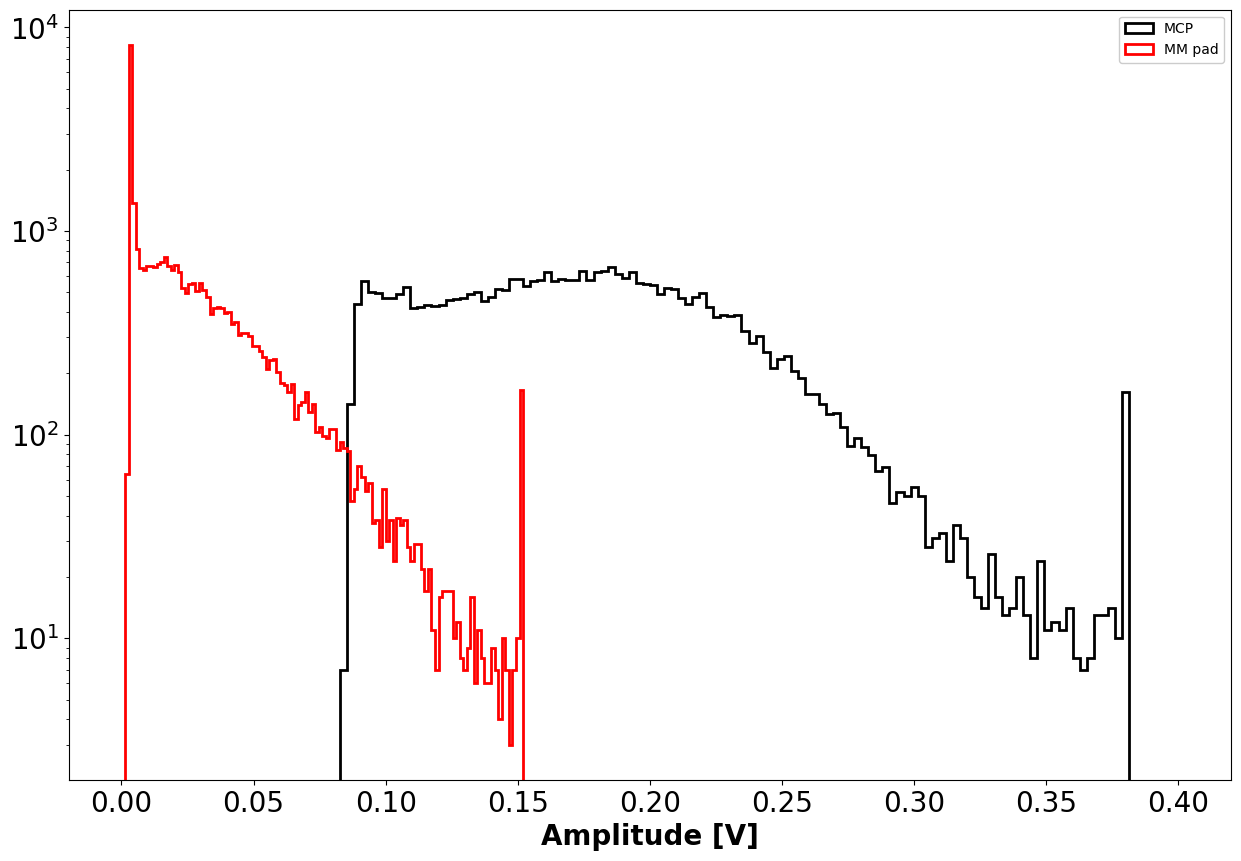

In [15]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mcp_vs)):
axs.hist(data.mcp1_gpeak, bins=150, range=(0.0, 0.4), histtype='step', color='black', lw=2, label=f'MCP')
axs.hist(data.mm1_gpeak, bins=150, range=(0.0, 0.2), histtype='step', color='red', lw=2, label=f'MM pad')
axs.set_yscale('log')
axs.set_xlabel('Amplitude [V]')
axs.set_title('')
axs.legend()
plt.show()

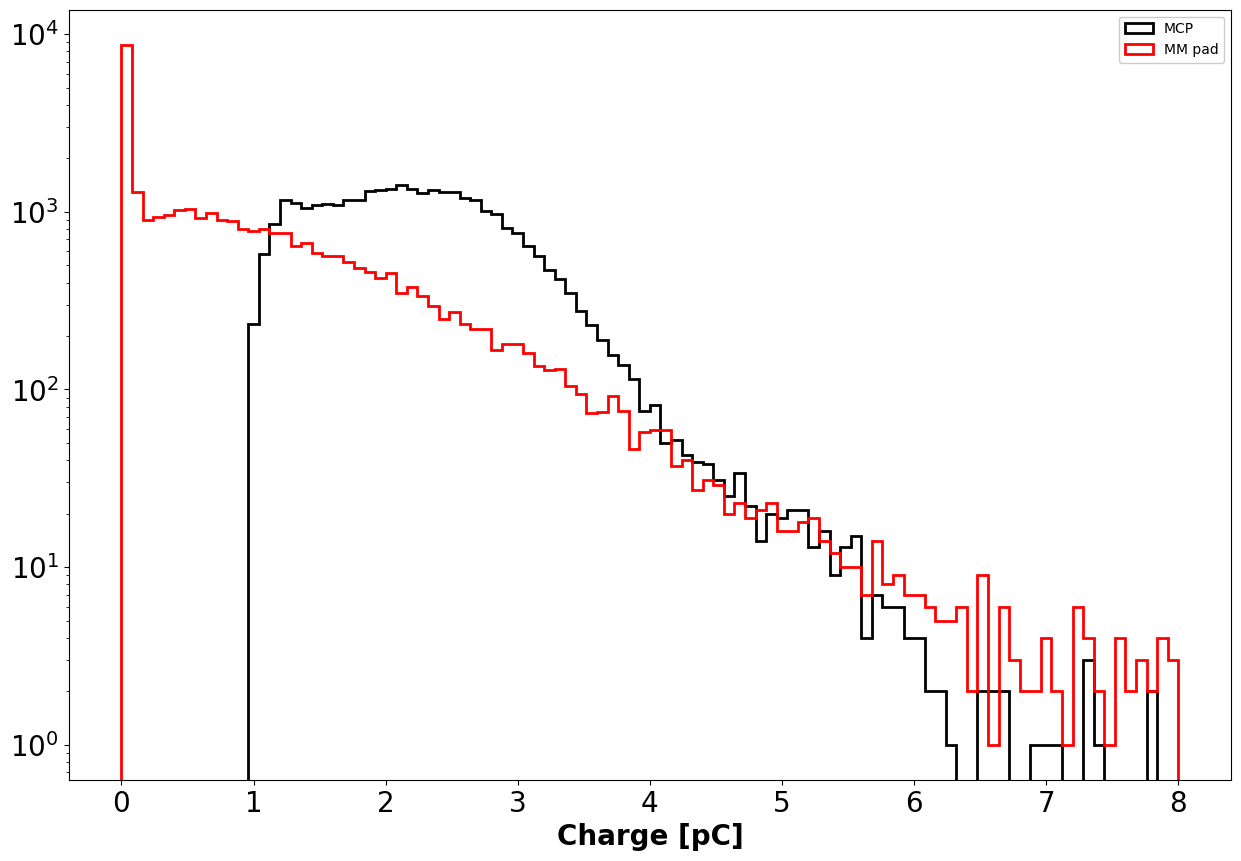

In [16]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mcp_qs)):
axs.hist(data.mcp1_qe, bins=100, range=(0.0, 8), histtype='step', color='black', lw=2, label=f'MCP')
axs.hist(data.mm1_qe, bins=100, range=(0.0, 8), histtype='step', color='red', lw=2, label=f'MM pad')
axs.set_yscale('log')
axs.set_xlabel('Charge [pC]')
axs.set_title('')
axs.legend()
plt.show()

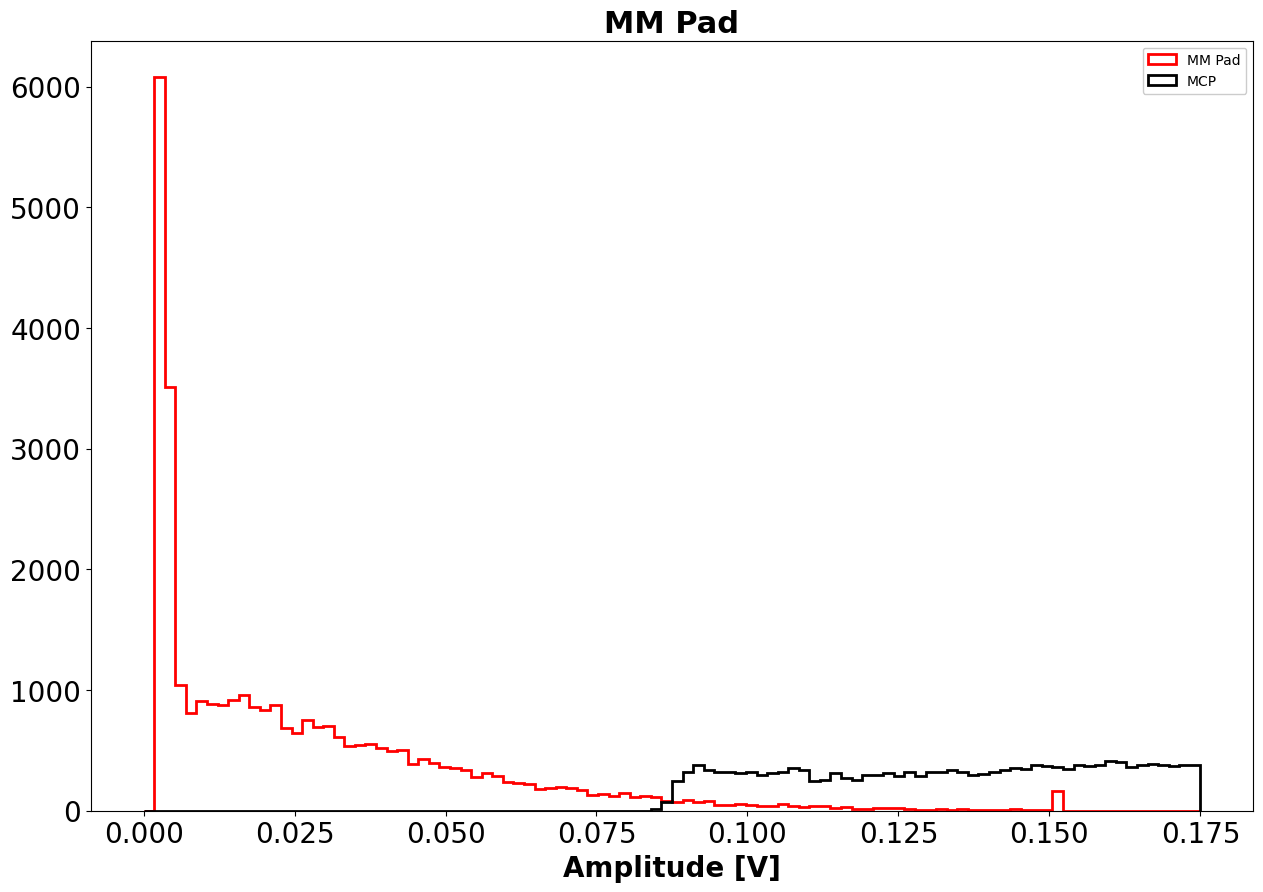

In [17]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mm_vs)):
axs.hist(data.mm1_gpeak, bins=100, range=(0.0, 0.175), histtype='step', color='red', lw=2, label=f'MM Pad')
axs.hist(data.mcp1_gpeak, bins=100, range=(0.0, 0.175), histtype='step', color='black', lw=2, label=f'MCP')
# axs.set_yscale('log')
axs.set_xlabel('Amplitude [V]')
axs.set_title('MM Pad')
axs.legend()
plt.show()

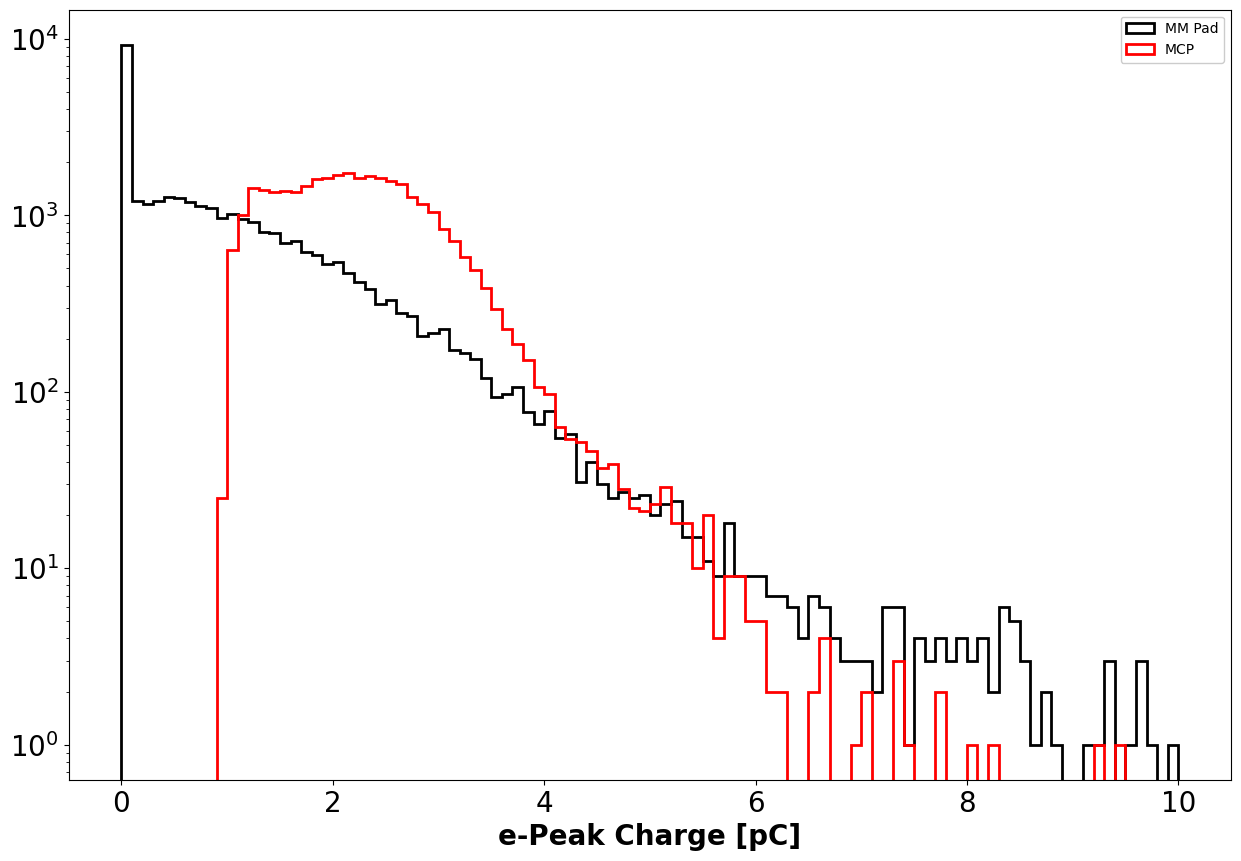

In [18]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mm_qes)):
axs.hist(data.mm1_qe, bins=100, range=(0.0, 10), histtype='step', color="black", lw=2, label=f'MM Pad')
axs.hist(data.mcp1_qall, bins=100, range=(0.0, 10), histtype='step', color='red', lw=2, label=f'MCP')
axs.set_yscale('log')
axs.set_xlabel('e-Peak Charge [pC]')
axs.set_title('')
axs.legend()
plt.show()

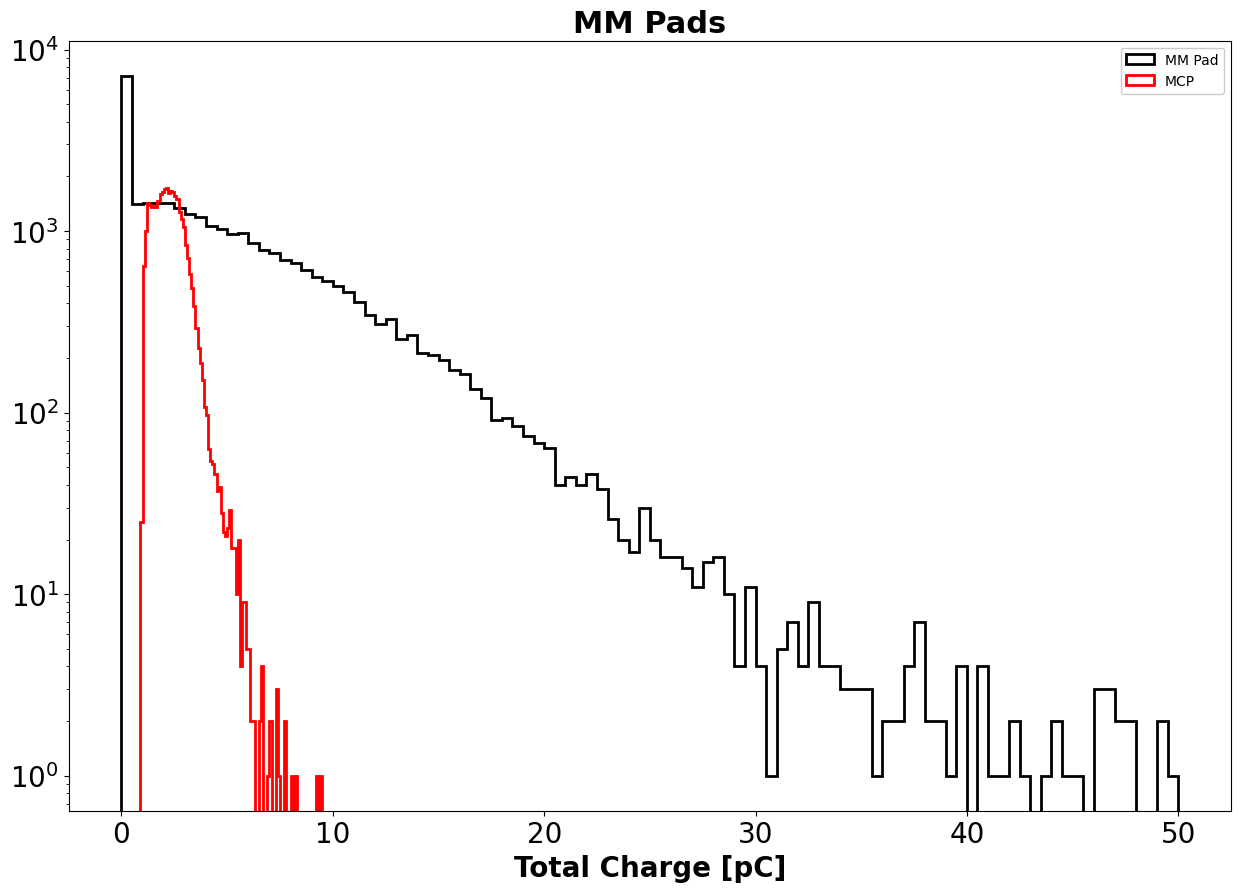

In [19]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mm_qalls)):
axs.hist(data.mm1_qall, bins=100, range=(0.0, 50), histtype='step', color='black', lw=2, label=f'MM Pad')
axs.hist(data.mcp1_qe, bins=100, range=(0.0, 10), histtype='step', color='red', lw=2, label=f'MCP')
axs.set_yscale('log')
axs.set_xlabel('Total Charge [pC]')
axs.set_title('MM Pads')
axs.legend()
plt.show()

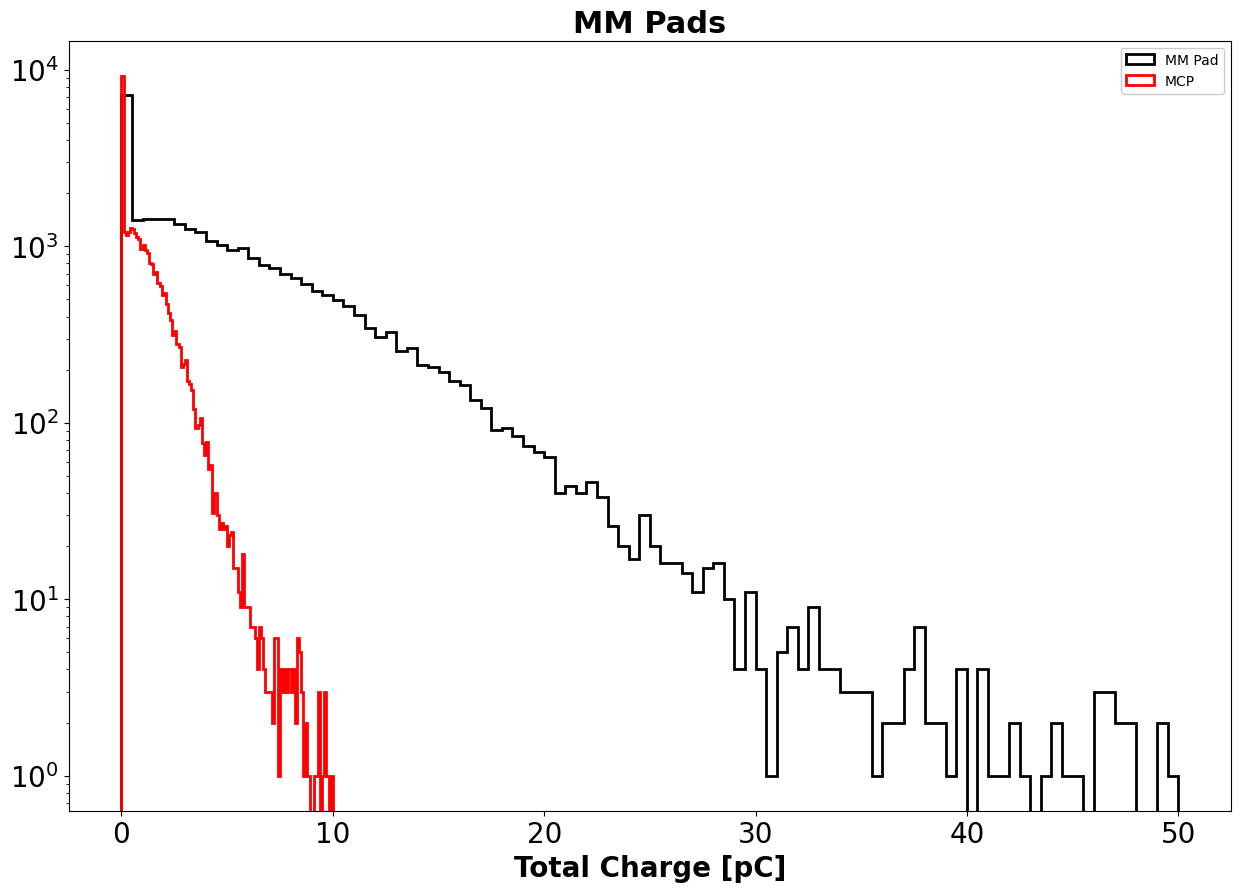

In [20]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mm_qalls)):
axs.hist(data.mm1_qall, bins=100, range=(0.0, 50), histtype='step', color='black', lw=2, label=f'MM Pad')
axs.hist(data.mm1_qe, bins=100, range=(0.0, 10), histtype='step', color='red', lw=2, label=f'MCP')
axs.set_yscale('log')
axs.set_xlabel('Total Charge [pC]')
axs.set_title('MM Pads')
axs.legend()
plt.show()

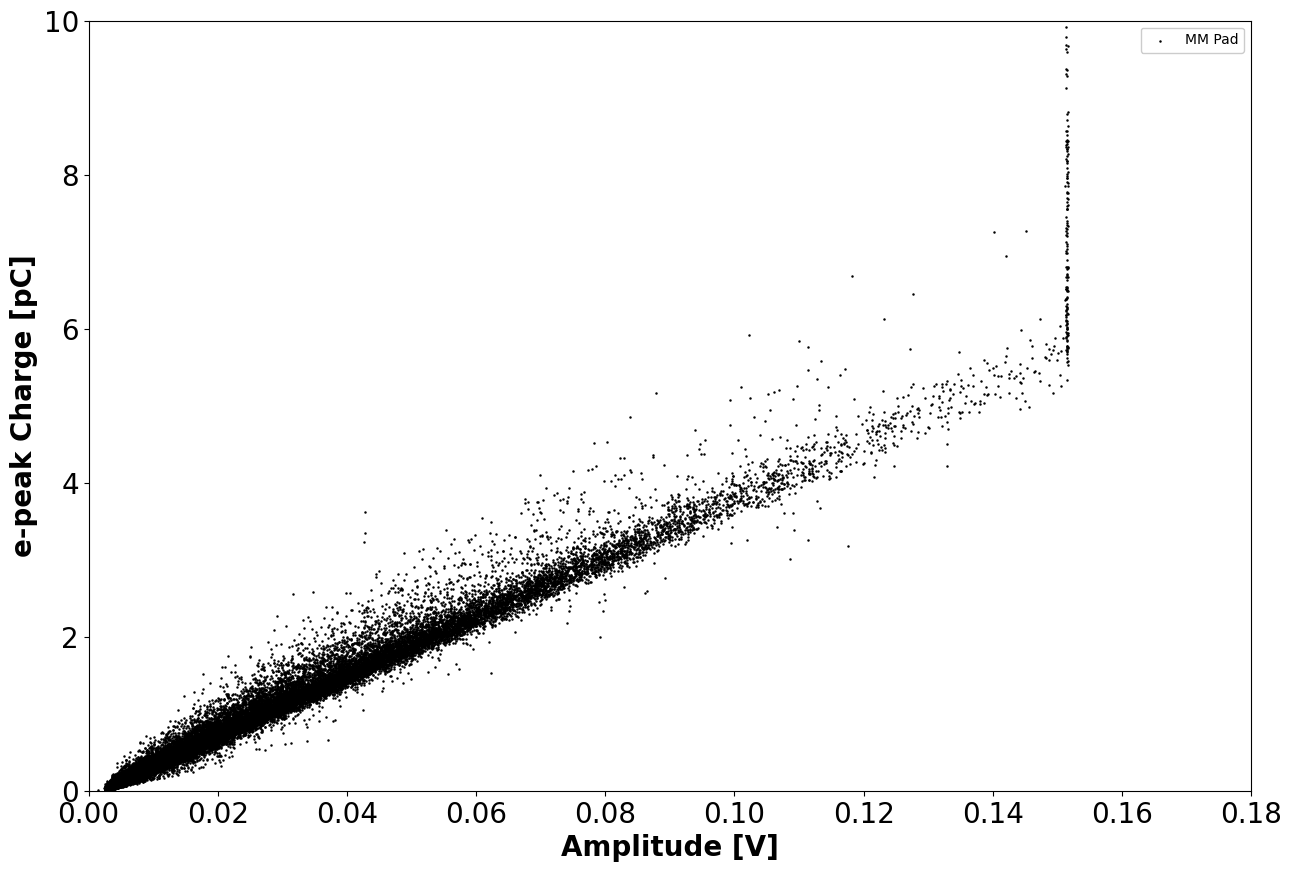

In [21]:
fig, axs = plt.subplots(figsize=(15, 10))

#for i in range(len(mm_vs)):
axs.scatter(data.mm1_gpeak, data.mm1_qe, s=0.6, color='black', label=f'MM Pad')
    
axs.set_xlabel('Amplitude [V]')
axs.set_ylabel('e-peak Charge [pC]')
axs.set_xlim(0, 0.18)
axs.set_ylim(0, 10)
axs.legend()

plt.show()

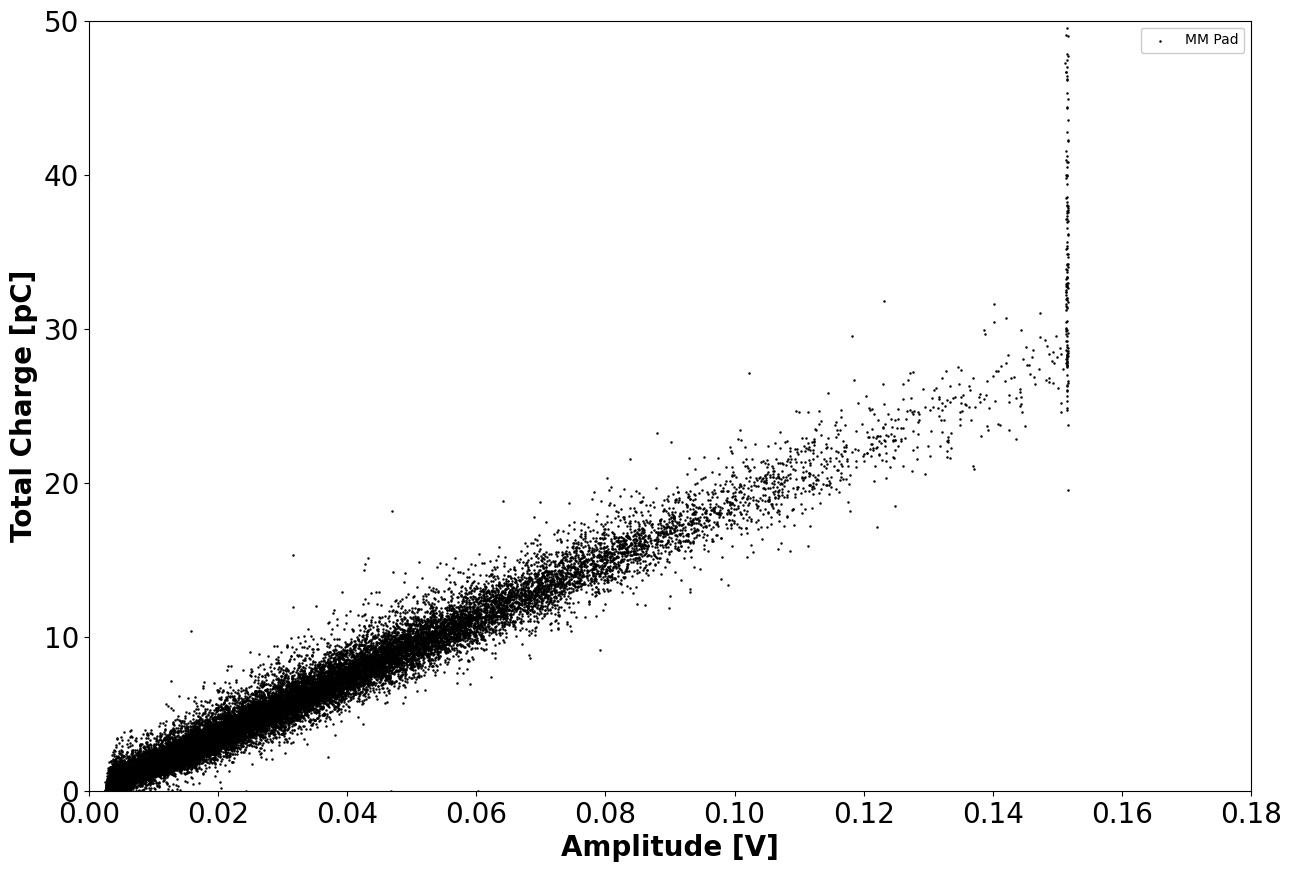

In [22]:
fig, axs = plt.subplots(figsize=(15, 10))

#for i in range(len(mm_vs)):
axs.scatter(data.mm1_gpeak, data.mm1_qall, s=0.6, color='black', label=f'MM Pad')
    
axs.set_xlabel('Amplitude [V]')
axs.set_ylabel('Total Charge [pC]')
axs.set_xlim(0, 0.18)
axs.set_ylim(0, 50)
axs.legend()

plt.show()

In [23]:
#xy = xy.values.reshape(-1, 2)  # Reshape into pairs of x-y values

## CALCULATIONS

In [24]:
track_flag = data.track_flag
valid_tracks = track_flag == 1

In [25]:
mcp_overflow = (data.mcp1_gpeak>0)*(data.mcp1_gpeak<=0.35)
chi2_cut = (data.chi2<=50)*(data.track_flag>0)
mcp_basic_cut = mcp_overflow*chi2_cut

In [26]:
print(data.xy)

0                               [1000.0 1000.0 1000.0]
1                               [1000.0 1000.0 1000.0]
2         [48.07969995129356 50.78583335938744 1570.0]
3         [45.02063682216872 50.00186217050422 1570.0]
4         [46.86736051329651 39.42506027724691 1570.0]
                             ...                      
32795    [44.434775370225545 40.74029466074562 1570.0]
32796      [50.69830728871604 43.2798565104994 1570.0]
32797    [41.69584737137238 44.156043667378924 1570.0]
32798     [50.37965547078584 43.97640736492384 1570.0]
32799                           [1000.0 1000.0 1000.0]
Name: xy, Length: 32800, dtype: awkward


In [27]:
if 'cc' in globals():
    del cc

cc = ROOT.TCanvas('cc', '', 800, 1000)

ROOT.gStyle.SetOptFit(1111)

# Check if a histogram with the name "xytrks" already exists
existing_hist = ROOT.gROOT.FindObject('xytrks')
if existing_hist:
    existing_hist.Delete()

#tracks multiplicity
xytrks = ROOT.TH2F("xytrks", f'RUN {run}: All tracks multiplicity', 100, 15, 80, 100, 10, 80)
xytrks.GetXaxis().SetTitle("x [mm]")
xytrks.GetYaxis().SetTitle("y [mm]")


n = len(data[mcp_basic_cut])
xy_values = data.xy[mcp_basic_cut].values
x_indices = range(0, len(xy_values), 3)
y_indices = range(1, len(xy_values), 3)
w = np.ones(n)

# Loop to fill the histogram
for i, x_idx in enumerate(x_indices):
    x_value = xy_values[x_idx]
    y_value = xy_values[y_indices[i]]
    xytrks.Fill(x_value, y_value, w[i])

# Clear out areas with low number of tracks (not enough statistics)
for i in range(xytrks.GetNbinsX() + 1):
    for j in range(xytrks.GetNbinsY() + 1):
        if xytrks.GetBinContent(i, j) < 1 :
            xytrks.SetBinContent(i, j, 0)

xytrks.SetTitle(f'RUN{run}: xy tracks with multiplicity > 1')
xytrks.Draw("colz")
cc.Draw()

TypeError: none of the 5 overloaded methods succeeded. Full details:
  int TH2::Fill(const char* namex, const char* namey, double w) =>
    TypeError: could not convert argument 1 (bad argument type for built-in operation)
  int TH2::Fill(double x, double y) =>
    TypeError: takes at most 2 arguments (3 given)
  int TH2::Fill(double x, const char* namey, double w) =>
    TypeError: could not convert argument 1 (must be real number, not Array)
  int TH2::Fill(const char* namex, double y, double w) =>
    TypeError: could not convert argument 1 (bad argument type for built-in operation)
  int TH2::Fill(double x, double y, double w) =>
    TypeError: could not convert argument 1 (must be real number, not Array)

In [ ]:
cc.Draw()

In [ ]:
# c = ROOT.TCanvas()

# xytrks = ROOT.TH2F("xytrks", f'RUN{run}: All tracks multiplicity', 100, 0, 50, 100, 0, 50)

# xytrks.GetXaxis().SetTitle("x")
# xytrks.GetYaxis().SetTitle("y")

# n = len(data[mcp_basic_cut])
# xy_values = data.xy[mcp_basic_cut].values
# x_indices = range(0, len(xy_values), 3)
# y_indices = range(1, len(xy_values), 3)
# w = np.ones(n)

# # Loop to fill the histogram
# for i, x_idx in enumerate(x_indices):
#     x_value = x[x_idx]
#     y_value = y[y_indices[i]]
#     xytrks.Fill(x_value, y_value, w[i])

# for i in range(xytrks.GetNbinsX() + 1):
#     for j in range(xytrks.GetNbinsY() + 1):
#         if xytrks.GetBinContent(i, j) < 15:
#             xytrks.SetBinContent(i, j, 0)

# xytrksW = ROOT.TH2F("xytrksW", f'RUN{run}: xy tracks weighted by MCP charge', 100, 0, 50, 100, 0, 50)
# xytrksW.GetXaxis().SetTitle("x [mm]")
# xytrksW.GetYaxis().SetTitle("y [mm]")

# w = data.iloc[:, 7][mcp_basic_cut].values

# xytrksW.FillN(n, x, y, w)

# xytrksW.Divide(xytrks)


In [ ]:
import ctypes
c = ROOT.TCanvas()

xytrks = ROOT.TH2F("xytrks",f'RUN{run}: All tracks multiplicity',100,0,50,100,0,50)

xytrks.GetXaxis().SetTitle("x")
xytrks.GetYaxis().SetTitle("y")

n = len(data[mcp_basic_cut])
xy_values = data.xy[mcp_basic_cut].values
x = data.xy[mcp_basic_cut].values[::3]
print(x)
y = data.xy[mcp_basic_cut].values[1::3]
print(y)
w = np.ones(n)

# Convert NumPy arrays to ctypes arrays
x_arr = (ctypes.c_double * len(x))(*x)
y_arr = (ctypes.c_double * len(y))(*y)
w_arr = (ctypes.c_double * len(w))(*w)

# Now use these ctypes arrays in TH2::FillN
xytrks.FillN(n, x_arr, y_arr, w_arr)

#xytrks.FillN(n,x,y,w)

for i in range(xytrks.GetNbinsX()+1):
    for j in range(xytrks.GetNbinsY()+1):
        if xytrks.GetBinContent(i,j)<15:
            xytrks.SetBinContent(i,j,0)

xytrksW = ROOT.TH2F("xytrksW",f'RUN{run}: xy tracks weighted by MCP charge',100,0,50,100,0,50)
xytrksW.GetXaxis().SetTitle("x [mm]")
xytrksW.GetYaxis().SetTitle("y [mm]")

w = data.iloc[:, 7][mcp_basic_cut].values

xytrksW.FillN(n,x_arr, y_arr, w_arr)

xytrksW.Divide(xytrks)

In [ ]:
#define the cuts
mm_basic_cut= []
#for index in range(4):

# mm_gpeak = f'MM1_global_maximum_y'
# mm_qall = f'MM1_all_charge'
# mm_qe = f'MM1_e_charge'
# mm_qfit = f'MM1_sigmoid_timepoint'
mm_overflow = (data.mm1_gpeak>0.)*(data.mm1_gpeak<0.36)*(data.mm1_qe>0)
qe_line = (data.mm1_qe>30.*data.mm1_gpeak)
#cut = np.logical_and(mm_overflow*mcp_basic_cut,qe_line)

mm_basic_cut = np.logical_and(mm_overflow*mcp_basic_cut,qe_line)

#mm_basic_cut.append(cut)

In [ ]:
# we find the pad here!
    
xytrksW_mm = ROOT.TH2F(f'xytrksW - MM',f'RUN {run}: xy tracks weighted by PAD e-peak row charge',
                       100,0,50,100,0,50)
xytrksW_mm.GetXaxis().SetTitle("x")
xytrksW_mm.GetYaxis().SetTitle("y")

#selected_data = data.loc[mm_basic_cut[0]]
#print(selected_data)
n = len(data[mm_basic_cut])
print(n)

xy_values = data.xy[mm_basic_cut].values #selected_data.iloc[:, -4].values
print(xy_values)
x_indices = range(0, len(xy_values), 3)
x_indices_array = np.array(list(x_indices), dtype=float)
print(x_indices)
y_indices = range(1, len(xy_values), 3)
y_indices_array = np.array(list(y_indices), dtype=float)
print(y_indices)
xytrksW_mm.FillN(n,x_indices_array,y_indices_array,w)
    
xytrksW_mm.Divide(xytrks)
    

pad_hist = xytrksW_mm.Clone()
pad_hist.SetName(f'MMpad_hist')
pad_hist.SetTitle(f' MM-PAD')
for i in range(pad_hist.GetNbinsX()+1):
    for j in range(pad_hist.GetNbinsY()+1):
        if pad_hist.GetBinContent(i,j)<2.:
            pad_hist.SetBinContent(i,j,0)

## Display selected

In [ ]:
v_limits = data.mm1_gpeak>0
qall_limits = (data.mm1_qall>0)*(data.mm1_qall<50)
qe_limits = (data.mm1_qe>0)*(data.mm1_qe<12)
qfit_limits = (data.mm1_qall>0)*(data.mm1_qall<12)

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(10,20))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'RUN {run}: PAD distributions', fontsize=15, fontweight='bold')


ax = axes[0][0]
ax.hist(data.mm1_gpeak[v_limits], bins =100,color = 'black', histtype='step')
ax.hist(data.mcp1_gpeak[v_limits], bins =100,color = 'red', histtype='step')
ax.set_xlabel('e-peak amplitude [V]',loc='right')
ax.grid()
ax = axes[0][1]
ax.hist(data.mm1_gpeak[v_limits], bins =100,color = 'black', histtype='step')
ax.hist(data.mcp1_gpeak[v_limits], bins =100,color = 'red', histtype='step')

ax.set_xlabel('e-peak amplitude [V]',loc='right')
ax.grid()
ax.set_yscale('log')

ax = axes[1][0]
ax.hist(data.mm1_qall[qall_limits], bins =100, color = 'black', histtype='step')
ax.hist(data.mcp1_qall[qall_limits], bins =100, color = 'red', histtype='step')
ax.set_xlabel('Total raw charge [pC]',loc='right')
ax.grid()
ax = axes[1][1]
ax.hist(data.mm1_qall[qall_limits], bins =100, color = 'black', histtype='step')
ax.hist(data.mcp1_qall[qall_limits], bins =100, color = 'red', histtype='step')
ax.set_xlabel('Total raw charge [pC]',loc='right')
ax.set_yscale('log')
ax.grid()

ax = axes[2][0]
ax.hist(data.mm1_qe[qe_limits], bins =100, color = 'black', histtype='step')
ax.hist(data.mcp1_qe[qe_limits], bins =100, color = 'red', histtype='step')
ax.set_xlabel('E-peak raw charge [pC]',loc='right')
ax.grid()
ax = axes[2][1]
ax.hist(data.mm1_qe[qe_limits], bins =100, color = 'black', histtype='step')
ax.hist(data.mcp1_qe[qe_limits], bins =100, color = 'red', histtype='step')
ax.set_xlabel('E-peak raw charge [pC]',loc='right')
ax.set_yscale('log')
ax.grid()

# ax = axes[3][0]
# ax.hist(data[mm_qfit][qfit_limits], bins =100, color = 'black', histtype='step')
# ax.set_xlabel('Fitted charge [pC]',loc='right')
# ax.grid()
# ax = axes[3][1]
# ax.hist(data[mm_qfit][qfit_limits], bins =100, color = 'black', histtype='step')
# ax.set_xlabel('Fitted charge [pC]',loc='right')
# ax.set_yscale('log')
# ax.grid()


plt.show()

In [ ]:
fig, axs = plt.subplots(2,sharex=True,figsize=(8,12))
fig.suptitle(f'RUN {run}: PAD Voltage Amplitude versus Charge ', fontsize=15, fontweight='bold')

axs[0].scatter(data.mm1_gpeak[v_limits], data.mm1_qall[v_limits], color='black',s=0.5)
axs[0].set_title('Qall ', fontsize=15, color= 'black', loc='left');
axs[0].set_ylim(0,130)

axs[1].scatter(data.mm1_gpeak[v_limits], data.mm1_qe[v_limits], color='black',s=0.5)
axs[1].set_title('Qe ', fontsize=15, color= 'black', loc='left');
axs[1].set_ylim(0,30)
#axs[1].set_xlim(0.004,0.12)
#axs[1].set_ylim(0,6.)
line = data.mm1_qe<=30.*data.mm1_gpeak
axs[1].scatter(data.mm1_gpeak[v_limits*line], data.mm1_qe[v_limits*line], color='red',s=0.5)

# axs[2].scatter(data.mm_gpeak][v_limits], data[mm_qfit][v_limits], color='black',s=0.5)
# axs[2].set_title('Qfit ', fontsize=15, color= 'black', loc='left');
# axs[2].set_ylim(0,30)
#axs[2].set_xlim(0.004,0.12)
#axs[2].set_ylim(0,6.)

fig.tight_layout()

In [ ]:
# Assume xytrksW_mm is your histogram
is_empty = True
for i in range(1, xytrksW_mm.GetNbinsX() + 1):
    for j in range(1, xytrksW_mm.GetNbinsY() + 1):
        if xytrksW_mm.GetBinContent(i, j) != 0:
            is_empty = False
            break
    if not is_empty:
        break

if is_empty:
    print("Histogram xytrksW_mm is empty")
else:
    print("Histogram xytrksW_mm is not empty")

In [ ]:
# Assume xytrksW_mm is your histogram
non_zero_bins = 0

for i in range(1, xytrksW_mm.GetNbinsX() + 1):
    for j in range(1, xytrksW_mm.GetNbinsY() + 1):
        if xytrksW_mm.GetBinContent(i, j) != 0:
            non_zero_bins += 1

print(f"Histogram xytrksW_mm has {non_zero_bins} non-zero bins")

In [ ]:
cc.Draw()

In [ ]:
# %jsroot on
# xytrksW_mm.Draw("lego2z")
# cc.Draw()

In [ ]:
# xytrksW_mm.Draw("colz")
# cc.Draw()

In [ ]:
# %jsroot off
# pad_hist.Draw("surf3")
# cc.Draw()

In [ ]:
# # Assuming data.xy is a column containing tuples of x, y coordinates
# fig, axs = plt.subplots(figsize=(11, 11))
# axs.scatter([point[0] for point in data.xy], [point[1] for point in data.xy], s=1, color='black', label='All tracks')
# axs.set_xlim(0, 100)
# axs.set_ylim(0, 100)
# axs.legend(loc=3, markerscale=5)
# axs.set_xlabel('X [mm]')
# axs.set_ylabel('Y [mm]')
# plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(15, 10))
axs.hist(data.chi2, bins=100, range=(0, 50), histtype='step', color='black', lw=2)

axs.set_yscale('log')
axs.set_xlabel(r'Track $\chi^2$')
plt.show()

In [ ]:
#Debug variables observation II

print(mm_basic_cut)

len(mm_basic_cut)

type(mm_basic_cut)

x = data.xy[mcp_basic_cut].values
print(x)

x = data.xy[mcp_basic_cut].values[::3]
print(x)


y = data.xy[mcp_basic_cut].values[1::3]
print(y)


y_track = x[1::3]
print(y_track)


z_track = x[2::3]
print(z_track)

In [ ]:
wqmcp = data.iloc[:,7][mcp_basic_cut].values
print(wqmcp)

In [ ]:
len(wqmcp)

In [ ]:
if 'cc' in globals():
    del cc

cc = ROOT.TCanvas('cc', '', 800, 1000)

ROOT.gStyle.SetOptFit(1111)

# Check if a histogram with the name "xytrks" already exists
existing_hist = ROOT.gROOT.FindObject('xytrks')
if existing_hist:
    existing_hist.Delete()

#tracks multiplicity
xytrks = ROOT.TH2F("xytrks", f'RUN {run}: All tracks multiplicity', 100, 15, 80, 100, 10, 80)
xytrks.GetXaxis().SetTitle("x [mm]")
xytrks.GetYaxis().SetTitle("y [mm]")


n = len(data[mcp_basic_cut])
xy_values = data.xy[mcp_basic_cut].values
x_indices = range(0, len(xy_values), 3)
y_indices = range(1, len(xy_values), 3)
w = np.ones(n)

# Loop to fill the histogram
for i, x_idx in enumerate(x_indices):
    x_value = xy_values[x_idx]
    y_value = xy_values[y_indices[i]]
    xytrks.Fill(x_value, y_value, w[i])

# Clear out areas with low number of tracks (not enough statistics)
for i in range(xytrks.GetNbinsX() + 1):
    for j in range(xytrks.GetNbinsY() + 1):
        if xytrks.GetBinContent(i, j) < 1 :
            xytrks.SetBinContent(i, j, 0)

xytrks.SetTitle(f'RUN{run}: xy tracks with multiplicity > 1')
xytrks.Draw("colz")
cc.Draw()

In [ ]:
cc.Draw()

In [ ]:
#root canvas for display
c = ROOT.TCanvas('c1', '', 800, 1000)

ROOT.gStyle.SetOptFit(1111)

#tracks multiplicity
xytrks = ROOT.TH2F("xytrks", f'RUN {run}: All tracks multiplicity', 100, -150, 250, 100, -150, 250)
xytrks.GetXaxis().SetTitle("x [mm]")
xytrks.GetYaxis().SetTitle("y [mm]")

n = len(data[mcp_basic_cut])
xy_values = data.xy[mcp_basic_cut].values
x_indices = range(0, len(xy_values), 3)
y_indices = range(1, len(xy_values), 3)
w = np.ones(n)

# Loop to fill the histogram
for i, x_idx in enumerate(x_indices):
    x_value = xy_values[x_idx]
    y_value = xy_values[y_indices[i]]
    xytrks.Fill(x_value, y_value, w[i])

# Clear out areas with low number of tracks (not enough statistics)
for i in range(xytrks.GetNbinsX() + 1):
    for j in range(xytrks.GetNbinsY() + 1):
        if xytrks.GetBinContent(i, j) < 1:
            xytrks.SetBinContent(i, j, 0)

xytrks.SetTitle(f'RUN{run}: xy tracks with multiplicity >1')
xytrks.Draw("colz")
c.Draw()

In [ ]:
#root canvas for display
c1 = ROOT.TCanvas('c2', '', 800, 1000)

ROOT.gStyle.SetOptFit(1111)

#tracks multiplicity
xytrks = ROOT.TH2F("xytrks", f'RUN {run}: All tracks multiplicity', 100, 35, 60, 100, 30, 60)
xytrks.GetXaxis().SetTitle("x [mm]")
xytrks.GetYaxis().SetTitle("y [mm]")

n = len(data[mcp_basic_cut])
xy_values = data.xy[mcp_basic_cut].values
x_indices = range(0, len(xy_values), 3)
y_indices = range(1, len(xy_values), 3)
w = np.ones(n)

# Loop to fill the histogram
for i, x_idx in enumerate(x_indices):
    x_value = xy_values[x_idx]
    y_value = xy_values[y_indices[i]]
    xytrks.Fill(x_value, y_value, w[i])

# Clear out areas with low number of tracks (not enough statistics)
for i in range(xytrks.GetNbinsX() + 1):
    for j in range(xytrks.GetNbinsY() + 1):
        if xytrks.GetBinContent(i, j) < 5 :
            xytrks.SetBinContent(i, j, 0)

xytrks.SetTitle(f'RUN{run}: xy tracks with multiplicity > 5')
xytrks.Draw("colz")
c1.Draw()

In [ ]:
c1.Draw()

In [ ]:
w = data.mcp1_qe[mcp_basic_cut].values

In [ ]:
print(w)
len(w)
n = len(data[mcp_basic_cut])
type(mcp_basic_cut)
print(n)

In [ ]:
#root canvas for display
c3 = ROOT.TCanvas('c3', '', 800, 1000)
c3.Divide(1,2)

xytrksW = []
ROOT.gStyle.SetOptFit(1111)

# Loop for the two MCP histograms
#for which_mcp in range(4):
for which_mcp in range(1):
    h = ROOT.TH2F(f'xyW_mcp{which_mcp+1}', f'RUN {run}: xy tracks weighted by MCP (in pool {4+which_mcp}) charge',
                 100, 35, 60, 100, 30, 60)

    h.GetXaxis().SetTitle("x [mm]")
    h.GetYaxis().SetTitle("y [mm]")

    #w = data.iloc[:, 8 * which_mcp + 1][mcp_basic_cut].values
    w = data.iloc[:, 7][mcp_basic_cut].values
    
    # Loop to fill the histogram
    for i, x_idx in enumerate(x_indices):
        x_value = xy_values[x_idx]
        y_value = xy_values[y_indices[i]]
        h.Fill(x_value, y_value, w[i])

    h.Divide(xytrks)
    xytrksW.append(h)

#     c3.cd(2 * which_mcp + 1)
#     xytrksW[which_mcp].Draw("lego2z")
#     c3.cd(2 * which_mcp + 2)
#     xytrksW[which_mcp].Draw("colz")

    c3.cd(2 * which_mcp + 1)
    xytrksW[which_mcp].Draw("surf3")
    c3.cd(2 * which_mcp + 2)
    xytrksW[which_mcp].Draw("lego2z")

c3.Draw()

In [ ]:
c3.Draw()

In [ ]:
c3.Clear()
c3.Divide(2,2)
for i in range(1):
    c3.cd(1)
    xytrksW[which_mcp].Draw("colz")#"lego2z"
    c3.cd(2)
    xytrksW[which_mcp].Draw("surf3")#"lego2z"
    c3.cd(3)
    xytrksW[which_mcp].Draw("lego2z")
c3.Update()
c3.Draw()

In [ ]:
#selected_data = data.loc[mm_basic_cut]
#print(selected_data)
#n = len(selected_data)
n = len(data[mm_basic_cut])
print(n)
xy_values = data.xy[mm_basic_cut].values#xy_values = selected_data.iloc[:, -4].values
print(xy_values)
x_indices = range(0, len(xy_values), 3)
x_indices_array = np.array(list(x_indices), dtype=float)
print(x_indices)
y_indices = range(1, len(xy_values), 3)
y_indices_array = np.array(list(y_indices), dtype=float)
print(y_indices)
# print(xy_values)
# x_indices = range(0, len(xy_values), 3)
# print(x_indices)
# y_indices = range(1, len(xy_values), 3)
# print(y_indices)

In [ ]:
print(data.mm1_qe[mm_basic_cut].values)
print(len(data.mm1_qe[mm_basic_cut].values))

In [ ]:
pad_hist = xytrksW_mm.Clone()
pad_hist.SetName(f'MMpad_hist')
pad_hist.SetTitle(f' MM-PAD')
for i in range(pad_hist.GetNbinsX()+1):
    for j in range(pad_hist.GetNbinsY()+1):
        if pad_hist.GetBinContent(i,j)<2.:
            pad_hist.SetBinContent(i,j,0)

In [ ]:
# Find the pads here!
xytrksW_mm = []  # Weighted histograms
pad_hist = []
#x = np.zeros(n, dtype=np.double)
#y = np.zeros(n, dtype=np.double)

#for index in range(1):
#pad = index + 1

h1 = ROOT.TH2F(f'xytrksW-pad0', f'RUN{run}: xy tracks weighted by PADs e-peak row charge',
                   100, 35, 60, 100, 30, 60)
    
h1.GetXaxis().SetTitle("x [mm]")
h1.GetYaxis().SetTitle("y [mm]")

# Apply the boolean mask to the DataFrame using .loc
#selected_data = data.loc[mm_basic_cut]

# n = len(selected_data)
# xy_values = selected_data.iloc[:, -4].values
# x_indices = range(0, len(xy_values), 3)
# y_indices = range(1, len(xy_values), 3)
#w = selected_data.iloc[:, 20].values
w = data.mm1_qe[mm_basic_cut].values

#w = selected_data.iloc[20].values
if len(w) > 0:
    # 'w' is not empty, so you can proceed with filling the histogram
    #h1.FillN(n, x, y, w)
    h1.FillN(n, xy_values[x_indices], xy_values[y_indices], w)

else:
    print("Warning: 'w' array is empty.")
#h1.FillN(n, x, y, w)

h1.Divide(xytrks)

xytrksW_mm.append(h1)

h2 = ROOT.TH2F(f'pad0_hist', f'PAD0',100, 35, 60, 100, 30, 60)

h2 = h1.Clone()
#h2.Copy(h1)

# Print information about h2 before filling
print(f'Before filling - pad0_hist information:')
print(f'Number of entries: {h2.GetEntries()}')
print(f'Integral: {h2.Integral()}')
print(f'Mean: {h2.GetMean()}')
print(f'RMS: {h2.GetRMS()}')

for i in range(h2.GetNbinsX() + 1):
    for j in range(h2.GetNbinsY() + 1):
        if h2.GetBinContent(i, j) < 1.:
            h2.SetBinContent(i, j, 0)

pad_hist.append(h2)

In [ ]:
c.Clear()
c.Divide(2,2)
for i in range(1):
    c.cd(1)
    xytrksW_mm[0].Draw("colz")#"lego2z"
    c.cd(2)
    xytrksW_mm[0].Draw("surf3")#"lego2z"
    c.cd(3)
    xytrksW_mm[0].Draw("lego2z")#"lego2z"
c.Update()
c.Draw()

In [ ]:
c.Draw()

In [ ]:
c.Clear()
c.Divide(2,2)
for i in range(1):
    c.cd(1)
    h2.Draw("colz")#"lego2z"
    c.cd(2)
    h2.Draw("surf3")#"lego2z"
    c.cd(3)
    h2.Draw("lego2z")#"lego2z"
c.Update()
c.Draw()

In [ ]:
c.Draw()

In [ ]:
c.Clear()
c.Divide(1,2)
for i in range(1):
    #c.cd(1)
    #xytrksW_mm[0].Draw("colz")#"lego2z"
    c.cd(1)
    xytrksW_mm[0].Draw("surf3")#"lego2z"
    c.cd(2)
    xytrksW_mm[0].Draw("lego2z")#"lego2z"
c.Update()
c.Draw()

In [ ]:
c.Draw()

In [ ]:
# Find the pads here!
xytrksW_mm_qall = []  # Weighted histograms
pad_hist_qall = []
#x = np.zeros(n, dtype=np.double)
#y = np.zeros(n, dtype=np.double)

#for index in range(1):
#pad = index + 1

h1_qall = ROOT.TH2F(f'xytrksW-pad0_qall', f'RUN{run}: xy tracks weighted by PADs total charge',
                   100, 35, 60, 100, 30, 60)
    
h1_qall.GetXaxis().SetTitle("x [mm]")
h1_qall.GetYaxis().SetTitle("y [mm]")

# Apply the boolean mask to the DataFrame using .loc
#selected_data = data.loc[mm_basic_cut]

# n = len(selected_data)
# xy_values = selected_data.iloc[:, -4].values
# x_indices = range(0, len(xy_values), 3)
# y_indices = range(1, len(xy_values), 3)
#w = selected_data.iloc[:, 20].values
w_qall = data.mm1_qall[mm_basic_cut].values

#w = selected_data.iloc[20].values
if len(w) > 0:
    # 'w' is not empty, so you can proceed with filling the histogram
    #h1.FillN(n, x, y, w)
    h1.FillN(n, xy_values[x_indices], xy_values[y_indices], w)

else:
    print("Warning: 'w' array is empty.")
#h1.FillN(n, x, y, w)

h1_qall.Divide(xytrks)

xytrksW_mm_qall.append(h1_qall)

h2_qall = ROOT.TH2F(f'pad0_hist_qall', f'PAD0',100, 35, 60, 100, 30, 60)

h2_qall = h1_qall.Clone()
#h2.Copy(h1)

# Print information about h2 before filling
print(f'Before filling - pad0_hist information:')
print(f'Number of entries: {h2_qall.GetEntries()}')
print(f'Integral: {h2_qall.Integral()}')
print(f'Mean: {h2_qall.GetMean()}')
print(f'RMS: {h2_qall.GetRMS()}')

for i in range(h2_qall.GetNbinsX() + 1):
    for j in range(h2_qall.GetNbinsY() + 1):
        if h2_qall.GetBinContent(i, j) < 1.:
            h2_qall.SetBinContent(i, j, 0)

pad_hist.append(h2_qall)

## Pad position

In [ ]:
from scipy.optimize import minimize

In [ ]:
#set initial data
xdata = np.zeros(4)
ydata = np.zeros(4)
sigmax = np.ones(4)
sigmay = np.ones(4)

In [ ]:
# Print each element to understand its structure
for i, element in enumerate(pad_hist):
    print(f"Element {i}: {element}")

In [ ]:
pad_hist

In [ ]:
#for index in range(4):
for index in range(1):
    
    #pad centers initialised by mean of weighted hist
    xdata[index] = pad_hist[index].GetMean(1)
    ydata[index] = pad_hist[index].GetMean(2)
    #sigmas
    sumx = 0
    sumy = 0
    sumq = 0

    for i in range(pad_hist[index].GetNbinsX()):
        for j in range(pad_hist[index].GetNbinsY()):
            delta_bin = pad_hist[index].GetBinError(i,j)
            xi = pad_hist[index].GetXaxis().GetBinCenter(i)
            yi = pad_hist[index].GetYaxis().GetBinCenter(j)
            sumx += delta_bin**2*(xi-xdata[index])**2
            sumy += delta_bin**2*(yi-ydata[index])**2
            sumq += pad_hist[index].GetBinContent(i,j)

    sigmax[index] = np.sqrt(sumx/sumq)
    sigmay[index] = np.sqrt(sumy/sumq)

In [ ]:
# Print each element to understand its structure
for i, element in enumerate(xytrksW):
    print(f"Element {i}: {element}")

In [ ]:
# minimize chi2 to get initial values of params 
#in case you have several pools you need to take the corresponding MCP, so chech which MCP version at constraint_fit.py code
# x0i = - (xytrksW[0].GetMean(1)+xytrksW[1].GetMean(1))/2
# y0i = - (xytrksW[0].GetMean(2)+xytrksW[1].GetMean(2))/2
x0i = - (xytrksW[0].GetMean(1))/2
y0i = - (xytrksW[0].GetMean(2))/2

ui = 0.
initial_guess = [x0i,y0i,ui]
boundaries = [(-60.,0.),(-60.,0.),(-np.pi,np.pi)]

In [ ]:
result = minimize(chi2, initial_guess,bounds=boundaries)
if result.success:
    x0i,y0i,ui = result.x
    print(result)
else:
    raise ValueError(result.message) 

In [ ]:
xc_step1 = np.zeros(4)
yc_step1 = np.zeros(4)
xc_er = np.zeros(4)
yc_er = np.zeros(4)
xc_step2 = np.ones(4)
yc_step2 = np.ones(4)

In [ ]:
#for index in range(4):
for index in range(1):
    xc_step1[index], yc_step1[index] = beam_coords(index,result.x)

In [ ]:
xy_values = data.xy.values
print(xy_values)

In [ ]:
x = range(0, len(xy_values), 3)

y = range(1, len(xy_values), 3)

print(x,y)

In [ ]:
for alg_steps in range(20): #if in 20 steps not converged.. terminates
    #1st step of the algorithm
    h2 =[None] * 4
    projX =[None] * 4
    projY =[None] * 4

    #for index in range(4):
    for index in range(1):   
        pad = index +1      

        h1 = ROOT.TH2F('',"",
                   28,xc_step1[index]-7.,xc_step1[index]+7.,28,yc_step1[index]-7.,yc_step1[index]+7.)
        h2[index] = ROOT.TH2F('',f"PAD {[index]} distribution in Local frame",
                   28,xc_step1[index]-7.,xc_step1[index]+7.,28,yc_step1[index]-7.,yc_step1[index]+7.)

        h2[index].GetXaxis().SetTitle(f'x symmetry axis')
        h2[index].GetYaxis().SetTitle(f'y symmetry axis')
        #update estimations about centers in beam frame
        xc_step1[index], yc_step1[index] = beam_coords(index,result.x)

#         x = data.iloc[:,-4].values
#         y = data.iloc[:,-3].values
        xy_values = data.xy.values
        x = range(0, len(xy_values), 3)
        y = range(1, len(xy_values), 3)
        xsym, ysym = sym_to_beam((x,y),-ui)
        #circle_cut = np.sqrt((data.iloc[:,-4]-xc)**2 + (data.iloc[:,-3]-yc)**2)<7.
        #square_cut = np.logical_and(np.abs(data.iloc[:,-4]-xc)<7., np.abs(data.iloc[:,-3]-yc)<7.)
        circle_cut = np.sqrt((np.abs(xsym-xc_step1[index])**2 + np.abs(ysym-yc_step1[index])**2))<6.
        #square_cut = np.logical_and(np.abs(xsym-xc_step1[index])<6., np.abs(ysym-yc_step1[index])<6.)
        
        #n = len(data[mm_basic_cut[index]*square_cut])
        n = len(data[mm_basic_cut[index]*circle_cut])

        # x = data.iloc[:,-4][mm_basic_cut[index]*square_cut].values
        # y = data.iloc[:,-3][mm_basic_cut[index]*square_cut].values
    
        # xsym, ysym = sym_to_beam((x,y),-ui)
#         xsym = xsym[mm_basic_cut[index]*square_cut]
#         ysym = ysym[mm_basic_cut[index]*square_cut]
        xsym = xsym[mm_basic_cut[index]*circle_cut]
        ysym = ysym[mm_basic_cut[index]*circle_cut]
        
        w = np.ones(n)
        h1.FillN(n,xsym,ysym,w)
        
        #w = data.iloc[:,7+index*4][mm_basic_cut[index]*square_cut].values
        w = data.mm1_qe[mm_basic_cut[index]*circle_cut].values
        h2[index].FillN(n,xsym,ysym,w)
    
        h2[index].Divide(h1)
        #clear out
        for i in range(h2[index].GetNbinsX()+1):
            for j in range(h2[index].GetNbinsY()+1):
                if h2[index].GetBinContent(i,j)<2.:
                    h2[index].SetBinContent(i,j,0)

        
        #projections to symmetry axis
        projX[index] = h2[index].ProjectionX(f'PAD{index}_px ')
        projX[index].SetTitle(f'PAD {[index]} x projection (Local Frame)')
        projX[index].GetXaxis().SetTitle(f'x symmetry axis')
        projX[index].Scale(1./projX[index].Integral())

        projY[index] = h2[index].ProjectionY(f'PAD{pad}_py ')
        projY[index].SetTitle(f'PAD {[index]} y projection (Local Frame)')
        projY[index].GetXaxis().SetTitle(f'y symmetry axis')
        projY[index].Scale(1./projY[index].Integral())


    c.Clear()
    c.Divide(2,2)
    #for i in range(4):
    for i in range(1):
        c.cd(i+1)
        h2[3-i].Draw("surf3")#"lego2z"
    c.Update()
    #input('Enter to continue ')

    #for index in range(4):
    for index in range(1):   
        pad = index +1
        #fit
        mean = projX[index].GetMean()
        projX[index].SetAxisRange(mean-10,mean+10, 'X')
        fitf = ROOT.TF1("fitf", weird_gaussian,mean-6,mean+6,4)
        #fitf = ROOT.TF1("fitf", parabola,mean-6,mean+6,3)
    
        binmax = projX[index].GetMaximumBin()
        maximum = projX[index].GetXaxis().GetBinCenter(binmax)
        par = np.array([maximum,mean-2.,mean+2.,projX[index].GetStdDev()])
        #par = np.array([-projX[index].GetStdDev(),mean,maximum])
        fitf.SetParameters(par)

        fit_res = projX[index].Fit(fitf,"RSQ")

        mux = (fit_res.Parameter(1)+fit_res.Parameter(2))/2
        xc_er[index] = np.sqrt(fit_res.ParError(1)**2+fit_res.ParError(1)**2) #approximately
        print(f'fit X pars errors: {xc_er[index]}')
        
        # old technique with projections

        # size = projX[index].GetNbinsX()
        # bins_centers = np.zeros(size)
        # bins_counts = np.zeros(size)
        # bins_errors = np.zeros(size)

        # test = projX[index].Clone()
        # for i in range(size):
        #     bins_centers[i] = projX[index].GetXaxis().GetBinCenter(i)
        #     bins_counts[i] = projX[index].GetBinContent(i)
        #     bins_errors[i] = projX[index].GetBinError(i)
        #     if(bins_counts[i]>0.048):
        #         bins_errors[i] = 0.5
        #     test.SetBinError(i,bins_errors[i])
        
        
        # fit_res = test.Fit(fitf,"RSQ")
        # fitf.GetParameters(par)

        # mux = fit_res.Parameter(1)
        # xc_er[index] = fit_res.ParError(1)
        # print(f'fit X pars errors: {xc_er[index]}')
        
        # plt.subplot(2, 2, index + 1)
        # plt.errorbar(bins_centers, bins_counts, fmt='o',markersize=2.,xerr=0.25,color='black')
        # plt.errorbar(bins_centers[bins_errors<0.5], bins_counts[bins_errors<0.5],
        #     yerr= bins_errors[bins_errors<0.5], xerr=0.25,fmt='o',markersize=2.,color='black',
        #     label=f'PAD {pad_name[index]}')

        # x = np.linspace(bins_centers[bins_counts>0][0],bins_centers[bins_counts>0][6])
        # plt.plot(x,parabolic(x,*par),'r--',label=r'fit: $\alpha\cdot(x-\mu)^2+\beta$')

        # x = np.linspace(bins_centers[bins_counts>0][-8]+0.25,bins_centers[bins_counts>0][-1]-0.25)
        # plt.plot(x,parabolic(x,*par),'r--')

        # plt.xlim(mean-6.8,mean+6.8)
        # plt.xlabel('x symmetry axis [mm]')
        # plt.legend()

        # popt, pcov = curve_fit(weirdo_gaussian, bins_centers, bins_counts, p0= par)

        # mux = (popt[1]+popt[2])/2
        # xc_er[index] = np.sqrt(pcov[1,1]**2+pcov[2,2]**2)/2 #approximately
        # print(f'fit X pars errors: {xc_er[index]}')

        #same for y
        mean = projY[index].GetMean()
        projY[index].SetAxisRange(mean-10,mean+10, 'X')
        fitf = ROOT.TF1("fitf", weird_gaussian,mean-6,mean+6,4)
        #fitf = ROOT.TF1("fitf", parabola,mean-6,mean+6,3)
    
        binmax = projY[index].GetMaximumBin()
        maximum = projY[index].GetXaxis().GetBinCenter(binmax)
        par = np.array([maximum,mean-2.,mean+2.,projY[index].GetStdDev()])
        #par = np.array([-projY[index].GetStdDev(),mean,maximum])
        fitf.SetParameters(par)
    
        fit_res = projY[index].Fit(fitf,"RSQ")

        muy = (fit_res.Parameter(1)+fit_res.Parameter(2))/2
        yc_er[index] = np.sqrt(fit_res.ParError(1)**2+fit_res.ParError(1)**2)
        print(f'fit Y pars errors: {yc_er[index]}')

        # size = projY[index].GetNbinsX()
        # bins_centers = np.zeros(size)
        # bins_counts = np.zeros(size)
        # bins_errors = np.zeros(size)

        # test = projY[index].Clone()
        # for i in range(size):
        #     bins_centers[i] = projY[index].GetXaxis().GetBinCenter(i)
        #     bins_counts[i] = projY[index].GetBinContent(i)
        #     bins_errors[i] = projY[index].GetBinError(i)
        #     if(bins_counts[i]>0.05):
        #         bins_errors[i] = 0.5
        #     test.SetBinError(i,bins_errors[i])
        
        # fit_res = test.Fit(fitf,"RSQ")
        # fitf.GetParameters(par)

        # muy = fit_res.Parameter(1)
        # yc_er[index] = fit_res.ParError(1)
        # print(f'fit Y pars errors: {yc_er[index]}')

        # plt.subplot(2, 2, index + 1)
        # plt.errorbar(bins_centers, bins_counts, fmt='o',markersize=2.,xerr=0.25,color='black')
        # plt.errorbar(bins_centers[bins_errors<0.5], bins_counts[bins_errors<0.5],
        #     yerr= bins_errors[bins_errors<0.5], xerr=0.25,fmt='o',markersize=2.,color='black',
        #     label=f'PAD {pad_name[index]}')

        # x = np.linspace(bins_centers[bins_counts>0][0]+0.25,bins_centers[bins_counts>0][8])
        # plt.plot(x,parabolic(x,*par),'r--',label=r'fit: $\alpha\cdot(x-\mu)^2+\beta$')

        # x = np.linspace(bins_centers[bins_counts>0][-8]+0.25,bins_centers[bins_counts>0][-1]+0.125)
        # plt.plot(x,parabolic(x,*par),'r--')

        # plt.xlim(mean-6.8,mean+6.8)
        # plt.xlabel('y symmetry axis [mm]')
        # plt.legend()

        # popt, pcov = curve_fit(weirdo_gaussian, bins_centers, bins_counts, p0= par)
        # muy = (popt[1]+popt[2])/2
        # yc_er[index] = np.sqrt(pcov[1,1]**2+pcov[2,2]**2)/2 #approximately
        # print(f'fit Y pars errors: {yc_er[index]}')

        #independent est. for pad centers (beam frame)
        mux = h2[index].GetMean(1)
        muy = h2[index].GetMean(2)
        xc_step1[index], yc_step1[index] = sym_to_beam((mux,muy),ui)

         

   # display projections
    # c.Clear()
    # c.Divide(2,2)
    # for i in range(4):
    #     c.cd(i+1)
    #     projX[i].Draw()
    # c.Update()
    # input('Enter to continue ')
    

    # c.Clear()
    # c.Divide(2,2)
    # for i in range(4):
    #     c.cd(i+1)
    #     projY[i].Draw()
    # c.Update()
    # input('Enter to continue ')

    #update data pnts (input in minimization) according to step1
    xdata = xc_step1
    ydata = yc_step1

    #udate sigmas
    #for index in range(4):
    for index in range(1):

        #sigmas
        sumx = 0
        sumy = 0
        sumq = 0
        

        for i in range(pad_hist[index].GetNbinsX()):
            for j in range(pad_hist[index].GetNbinsY()):
                delta_bin = pad_hist[index].GetBinError(i,j)
                xi = pad_hist[index].GetXaxis().GetBinCenter(i)
                yi = pad_hist[index].GetYaxis().GetBinCenter(j)
                sumx += delta_bin**2*(xi-xdata[index])**2
                sumy += delta_bin**2*(yi-ydata[index])**2
                sumq += pad_hist[index].GetBinContent(i,j)

        sigmax[index] = np.sqrt(sumx/sumq)
        sigmay[index] = np.sqrt(sumy/sumq)
    
    # minimize chi2 to get param values
    initial_guess = [x0i,y0i,ui]

    result = minimize(chi2, initial_guess)
    if result.success:
        x0i,y0i,ui = result.x
        print(result)
    else:
        raise ValueError(result.message) 

    #estimations of step2
    #for index in range(4):
    for index in range(1):
        xc_step2[index], yc_step2[index] = beam_coords(index,result.x)

    #update(xc_step1,yc_step1)
    print(f'step1: x_center ={xc_step1} ')
    print(f'step1: y_center ={yc_step1} ')
    print(f'step2: x_center ={xc_step2} ')
    print(f'step2: y_center ={yc_step2} ')

    ftol = 1e-06 #default
    for i in range(len(result.x)):
        hess_inv_i = result.hess_inv[i,i]
        uncertainty_i = np.sqrt(max(1, abs(result.fun)) * ftol * hess_inv_i)
        print('p^{0} = {1:12.4e} ± {2:.1e}'.format(i, result.x[i], uncertainty_i))


    x_check = np.abs(xc_step1-xc_step2)<=np.abs(0.05) # errors put of 0.05-0.04 for converge
    y_check= np.abs(yc_step1-yc_step2)<=np.abs(0.04)

    if x_check[0]==True and y_check[0]==True:
        if np.all(x_check==x_check[0]) and np.all(y_check==y_check[0]):
            print('--------------------------------------')
            print('CONVERGENCE REACHED')
            print('--------------------------------------')
            centers = np.empty((2,4))
            centers[0]=xc_step2
            centers[1]=yc_step2
            print(centers)
            #with open(f'/home/akallits/Desktop/JULY_RUNS/run_{run[0]}_{run[1]}_info/pad_centers.txt', 'w') as f: #save results to txt
            with open(f'/eos/home-a/akallits/SWAN_projects/pico/run_{run[0]}_{run[1]}_info/pad_centers.txt', 'w') as f: #save results to txt
                np.savetxt(f,centers, delimiter=" ")
            exit(0)

print('--------------------------------------')
print('TOO MANY ITERATIONS WITHOUT CONVERGING')
print('--------------------------------------')

In [ ]:
# Assuming `data` is your DataFrame
print(f"Length of DataFrame: {len(data)}")

# Check the length and shape of mm_basic_cut
print(f"Length of mm_basic_cut: {len(mm_basic_cut)}")
print(f"Shape of mm_basic_cut: {mm_basic_cut.shape}")
print(mm_basic_cut)

# Check the length and shape of circle_cut
print(f"Length of circle_cut: {len(circle_cut)}")
print(f"Shape of circle_cut: {circle_cut.shape}")
print(circle_cut)

# Ensure that the index you are using is within the bounds of mm_basic_cut
if index >= len(mm_basic_cut):
    raise IndexError(f"Index {index} is out of bounds for mm_basic_cut with length {len(mm_basic_cut)}")

# Check the specific indexer used in the expression
print(f"Value of mm_basic_cut at index {index}: {mm_basic_cut[index]}")

# Perform the element-wise multiplication
combined_indexer = mm_basic_cut[index] * circle_cut

# Check the length and shape of the combined indexer
print(f"Length of combined_indexer: {len(combined_indexer)}")
print(f"Shape of combined_indexer: {combined_indexer.shape}")
print(combined_indexer)

# Now apply the combined indexer to the DataFrame
n = len(data[combined_indexer])
print(f"Number of selected rows: {n}")


# constraint fit

In [ ]:
#set initial data
xdata = np.zeros(4) #(4)
ydata = np.zeros(4)
sigmax = np.ones(4)
sigmay = np.ones(4)

In [ ]:
len(xytrksW[0])

In [ ]:
x0i = - (xytrksW[0].GetMean(1))/2

In [ ]:
print(x0i)

In [ ]:
y0i = - (xytrksW[0].GetMean(2))/2 
print(y0i)

In [ ]:
#for index in range(4):
#     for i in range(pad_hist[index].GetNbinsX()):
#         for j in range(pad_hist[index].GetNbinsY()):
#             delta_bin = pad_hist[index].GetBinError(i,j)
#             xi = pad_hist[index].GetXaxis().GetBinCenter(i)
#             yi = pad_hist[index].GetYaxis().GetBinCenter(j)
#             sumx += delta_bin**2*(xi-xdata[index])**2
#             sumy += delta_bin**2*(yi-ydata[index])**2
#             #sumx += max(0, delta_bin ** 2 * (xi - xdata[index]) ** 2)
#             #sumy += max(0, delta_bin ** 2 * (yi - ydata[index]) ** 2)
#             sumq += pad_hist[index].GetBinContent(i,j)


        # ...

#for index in range(1):
index = 0
xdata[index] = h2.GetMean(1)
ydata[index] = h2.GetMean(2)
#sigmas
sumx = 0
sumy = 0
sumq = 0

for i in range(h2.GetNbinsX()):
    for j in range(h2.GetNbinsY()):
        delta_bin = h2.GetBinError(i, j)
        xi = h2.GetXaxis().GetBinCenter(i)
        yi = h2.GetYaxis().GetBinCenter(j)
        sumx += delta_bin**2 * (xi - xdata[index])**2
        sumy += delta_bin**2 * (yi - ydata[index])**2
        sumq += pad_hist[index].GetBinContent(i, j)



if sumq != 0:
    sigmax[index] = np.sqrt(sumx/sumq)
    sigmay[index] = np.sqrt(sumy/sumq)
else:
    # Handle the case where sumq is zero, e.g., set sigmax and sigmay to some default values.
#     sigmax[index] = pad_hist[index].GetRMS(1)
#     sigmay[index] = pad_hist[index].GetRMS(2)
      sigmax[index] = h2.GetRMS(1)
      sigmay[index] = h2.GetRMS(2)
    #sigmax[index] = np.sqrt(sumx/sumq)
    #sigmay[index] = np.sqrt(sumy/sumq)

# minimize chi2 to get initial values of params
#x0i = - (xytrksW[0].GetMean(1)+xytrksW[1].GetMean(1))/2
#y0i = - (xytrksW[0].GetMean(2)+xytrksW[1].GetMean(2))/2 

#when you have only one scope to analyze

x0i = - (xytrksW[0].GetMean(1))/2
y0i = - (xytrksW[0].GetMean(2))/2 

In [ ]:
print(x0i)
print(y0i)

In [ ]:
print(xdata)

In [ ]:
ui = 0.
initial_guess = [x0i,y0i,ui]
boundaries = [(-50.,0.),(-50.,0.),(-np.pi,np.pi)]

In [ ]:
result = minimize(chi2, initial_guess,bounds=boundaries)

In [ ]:
print(result)

In [ ]:
if result.success:
    x0i,y0i,ui = result.x
    print(result)
else:
    raise ValueError(result.message)

In [28]:
xc_step1 = np.zeros(4)
yc_step1 = np.zeros(4)
xc_er = np.zeros(4)
yc_er = np.zeros(4)
xc_step2 = np.ones(4)
yc_step2 = np.ones(4)

#for index in range(4):
for index in range(1):
    xc_step1[index], yc_step1[index] = beam_coords(index,result.x)

NameError: name 'result' is not defined

In [29]:
data_reset = data.reset_index(drop=True)

In [30]:
print(selected_data)

NameError: name 'selected_data' is not defined

In [31]:
print(xc_step1[0])

0.0


In [32]:
selected_data = data_reset[(mm_basic_cut[0])]

NameError: name 'mm_basic_cut' is not defined

In [33]:
print(selected_data)

NameError: name 'selected_data' is not defined

In [34]:
print(mm_basic_cut[0])

NameError: name 'mm_basic_cut' is not defined

In [35]:
print(selected_data)

NameError: name 'selected_data' is not defined

In [36]:
# mm_basic_cut[0] = np.full(len(data_reset), False)

In [37]:
print(mm_basic_cut)


print(w)

w = data.iloc[:, 20].values
  
print(w)

xc_step1[index], yc_step1[index] = beam_coords(index,result.x)

print(xc_step1)
print(yc_step1)

NameError: name 'mm_basic_cut' is not defined

In [38]:
xsym, ysym = sym_to_beam((x,y),-0)

NameError: name 'x' is not defined

In [39]:
print(selected_data)

NameError: name 'selected_data' is not defined

In [40]:
print(xc_step1)
print(yc_step1)

[0. 0. 0. 0.]
[0. 0. 0. 0.]


In [41]:
print(xsym)
print(ysym)

NameError: name 'xsym' is not defined

In [42]:
square_cut = np.logical_and.reduce([
        np.abs(xsym - xc_step1[index]) < 50.,
        np.abs(ysym - yc_step1[index]) < 50.])

# old code
## square_cut = np.logical_and.reduce([
#         np.abs(xsym - xc_step1[index]) < 6.,
#         np.abs(ysym - yc_step1[index]) < 6.])

NameError: name 'xsym' is not defined

In [43]:
print(square_cut)

NameError: name 'square_cut' is not defined

In [44]:
print(square_cut)

NameError: name 'square_cut' is not defined

In [45]:
print(data_reset['MM1_all_charge'].unique())

KeyError: 'MM1_all_charge'

In [ ]:
print(selected_data)

In [ ]:
print(mm_basic_cut[0])

In [46]:
 #square_cut = np.tile(square_cut, len(mm_basic_cut[0]) // len(square_cut) + 1)[:len(mm_basic_cut[0])]

In [47]:
print(square_cut)

NameError: name 'square_cut' is not defined

In [48]:
# Reset index of the DataFrame before boolean indexing
#data_reset = data.reset_index(drop=True)

#mm_basic_cut[0] = np.full(len(data_reset), False)  # Initialize with the length of data_reset

for alg_steps in range(20): #if in 20 steps not converged.. terminates
    #1st step of the algorithm
    #h2 =[None] * 4
    #projX =[None] * 4
    #projY =[None] * 4

    h2 =[None]
    projX =[None]
    projY =[None]

    #for index in range(4):
    #for index in range(1):
    index = 0 
    pad = index +1      

    h1 = ROOT.TH2F('',"", 28,xc_step1[index]-7.,xc_step1[index]+7., 28, yc_step1[index]-4.,yc_step1[index]+4.)
    h2[index] = ROOT.TH2F('',f"PAD0 distribution in Local frame",28,xc_step1[index]-4.,xc_step1[index]+4.,28,yc_step1[index]-7.,yc_step1[index]+7.)

    h2[index].GetXaxis().SetTitle(f'x symmetry axis')
    h2[index].GetYaxis().SetTitle(f'y symmetry axis')
        
    #update estimations about centers in beam frame
    xc_step1[index], yc_step1[index] = beam_coords(index,result.x)

    xy_values = data.iloc[:, -4].values
    x_indices = range(0, len(xy_values), 3)
    y_indices = range(1, len(xy_values), 3)
    #xsym, ysym = sym_to_beam((x,y),-ui)
    xsym, ysym = sym_to_beam((x,y),-ui)  
    
    
    # xsym, ysym = sym_to_beam((x,y),-ui)
    #xsym = xsym[mm_basic_cut[index] & square_cut]
    #ysym = ysym[mm_basic_cut[index] & square_cut]
    
    #square_cut = np.logical_and(np.abs(xsym-xc_step1[index])<50., np.abs(ysym-yc_step1[index])<50.)
    square_cut = np.logical_and(np.abs(xsym-xc_step1[index])<50., np.abs(ysym-yc_step1[index])<50.)
    
    n = len(data[mm_basic_cut[index]*square_cut])
   
    selected_indices = np.where(mm_basic_cut[index])[0]
    xsym = xsym[selected_indices]
    ysym = ysym[selected_indices]
        
       
    xsym_selected = xsym[selected_indices]
    ysym_selected = ysym[selected_indices]
        
    w = np.ones(len(xsym_selected))
    weights_selected = w[selected_indices]

        
    for i in range(len(xsym_selected)):
        h1.Fill(xsym_selected[i], ysym_selected[i], weights_selected[i])
        
    #w = np.ones(n)
    #h1.FillN(n,xsym,ysym,w)
        
    #w = data.iloc[:,7+index*4][mm_basic_cut[index]*square_cut].values
    #print(len(np.array(mm_basic_cut[0])))
    #print(len(np.array(square_cut)))

    w = selected_data.iloc[:, 20].values
    #2[index].FillN(n,xsym,ysym,w)
    for i in range(len(xsym_selected)):
        h2[index].Fill(xsym_selected[i], ysym_selected[i],w[i])
        
    h2[index].Divide(h1)
        #clear out
    
    for i in range(h2[index].GetNbinsX()+1):
        for j in range(h2[index].GetNbinsY()+1):
            if h2[index].GetBinContent(i,j)<2.:
                h2[index].SetBinContent(i,j,0)

        # projections to symmetry axis
    projX[index] = h2[index].ProjectionX(f'PAD0_px ')
    projX[index].SetTitle(f'PAD0 x projection (Local Frame)')
    projX[index].GetXaxis().SetTitle(f'x symmetry axis')

    # Check if the integral is non-zero before scaling
    integral_projX = projX[index].Integral()
    if integral_projX != 0:
        projX[index].Scale(1. / integral_projX)

    projY[index] = h2[index].ProjectionY(f'PAD0_py ')
    projY[index].SetTitle(f'PAD0 y projection (Local Frame)')
    projY[index].GetXaxis().SetTitle(f'y symmetry axis')

    # Check if the integral is non-zero before scaling
    integral_projY = projY[index].Integral()
    if integral_projY != 0:
        projY[index].Scale(1. / integral_projY)
        
        
        #projections to symmetry axis
        #projX[index] = h2[index].ProjectionX(f'PAD{pad}_px ')
        #projX[index].SetTitle(f'PAD0 x projection (Local Frame)')
        #projX[index].GetXaxis().SetTitle(f'x symmetry axis')
        #projX[index].Scale(1./projX[index].Integral())

        #projY[index] = h2[index].ProjectionY(f'PAD{pad}_py ')
        #projY[index].SetTitle(f'PAD0 y projection (Local Frame)')
        #projY[index].GetXaxis().SetTitle(f'y symmetry axis')
        #projY[index].Scale(1./projY[index].Integral())


    c.Clear()
    #c.Divide(2,2)
    #for i in range(4):
    for i in range(1):
        #c.cd(i+1)
        h2[i].Draw("surf3")#"lego2z"
    c.Update()
    c.Draw()
    #input('Enter to continue ')
   #for index in range(4):
    
#     for index in range(1):
    index = 0   
    pad = index +1
    #fit
    mean = projX[index].GetMean()
    projX[index].SetAxisRange(mean-10,mean+10, 'X')
    fitf = ROOT.TF1("fitf", weird_gaussian,mean-6,mean+6,4)
    #fitf = ROOT.TF1("fitf", parabola,mean-6,mean+6,3)
    
    binmax = projX[index].GetMaximumBin()
    maximum = projX[index].GetXaxis().GetBinCenter(binmax)
    par = np.array([maximum,mean-2.,mean+2.,projX[index].GetStdDev()])
    #par = np.array([-projX[index].GetStdDev(),mean,maximum])
    fitf.SetParameters(par)
        
    print("Before fitting:")
    print("projX[index] integral:", projX[index].Integral())
    print("fitf parameters:", [fitf.GetParameter(i) for i in range(fitf.GetNpar())])
        
    # Before fitting
    print(f"Before fitting - projX[{index}] information:")
    print(f"Number of entries: {projX[index].GetEntries()}")
    print(f"Integral: {projX[index].Integral()}")
    print(f"Mean: {projX[index].GetMean()}")
    print(f"RMS: {projX[index].GetRMS()}")

    # Print the histogram parameters
    print("Histogram parameters:")
    print(f"X axis range: {projX[index].GetXaxis().GetXmin()} to {projX[index].GetXaxis().GetXmax()}")
    print(f"Y axis range: {projX[index].GetYaxis().GetXmin()} to {projX[index].GetYaxis().GetXmax()}")

    # Print fit function parameters
    print("Fit function parameters:")
    for i in range(fitf.GetNpar()):
        print(f"Parameter {i}: {fitf.GetParameter(i)}")

    fit_res = projX[index].Fit(fitf,"RSQ")

    mux = (fit_res.Parameter(1)+fit_res.Parameter(2))/2
    xc_er[index] = np.sqrt(fit_res.ParError(1)**2+fit_res.ParError(1)**2) #approximately
    print(f'fit X pars errors: {xc_er[index]}')
        
        
    #same for y
    mean = projY[index].GetMean()
    projY[index].SetAxisRange(mean-10,mean+10, 'X')
    fitf = ROOT.TF1("fitf", weird_gaussian,mean-6,mean+6,4)
    #fitf = ROOT.TF1("fitf", parabola,mean-6,mean+6,3)
    
    binmax = projY[index].GetMaximumBin()
    maximum = projY[index].GetXaxis().GetBinCenter(binmax)
    par = np.array([maximum,mean-2.,mean+2.,projY[index].GetStdDev()])
    #par = np.array([-projY[index].GetStdDev(),mean,maximum])
    fitf.SetParameters(par)
    
       
    fit_res = projY[index].Fit(fitf,"RSQ")

    muy = (fit_res.Parameter(1)+fit_res.Parameter(2))/2
    yc_er[index] = np.sqrt(fit_res.ParError(1)**2+fit_res.ParError(1)**2)
    print(f'fit Y pars errors: {yc_er[index]}')

        
    #independent est. for pad centers (beam frame)
    mux = h2[index].GetMean(1)
    muy = h2[index].GetMean(2)
    xc_step1[index], yc_step1[index] = sym_to_beam((mux,muy),ui)

         
    #update data points (input in minimization) according to step1
    xdata = xc_step1
    ydata = yc_step1

    #udate sigmas
    #for index in range(4):
    #for index in range(1):

    #sigmas
    sumx = 0
    sumy = 0
    sumq = 0
        

        #for i in range(pad_hist[index].GetNbinsX()):
            #for j in range(pad_hist[index].GetNbinsY()):
                #delta_bin = pad_hist[index].GetBinError(i,j)
                #xi = pad_hist[index].GetXaxis().GetBinCenter(i)
                #yi = pad_hist[index].GetYaxis().GetBinCenter(j)
                #sumx += delta_bin**2*(xi-xdata[index])**2
                #sumy += delta_bin**2*(yi-ydata[index])**2
                #sumq += pad_hist[index].GetBinContent(i,j)
                
    for i in range(h2.GetNbinsX()):
        for j in range(h2.GetNbinsY()):
            delta_bin = h2.GetBinError(i,j)
            xi = h2.GetXaxis().GetBinCenter(i)
            yi = h2.GetYaxis().GetBinCenter(j)
            sumx += delta_bin**2*(xi-xdata[index])**2
            sumy += delta_bin**2*(yi-ydata[index])**2
            sumq += h2.GetBinContent(i,j)

    if sumq != 0:
        sigmax[index] = np.sqrt(sumx/sumq)
        sigmay[index] = np.sqrt(sumy/sumq)
    else:
        # Handle the case where sumq is zero, e.g., set sigmax and sigmay to some default values.
        #sigmax[index] = pad_hist[index].GetRMS(1)
        #sigmay[index] = pad_hist[index].GetRMS(2)
        sigmax[index] = h2.GetRMS(1)
        sigmay[index] = h2.GetRMS(2)
            
            
    sigmax[index] = np.sqrt(sumx/sumq)
    sigmay[index] = np.sqrt(sumy/sumq)
    
    # minimize chi2 to get param values
    initial_guess = [x0i,y0i,ui]

    result = minimize(chi2, initial_guess)
    if result.success:
        x0i,y0i,ui = result.x
        print(result)
    else:
        raise ValueError(result.message) 

#estimations of step2
    #for index in range(4):
    xc_step2[index], yc_step2[index] = beam_coords(index,result.x)

    #update(xc_step1,yc_step1)
    print(f'step1: x_center ={xc_step1} ')
    print(f'step1: y_center ={yc_step1} ')
    print(f'step2: x_center ={xc_step2} ')
    print(f'step2: y_center ={yc_step2} ')

    ftol = 1e-06 #default
    for i in range(len(result.x)):
        hess_inv_i = result.hess_inv[i,i]
        uncertainty_i = np.sqrt(max(1, abs(result.fun)) * ftol * hess_inv_i)
        print('p^{0} = {1:12.4e} ± {2:.1e}'.format(i, result.x[i], uncertainty_i))


    x_check = np.abs(xc_step1-xc_step2)<=np.abs(0.05) # errors put of 0.05-0.04 for converge
    y_check= np.abs(yc_step1-yc_step2)<=np.abs(0.04)
    if x_check[0]==True and y_check[0]==True:
        if np.all(x_check==x_check[0]) and np.all(y_check==y_check[0]):
            print('--------------------------------------')
            print('CONVERGENCE REACHED')
            print('--------------------------------------')
            centers = np.empty((2,4))
            centers[0]=xc_step2
            centers[1]=yc_step2
            print(centers)
            with open(f'/eos/home-a/akallits/SWAN_projects/pico/run_{run[0]}_{run[1]}_info/pad_centers.txt', 'w') as f: #save results to txt
                np.savetxt(f,centers, delimiter=" ")
            exit(0)

print('--------------------------------------')
print('TOO MANY ITERATIONS WITHOUT CONVERGING')
print('--------------------------------------')   
 

NameError: name 'result' is not defined

In [49]:
print("Length of mm_basic_cut[0]:", len(mm_basic_cut[0]))
print("Length of square_cut:", len(square_cut))

print("mm_basic_cut[0]:", mm_basic_cut[0])
print("square_cut:", square_cut)

NameError: name 'mm_basic_cut' is not defined

In [50]:
w = selected_data.iloc[:, 10].values
print(w)

NameError: name 'selected_data' is not defined

In [51]:
print(len(mm_basic_cut[0]))
print(len(square_cut))

NameError: name 'mm_basic_cut' is not defined

In [52]:
print(data_reset.index)
print(mm_basic_cut[0])

RangeIndex(start=0, stop=32800, step=1)


NameError: name 'mm_basic_cut' is not defined

In [53]:
print(data_reset.head())  # Display the first few rows of your DataFrame

   Baseline_Window  MCP1_baseline_level  MCP1_baseline_rms  mcp1_gpeak  \
0             1885             0.000943           0.000909    0.091785   
1             1960             0.000552           0.000924    0.267750   
2             1826             0.000722           0.000893    0.097422   
3             1808             0.000939           0.000976    0.176621   
4             1660             0.000683           0.000921    0.158003   

   MCP1_global_maximum_x  MCP1_start_x  MCP1_e_peak_end_x   mcp1_qe  \
0             208.499998    207.699998         209.800007  1.216072   
1             216.034004    215.034000         216.533998  3.166115   
2             213.534002    212.634000         214.033996  1.121283   
3             211.633996    210.933998         212.134005  2.009168   
4             214.933998    213.834007         216.934006  2.138408   

   mcp1_qall  MCP1_twentypercent_time  ...  MM1_Fullsigmoid_charge  \
0   1.216072               207.962347  ...                

In [54]:
#print("xsym_selected:", xsym_selected)
#print("ysym_selected:", ysym_selected)

In [55]:
print("square_cut:", square_cut)

NameError: name 'square_cut' is not defined

In [56]:
#print(selected_indices)

In [57]:
print(n)

29224


In [58]:
print(selected_data)

NameError: name 'selected_data' is not defined

In [59]:
print(mm_basic_cut)

NameError: name 'mm_basic_cut' is not defined

In [60]:
#print("weights_selected:", weights_selected)


In [61]:
print("Selected Data:")
print(selected_data)


Selected Data:


NameError: name 'selected_data' is not defined

## Different version trial

In [62]:
vall = uproot.concatenate(scan_files,
['Baseline_Window','MCP1_baseline_level', 'MCP1_baseline_rms', 'MCP1_global_maximum_y', \
'MCP1_global_maximum_x', 'MCP1_start_x', 'MCP1_e_peak_end_x', \
'MCP1_e_charge', 'MCP1_all_charge', 'MCP1_twentypercent_time', \
'MCP1_naive_time', 'MCP1_cfd_time', 'MCP1_sigmoid_timepoint', \
'MM1_baseline_level', 'MM1_baseline_rms', 'MM1_global_maximum_y', \
'MM1_global_maximum_x', 'MM1_start_x', 'MM1_e_peak_end_x', \
'MM1_e_charge', 'MM1_all_charge', 'MM1_twentypercent_time', \
'MM1_naive_time', 'MM1_cfd_time', 'MM1_sigmoid_timepoint', \
'MM1_sigmoid_parameters','MM1_sigmoid_chi_square',\
'MM1_sigmoid_failed','MM1_Fullsigmoid_charge',\
'MM1_Fullsigmoid_chi2', 'MM1_Fullsigmoid_fail',\
'MM1_Fullsigmoid_parameters','NumberofTracks',\
'POS0_track_hit','TrackChi2','SlopeXZ','SlopeYZ',\
 'SRSnumber'
 
# 'ntracks', 'xy', 'track_flag'
], library='np')


In [63]:
#track_flag  = vall['NumberofTracks']
track_flag = data.track_flag

In [64]:
vall

{'Baseline_Window': array([1885, 1960, 1826, ..., 1855, 1898, 1910], dtype=int32),
 'MCP1_baseline_level': array([0.0009429 , 0.00055247, 0.00072173, ..., 0.00093838, 0.00079882,
        0.00078128]),
 'MCP1_baseline_rms': array([0.0009089 , 0.00092384, 0.00089321, ..., 0.00092515, 0.00095949,
        0.00092869]),
 'MCP1_global_maximum_y': array([0.09178475, 0.26775012, 0.0974219 , ..., 0.09385188, 0.23413228,
        0.10516524]),
 'MCP1_global_maximum_x': array([208.49999771, 216.03400366, 213.53400168, ..., 216.63400016,
        220.60000049, 221.93400948]),
 'MCP1_start_x': array([207.69999765, 215.03400003, 212.63399983, ..., 215.93400188,
        219.69999864, 220.83400406]),
 'MCP1_e_peak_end_x': array([209.8000067 , 216.53399837, 214.03399639, ..., 218.63400743,
        221.19999699, 222.43400419]),
 'MCP1_e_charge': array([1.21607188, 3.166115  , 1.12128346, ..., 1.26418846, 2.68755425,
        1.21614605]),
 'MCP1_all_charge': array([1.21607188, 3.166115  , 1.12128346, ..., 

In [65]:
#track_flag  = vall['NumberofTracks']
valid_tracks = track_flag == 1


In [66]:
# mcp1_v   = vall['MCP1_global_maximum_y'][valid_tracks]
# mcp1_q   = vall['MCP1_all_charge'][valid_tracks]
# mcp1_qe  = vall['MCP1_e_charge'][valid_tracks]

# mcp1_t   = vall['MCP1_sigmoid_timepoint'][valid_tracks]
# mcp1_tnaive   = vall['MCP1_naive_time'][valid_tracks]

# mm1_v    = vall['MM1_global_maximum_y'][valid_tracks]
# mm1_t    = vall['MM1_sigmoid_timepoint'][valid_tracks]
# mm1_tnaive    = vall['MM1_naive_time'][valid_tracks]

# mm1_qe   = vall['MM1_e_charge'][valid_tracks]
# mm1_qall = vall['MM1_all_charge'][valid_tracks]

# xy       = vall['POS0_track_hit'][valid_tracks]
# chi2     = vall['TrackChi2'][valid_tracks]
# ntracks  = vall['SRSnumber'][valid_tracks]


In [67]:
mcp1_v   = data.mcp1_gpeak[valid_tracks]
mcp1_q   = data.mcp1_qall[valid_tracks]
mcp1_qe  = data.MCP1_e_charge[valid_tracks]

mcp1_t   = data.mcp1_t[valid_tracks]
mcp1_tnaive   = data.MCP1_naive_time[valid_tracks]

mm1_v    = data.MM1_global_maximum_y[valid_tracks]
mm1_t    = data.MM1_sigmoid_timepoint[valid_tracks]
mm1_tnaive    = data.MM1_naive_time[valid_tracks]

mm1_qe   = data.MM1_e_charge[valid_tracks]
mm1_qall = data.MM1_all_charge[valid_tracks]

xy       = data.POS0_track_hit[valid_tracks]
chi2     = data.chi2[valid_tracks]
ntracks  = data.SRSnumber[valid_tracks]

AttributeError: 'DataFrame' object has no attribute 'MCP1_e_charge'

In [68]:
mcp1_v.size

28624

In [69]:
xy     

NameError: name 'xy' is not defined

In [70]:
pad_order = [0]

In [71]:
fxs = np.array([55.1422224110843,55.19817009953217,45.12237860710425,45.178326295552125,35.1025348031242,35.15848249157207])
fys = np.array([57.34553425762093,47.32569045364089,57.28958656917306,47.269742765193016,57.23363888072518,47.213795076745136])

centers = np.stack((fxs,fys), axis=0)
cross2 = np.array([[40.1408732879686, 52.25194393206103],[50.160717093663706, 52.30789131335189]])
theta = 0.0055836

# center = np.array([45.075, 52.27945])
center = np.array([48.67, 44.68])

In [72]:
dt1 = mm1_t - mcp1_t

NameError: name 'mm1_t' is not defined

In [73]:
dt1_naive = mm1_tnaive - mcp1_tnaive

NameError: name 'mm1_tnaive' is not defined

In [74]:
NPADS = 1

In [75]:
colors_mcp = ['black', 'maroon', 'blue', 'magenta']
colors = ['red', 'blue', 'magenta', 'green', 'maroon', 'olive', 'yellow']
pnames = ['Pad 1', 'Pad 2', 'Pad 3', 'Pad 4', 'Pad 5', 'Pad 6', 'Pad 7']

In [76]:
N = len(mcp1_v)
print(N)

28624


NameError: name 'mm1_v' is not defined

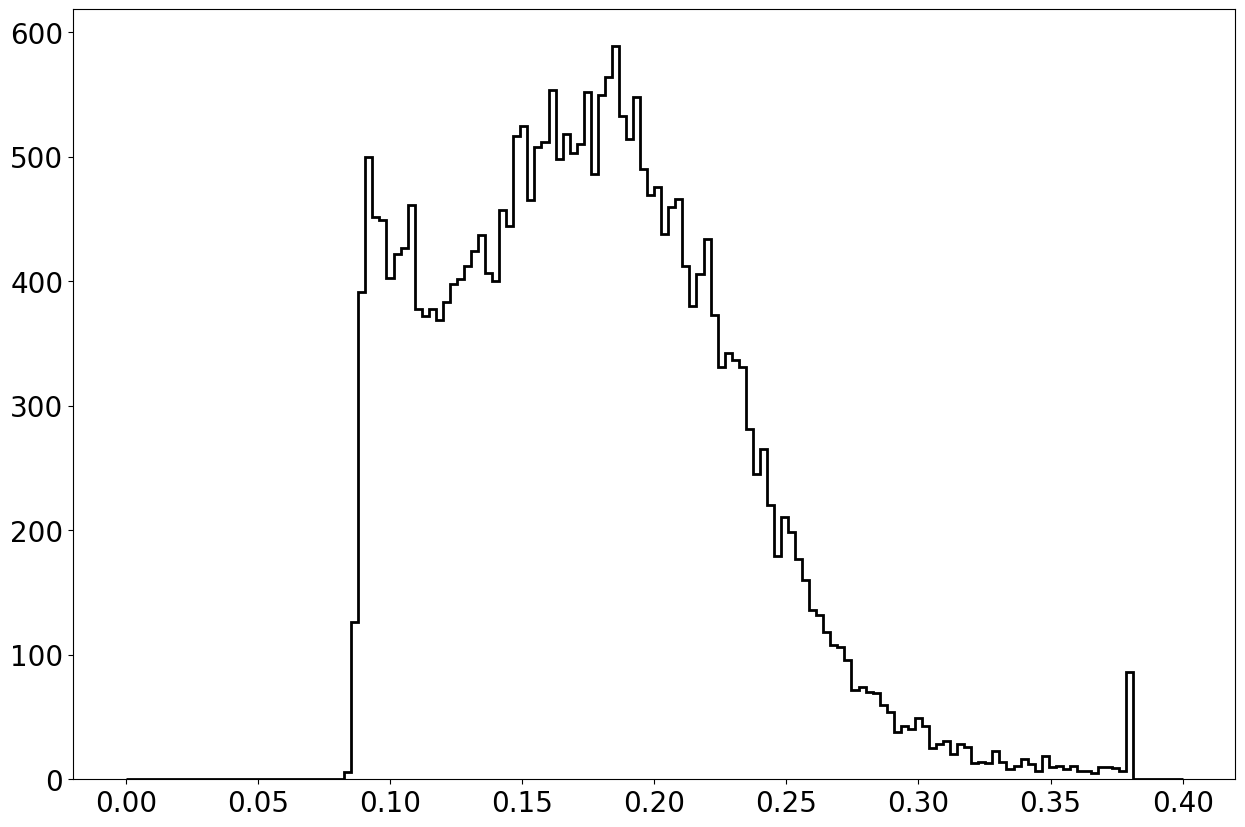

In [77]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mcp_vs)):
axs.hist(mcp1_v, bins=150, range=(0.0, 0.4), histtype='step', color='black', lw=2, label=f'MCP')
axs.hist(mm1_v, bins=150, range=(0.0, 0.2), histtype='step', color='red', lw=2, label=f'MM pad')
axs.set_yscale('log')
axs.set_xlabel('Amplitude [V]')
axs.set_title('')
axs.legend()
plt.show()

NameError: name 'mcp1_qe' is not defined

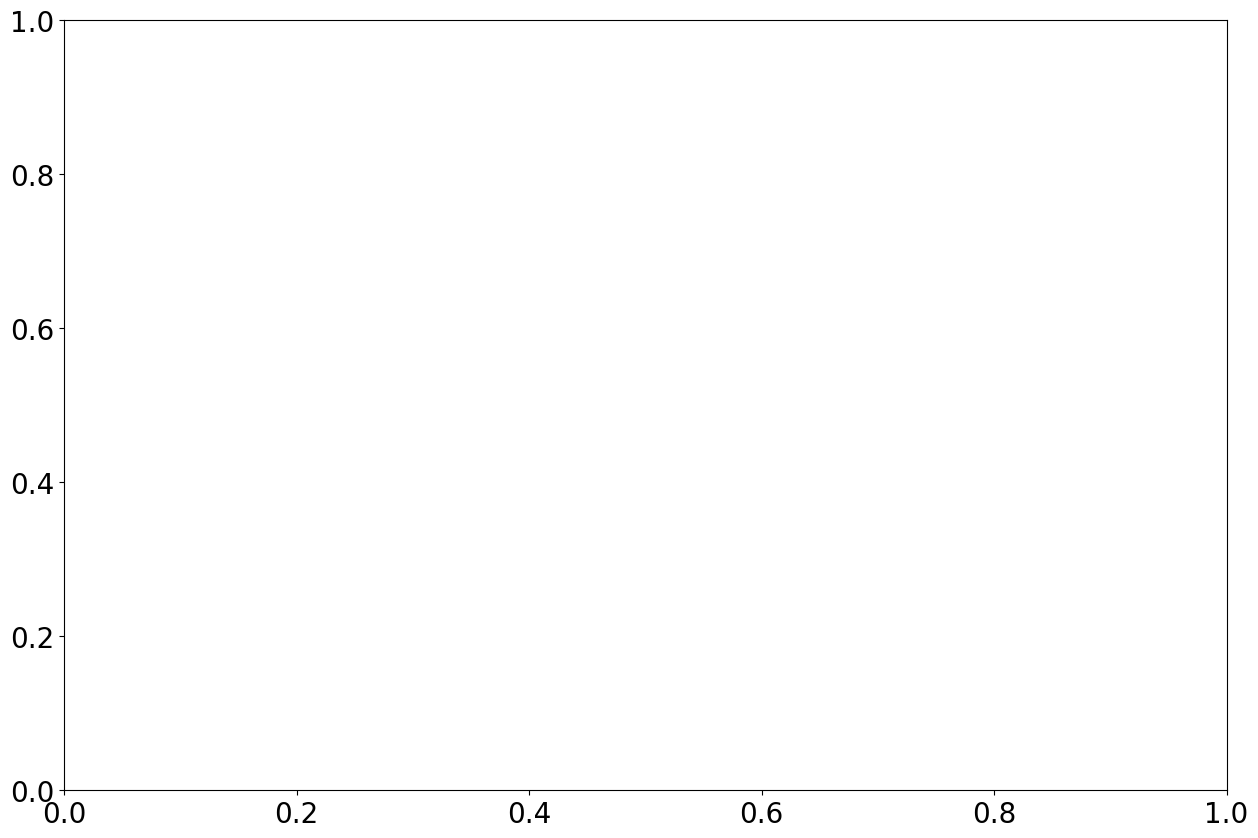

In [78]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mcp_qs)):
axs.hist(mcp1_qe, bins=100, range=(0.0, 8), histtype='step', color='black', lw=2, label=f'MCP')
axs.hist(mm1_qe, bins=100, range=(0.0, 8), histtype='step', color='red', lw=2, label=f'MM pad')
axs.set_yscale('log')
axs.set_xlabel('Charge [pC]')
axs.set_title('')
axs.legend()
plt.show()

NameError: name 'mm1_v' is not defined

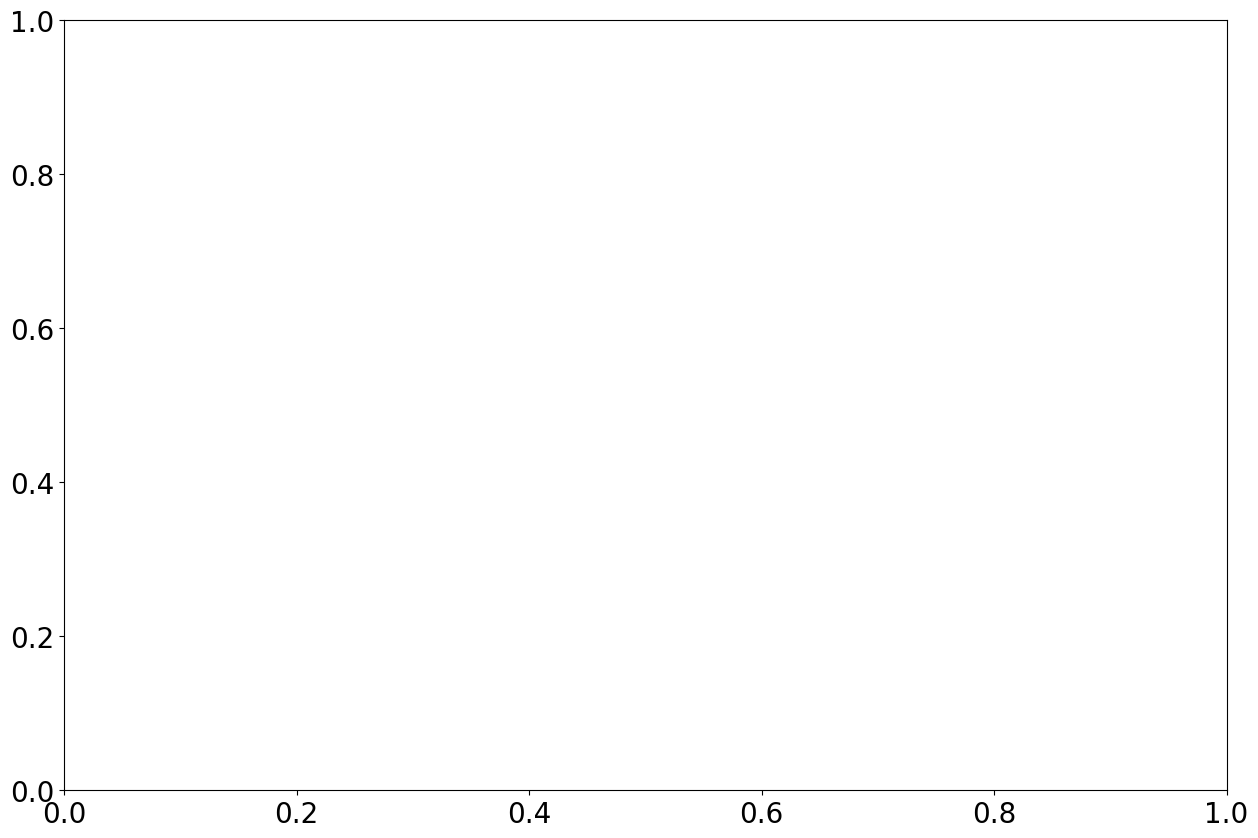

In [79]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mm_vs)):
axs.hist(mm1_v, bins=100, range=(0.0, 0.175), histtype='step', color='red', lw=2, label=f'MM Pad')
axs.hist(mcp1_v, bins=100, range=(0.0, 0.175), histtype='step', color='black', lw=2, label=f'MCP')
# axs.set_yscale('log')
axs.set_xlabel('Amplitude [V]')
axs.set_title('MM Pad')
axs.legend()
plt.show()

NameError: name 'mm1_qe' is not defined

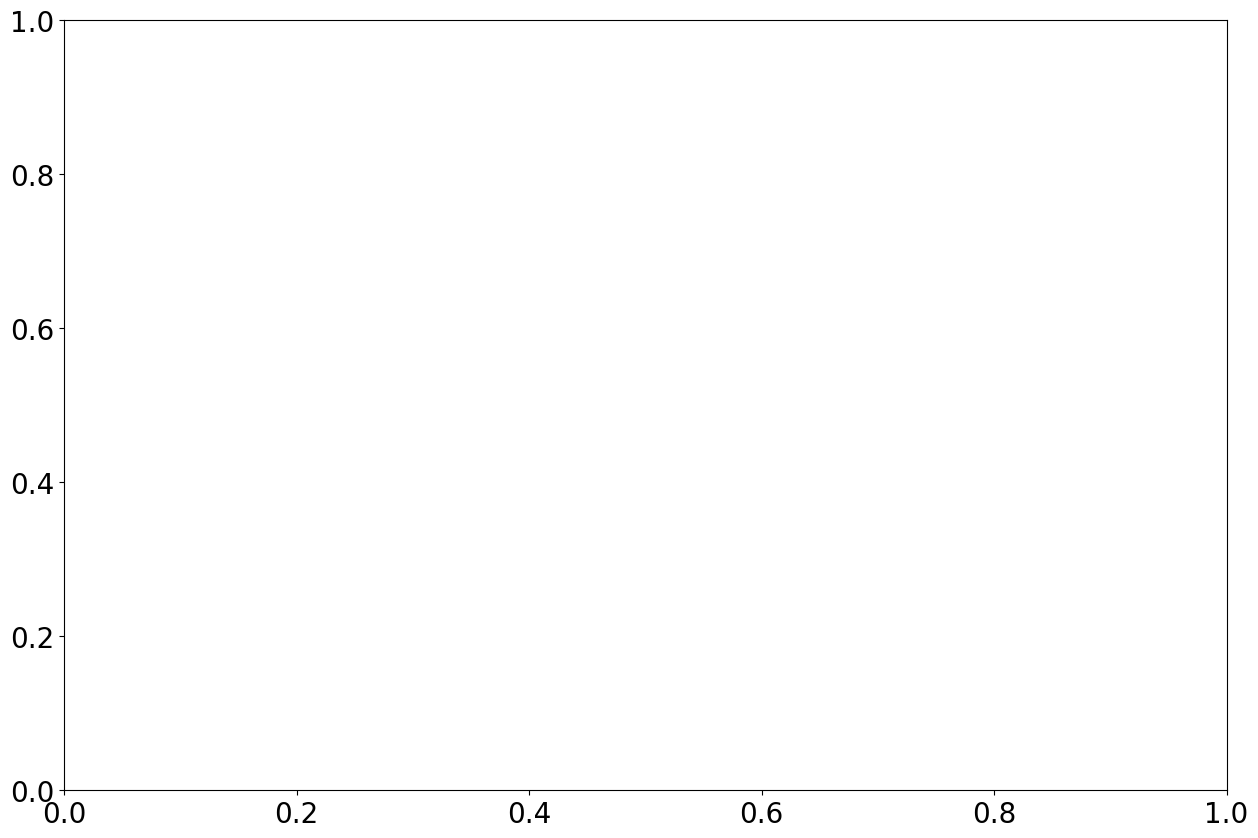

In [80]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mm_qes)):
axs.hist(mm1_qe, bins=100, range=(0.0, 10), histtype='step', color="black", lw=2, label=f'MM Pad')
axs.hist(mcp1_q, bins=100, range=(0.0, 10), histtype='step', color='red', lw=2, label=f'MCP')
axs.set_yscale('log')
axs.set_xlabel('e-Peak Charge [pC]')
axs.set_title('')
axs.legend()
plt.show()

NameError: name 'mm1_qall' is not defined

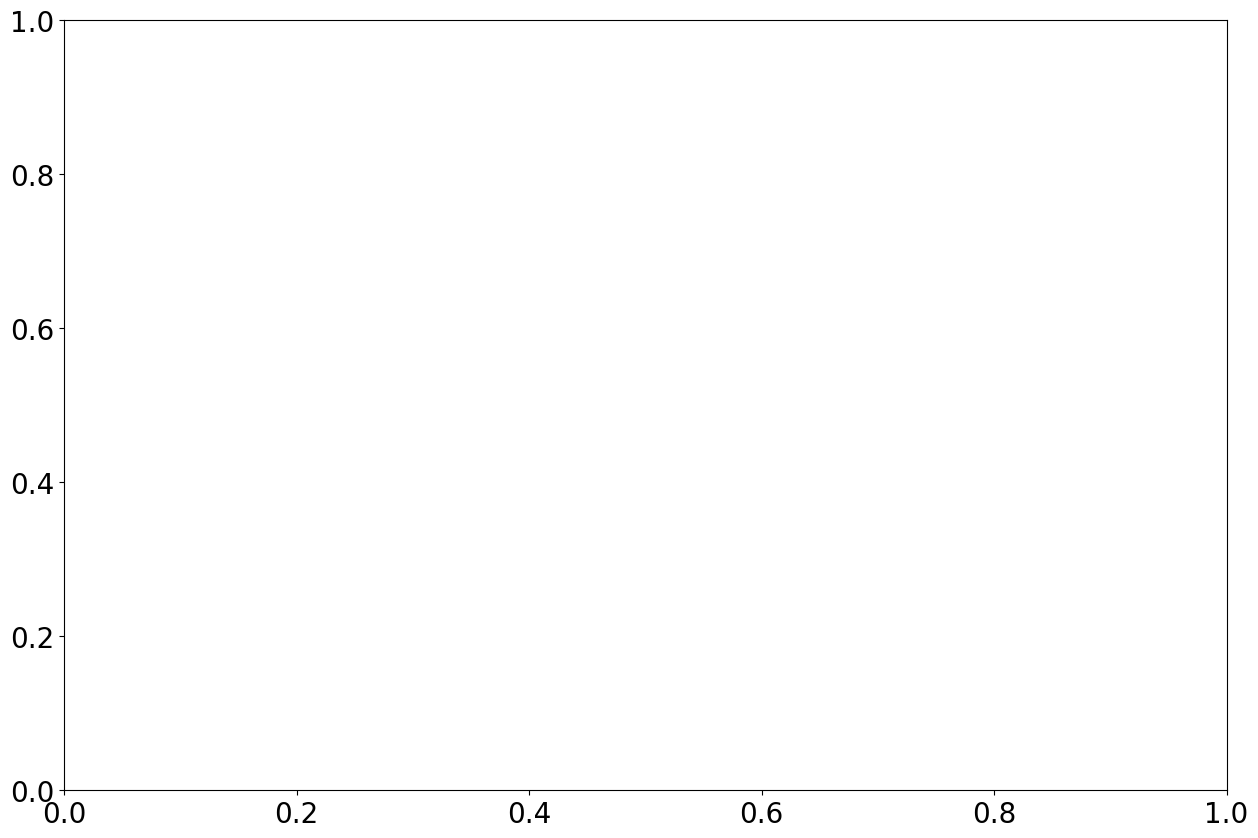

In [81]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mm_qalls)):
axs.hist(mm1_qall, bins=100, range=(0.0, 50), histtype='step', color='black', lw=2, label=f'MM Pad')
axs.hist(mcp1_qe, bins=100, range=(0.0, 10), histtype='step', color='red', lw=2, label=f'MCP')
axs.set_yscale('log')
axs.set_xlabel('Total Charge [pC]')
axs.set_title('MM Pads')
axs.legend()
plt.show()

NameError: name 'mm1_v' is not defined

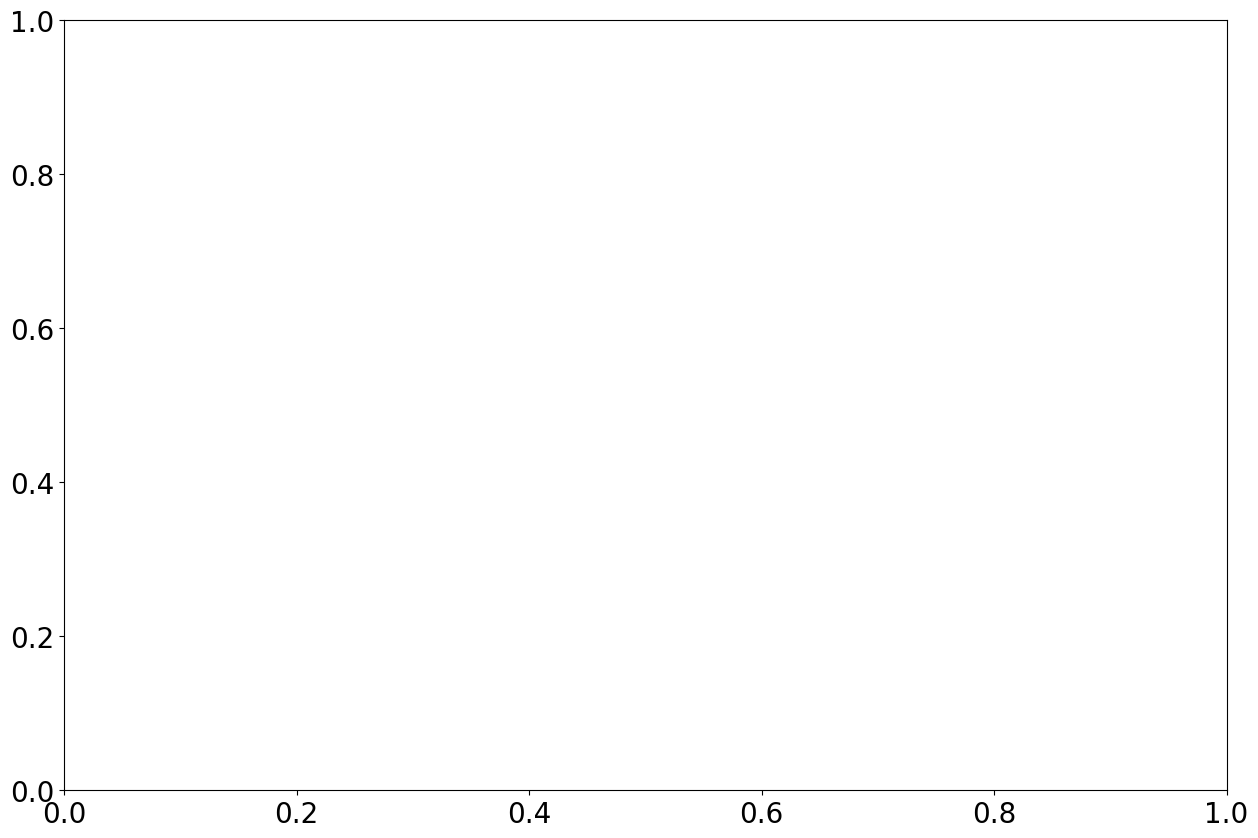

In [82]:
fig, axs = plt.subplots(figsize=(15, 10))

#for i in range(len(mm_vs)):
axs.scatter(mm1_v, mm1_qe, s=0.6, color='black', label=f'MM Pad')
    
axs.set_xlabel('Amplitude [V]')
axs.set_ylabel('e-peak Charge [pC]')
axs.set_xlim(0, 0.18)
axs.set_ylim(0, 10)
axs.legend()

plt.show()

NameError: name 'mm1_v' is not defined

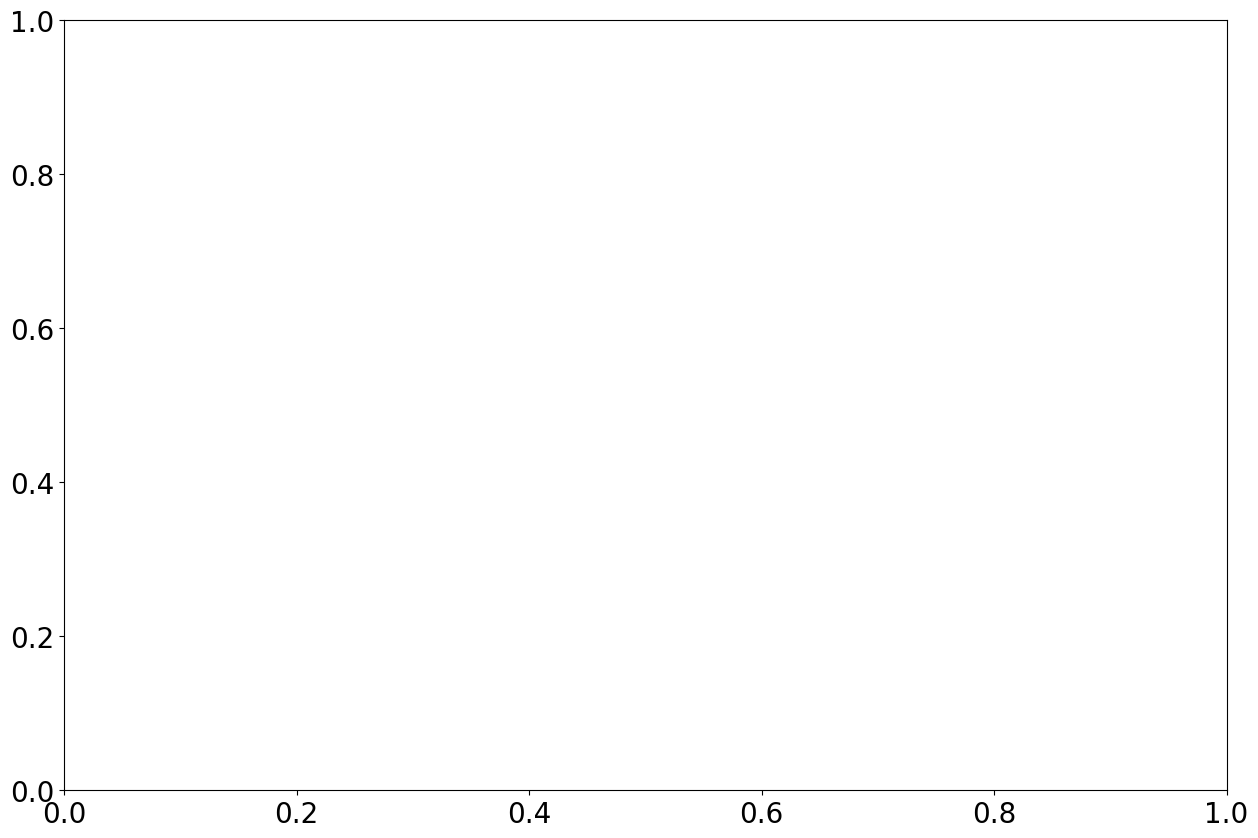

In [83]:
fig, axs = plt.subplots(figsize=(15, 10))

#for i in range(len(mm_vs)):
axs.scatter(mm1_v, mm1_qall, s=0.6, color='black', label=f'MM Pad')
    
axs.set_xlabel('Amplitude [V]')
axs.set_ylabel('Total Charge [pC]')
axs.set_xlim(0, 0.18)
axs.set_ylim(0, 50)
axs.legend()

plt.show()

In [84]:
mm_basic_cut = np.logical_and((mm1_v > 0.008),(mm1_v < 0.15))

NameError: name 'mm1_v' is not defined

In [85]:
mm_basic_cut = (data['mm1_gpeak'] > 0.008) & (data['mm1_gpeak'] < 0.15)


# Tracks

In [86]:
#ntracks = vall['ntracks']
#ntracks = vall['SRSnumber']
#xy = vall['POS0_track_hit']
#chi2 = vall['TrackChi2']

In [87]:
xy[:]

NameError: name 'xy' is not defined

In [88]:
print(xy.shape)

NameError: name 'xy' is not defined

NameError: name 'xy' is not defined

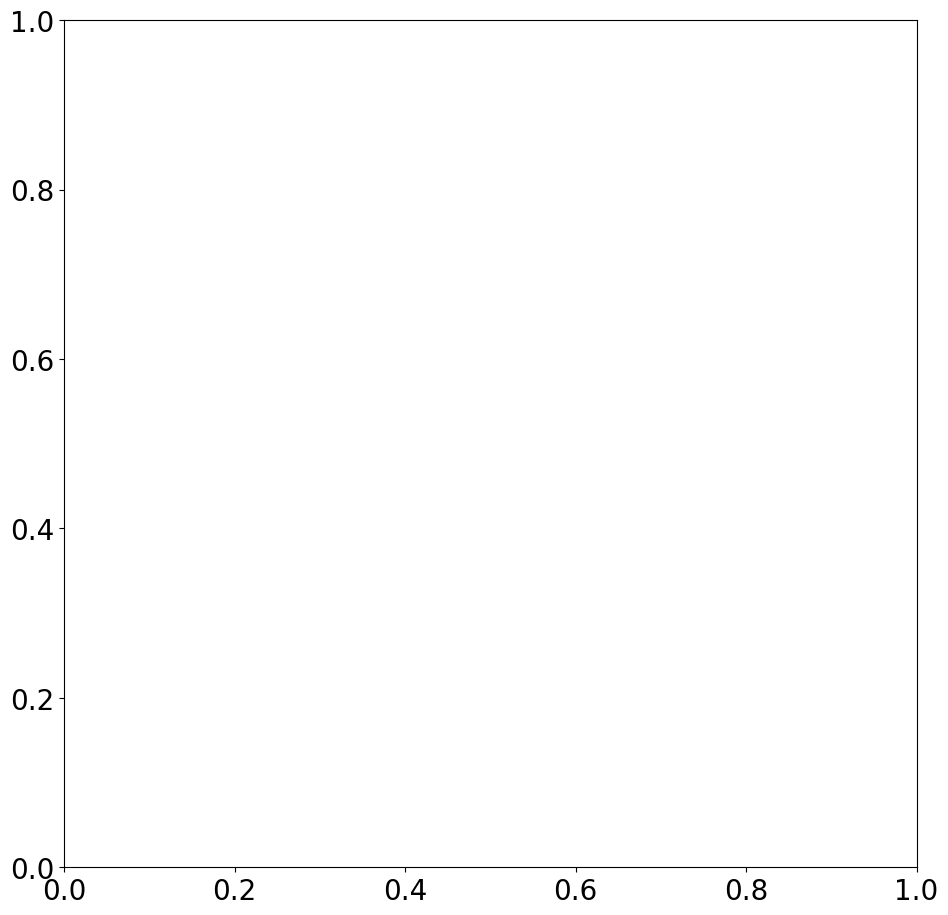

In [89]:
fig, axs = plt.subplots(figsize=(11, 11))
axs.scatter([point[0] for point in xy], [point[1] for point in xy], s=1, color='black', label='All tracks')
axs.set_xlim(0, 100)
axs.set_ylim(0, 100)
axs.legend(loc=3, markerscale=5)
axs.set_xlabel('X [mm]')
axs.set_ylabel('Y [mm]')
plt.show()

TypeError: object of type 'function' has no len()

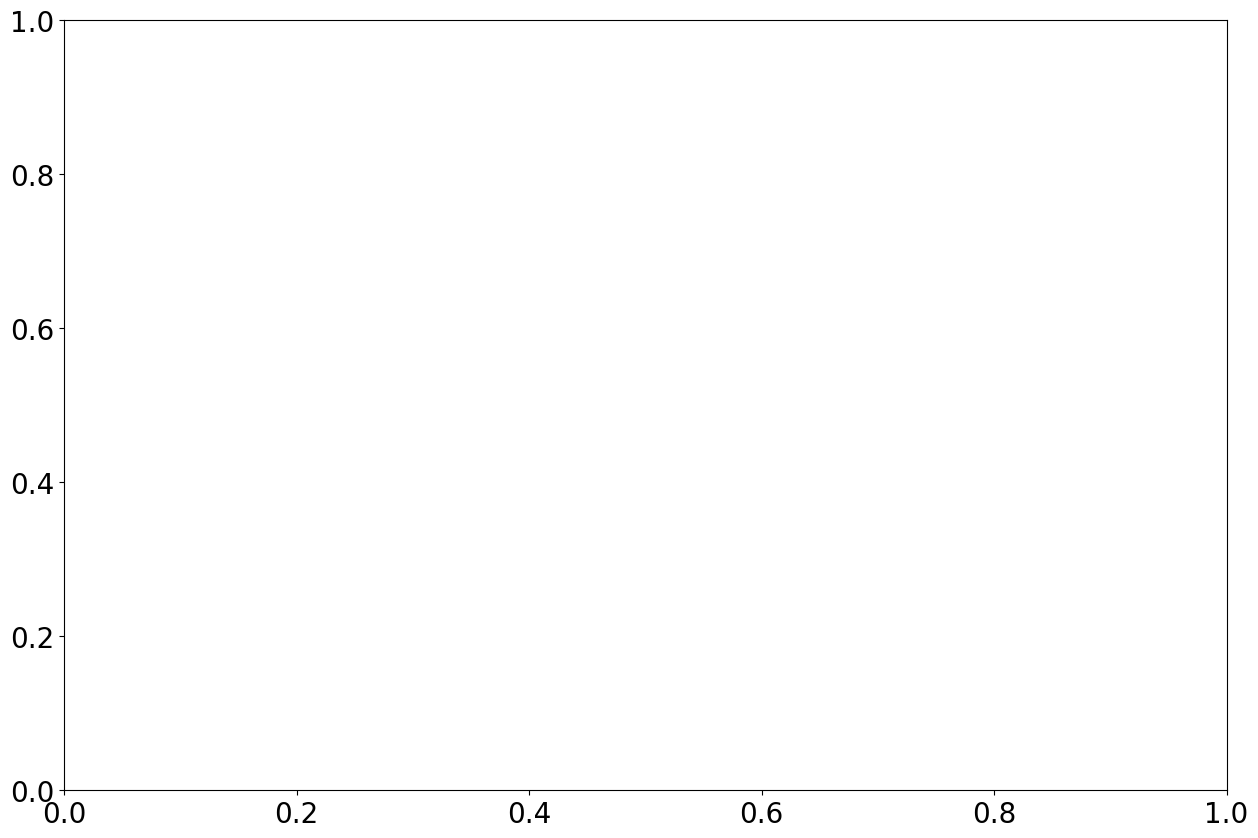

In [90]:
fig, axs = plt.subplots(figsize=(15, 10))
axs.hist(chi2, bins=100, range=(0, 50), histtype='step', color='black', lw=2)

axs.set_yscale('log')
axs.set_xlabel(r'Track $\chi^2$')
plt.show()

In [ ]:
# Define conditions for filtering
vv_thr = 0.005
qq_thr = 3.

mm_basic_cut = (data['mm1_gpeak'] > 0.008) & (data['mm1_gpeak'] < 0.15)
condition_xyc1 = mm_basic_cut & (data['mm1_gpeak'] > vv_thr) & (data['mm1_qall'] < 50)
condition_xyq1 = mm_basic_cut & (data['mm1_qall'] > qq_thr)

# Apply conditions to the DataFrame
xyc1 = data[condition_xyc1]
xyq1 = data[condition_xyq1]


In [91]:
print(xy.shape)
print(xyc1)

NameError: name 'xy' is not defined

In [92]:
#old code 
# filtered_xy = xy[xyc1]

# print("Shape of filtered_xy:", filtered_xy.shape)

# print("Contents of filtered_xy:", filtered_xy)


In [93]:
filtered_indices = xyc1.index[xyc1.all(axis=0)]  # Extract indices where all conditions are True
filtered_xy = xy[filtered_indices]  # Filter xy using the extracted indices

print("Shape of filtered_xy:", filtered_xy.shape)
print("Contents of filtered_xy:", filtered_xy)


NameError: name 'xyc1' is not defined

In [94]:
#xyc1 = np.where(np.logical_and(mm_basic_cut, mm1_v > vv_thr)*(mm1_qall < 50))
condition_xyc1 = mm_basic_cut & (data['mm1_gpeak'] > vv_thr) & (data['mm1_qall'] < 50)

print("xyc1 =", condition_xyc1)

NameError: name 'vv_thr' is not defined

In [95]:
filtered_xy = xy[xyc1]  # Filter the data based on the boolean mask xyc1

fig, axs = plt.subplots(figsize=(11, 11))

axs.scatter([point[0] for point in xy], [point[1] for point in xy], s=1, color='black', label='All tracks')

axs.scatter([point[0] for point in filtered_xy], [point[1] for point in filtered_xy], s=0.6, color=colors[0], label=f'{pnames[0]} Vpeak > {vv_thr}V')

axs.set_xlim(20, 80)

axs.set_ylim(20, 80)

axs.legend(loc=1, markerscale=10)

axs.set_xlabel('X [mm]')

axs.set_ylabel('Y [mm]')

plt.show()

NameError: name 'xy' is not defined

In [96]:
filtered_xy = xy[xyq1]  # Filter the data based on the boolean mask xyc1

fig, axs = plt.subplots(figsize=(11, 11))

axs.scatter([point[0] for point in xy], [point[1] for point in xy], s=1, color='black', label='All tracks')

axs.scatter([point[0] for point in filtered_xy], [point[1] for point in filtered_xy], s=0.6, color=colors[0], label=f'{pnames[0]} Qall > {qq_thr}pC')

axs.set_xlim(20, 80)

axs.set_ylim(20, 80)

axs.legend(loc=1, markerscale=10)

axs.set_xlabel('X [mm]')

axs.set_ylabel('Y [mm]')

plt.show()

NameError: name 'xy' is not defined

In [97]:
heatmap, yedges, xedges = np.histogram2d([point[1] for point in xy], [point[0] for point in xy], range=[[20,80],[20,80]], bins=(201, 201))

fig, axs = plt.subplots(figsize=(12, 10))
axs.set_xlabel('X [mm]')
axs.set_ylabel('Y [mm]')
c = axs.pcolormesh(xedges, yedges, heatmap, cmap='hot_r', rasterized=True)
fig.colorbar(c, ax=axs)
plt.show()

NameError: name 'xy' is not defined

In [98]:
%jsroot off
c = ROOT.TCanvas('c1', '', 1000, 1000)

hxy = ROOT.TH2D("hxy_all", '', 200, 20, 80, 200, 20, 80)
hxy.FillN(len([point[0] for point in xy]), np.array([point[0] for point in xy]), np.array([point[1] for point in xy]), 0, 1)
# hxy.FillN(len(xy[:,0]), xy[:, 0], xy[:, 1], 0, 1)

for i in range(201*201):
    if hxy.GetBinContent(i) < 4: #Tracks per bin 
        hxy.SetBinContent(i, 0)
hxy.Draw('colz')
c.Draw()

NameError: name 'xy' is not defined

In [99]:
%jsroot off
c = ROOT.TCanvas('c1', '', 2000, 1000)
c.Divide(2, 1)

hxy_mcp = ROOT.TH2D("hxy_mcp", '', 200, 20, 80, 200, 20, 80)
hxy_mcp.FillN(mcp1_q.size, np.array([point[0] for point in xy]), np.array([point[1] for point in xy]), mcp1_q, 1)


for i in range(201*201):
    if hxy.GetBinContent(i) < 4 or hxy_mcp.GetBinContent(i) < 0:
        hxy_mcp.SetBinContent(i, 0)
    else:
        hxy_mcp.SetBinContent(i, hxy_mcp.GetBinContent(i)/hxy.GetBinContent(i))


c.cd(1)
hxy_mcp.Draw('colz')
c.cd(2)
hxy_mcp.Draw('lego2z')
c.Draw()

NameError: name 'xy' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [100]:
%jsroot off
c = ROOT.TCanvas('c1', '', 2000, 1000)
c.Divide(2, 1)

hxy_mm1 = ROOT.TH2D("hxy_mm1", '', 200, 20, 80, 200, 20, 80)
hxy_mm1.FillN(mm1_qall.size, np.array([point[0] for point in xy]), np.array([point[1] for point in xy]), mm1_qall, 1)


for i in range(201*201):
    if hxy.GetBinContent(i) < 4 or hxy_mm1.GetBinContent(i) < 0:
        hxy_mm1.SetBinContent(i, 0)
    else:
        hxy_mm1.SetBinContent(i, hxy_mm1.GetBinContent(i)/hxy.GetBinContent(i))


c.cd(1)
hxy_mm1.Draw('colz')
c.cd(2)
hxy_mm1.Draw('lego2z')
c.Draw()

NameError: name 'mm1_qall' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [101]:
xyc1

NameError: name 'xyc1' is not defined

In [102]:
fxs2 = np.zeros(6)
fys2 = np.zeros(6)

In [103]:
fxs2

array([0., 0., 0., 0., 0., 0.])

In [104]:
filtered_xy # filtered_xy = xy[xyq1] tracks on this combined cut over charge 

NameError: name 'filtered_xy' is not defined

In [105]:
xlims = [[45,65], [40,70], [30,60], [30,60], [20,50], [20,50]]
ylims = [[45,65], [30,60], [45,65], [30,60], [40,70], [30,60]]

xtemps = [[point[0] for point in filtered_xy]]
ytemps = [[point[1] for point in filtered_xy]]
qtemps = [mm1_qall[xyc1]]

NameError: name 'filtered_xy' is not defined

In [106]:
xtemps

NameError: name 'xtemps' is not defined

In [107]:
#mm_basic_cut=[]
mcp_overflow = (mcp1_v > 0) * (mcp1_v <= 0.51)
chi2_cut = (chi2 <= 50)
mcp_basic_cut = mcp_overflow * chi2_cut

for i in range(NPADS):
    mm_overflow = (mm1_v[i] > 0.) * (mm1_v[i] < 0.15) * (mm1_qall[i] > 0) * (mm1_qall[i] < 30)
    qall_line = (mm1_qall[i] > 1. * mm1_v[i])

    # Make sure mcp_basic_cut has the same size as filtered_xy
    cut = np.logical_and(mm_overflow * mcp_basic_cut[:len(filtered_xy)], qall_line)
    #cut = np.logical_and(mm_overflow * mcp_basic_cut, qall_line)
    mm_basic_cut = mm_basic_cut[:len(cut)] * cut

TypeError: '<=' not supported between instances of 'function' and 'int'

In [108]:
xy0_data = [point[0] for point in filtered_xy]
xy1_data = [point[1] for point in filtered_xy]

# Convert the lists to NumPy arrays
xy0_data = np.array(xy0_data)
xy1_data = np.array(xy1_data)

# Create a boolean mask for filtering
mm_basic_mask = np.array(mm_basic_cut).all(axis=0)

# Use the mask to filter xy0_data and xy1_data
xy0_filtered_mcp = xy0_data[mm_basic_mask]
xy1_filtered_mcp = xy1_data[mm_basic_mask]

NameError: name 'filtered_xy' is not defined

In [109]:
# Create boolean masks
mask_mcp_basic = mcp_basic_cut[:len(filtered_xy)]

# Filter the data using the boolean masks
filtered_x = np.array(xy0_data)
filtered_y = np.array(xy1_data)
filtered_x = filtered_x[mask_mcp_basic]
filtered_y = filtered_y[mask_mcp_basic]

# Now create the histogram
hist_tracks, yedges, xedges = np.histogram2d(filtered_y, filtered_x, range=[[20, 80], [20, 80]], bins=200)

# Apply threshold to the histogram
hist_tracks = np.where(hist_tracks < 4, 0, hist_tracks)

# Create the plot
fig, axs = plt.subplots(figsize=(12, 10))
axs.set_xlabel('X [mm]')
axs.set_ylabel('Y [mm]')
c = axs.pcolormesh(xedges, yedges, hist_tracks, cmap='hot_r', rasterized=True)
fig.colorbar(c, ax=axs)
plt.show()

NameError: name 'filtered_xy' is not defined

In [110]:
c = ROOT.TCanvas('cc', '', 1000, 800)
xytrks = ROOT.TH2D("xytrks",'All tracks multiplicity',200,20,80,200,20,80)

xytrks.GetXaxis().SetTitle("X [mm]")
xytrks.GetYaxis().SetTitle("Y [mm]")

n = len(filtered_y)
xytrks.FillN(n,filtered_x,filtered_y, 0, 1)
xytrks.Draw('colz')
c.Draw()

NameError: name 'filtered_y' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc
Warning in <TROOT::Append>: Replacing existing TH1: xytrks (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc
Warning in <TROOT::Append>: Replacing existing TH1: xytrks (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc
Warning in <TROOT::Append>: Replacing existing TH1: xytrks (Potential memory leak).


In [111]:
#root canvas for display
c = ROOT.TCanvas()
ROOT.gStyle.SetOptFit(1111)
#tracks multiplicity
xytrks = ROOT.TH2F("xytrks",f' All tracks multiplicity',100,20,70,100,20,70)

xytrks.GetXaxis().SetTitle("x [mm]")
xytrks.GetYaxis().SetTitle("y [mm]")

n = len(filtered_y)
x = filtered_x
y = filtered_y
w = np.ones(n) # weights (w) to ones for all data points, you can create an array of ones with the same length as your data and assign it to w like this:
xytrks.FillN(n,x,y,w)
#clear out areas with low number of trks (not enough statistics)
for i in range(xytrks.GetNbinsX()+1):
    for j in range(xytrks.GetNbinsY()+1):
        if xytrks.GetBinContent(i,j)<2:
            xytrks.SetBinContent(i,j,0)

xytrks.SetTitle(f'xy tracks with multiplicity >2')
xytrks.Draw("colz")
c.Draw()

NameError: name 'filtered_y' is not defined

Warning in <TROOT::Append>: Replacing existing TH1: xytrks (Potential memory leak).


In [112]:
filtered_x

NameError: name 'filtered_x' is not defined

In [113]:
# we find the pads here!
xytrksW_mm = [] #weighted histos
pad_hist = []

In [114]:
%jsroot off
c = ROOT.TCanvas('c1', '', 800, 800)
#xytrks = ROOT.TH2D("xytrks",'All tracks multiplicity',200,20,80,200,20,80)
h1 = ROOT.TH2F(f'xytrksWeighted',f' xy tracks weighted by PAD  e-peak row charge',100,20,70,100,20,70)
for index in range(1):
    pad = index +1
    
    h1.GetXaxis().SetTitle("x [mm]")
    h1.GetYaxis().SetTitle("y [mm]")

    n = len(filtered_xy)
    x = filtered_x[mm_basic_cut[index]]
    y = filtered_y[mm_basic_cut[index]]
    #w = mm1_qe[mm_basic_cut[index]]
    w = np.ones(n)
    h1.FillN(n,x,y,w)
    
    h1.Divide(xytrks)
    
    xytrksW_mm.append(h1)
    h2 = h1.Clone()
    h2.SetName(f'pad_hist')
    h2.SetTitle(f' PAD')
    for i in range(h2.GetNbinsX()+1):
        for j in range(h2.GetNbinsY()+1):
            if h2.GetBinContent(i,j)<2.:
                h2.SetBinContent(i,j,0)
    
    pad_hist.append(h2)
    
# Create the plot
for i in range(1):
    c.cd(i+1)
    xytrksW_mm[i].Draw("lego2z")#"lego2z/colz"
c.Draw()

NameError: name 'filtered_xy' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [115]:
x

NameError: name 'x' is not defined

In [116]:
#distance_xy = 9.82/2 in mm half of the distance of the pad to select tracks passing from this area 
distance_xy = 0

centers_s = sym_to_beam((centers[0,:] - center[0],centers[1,:] - center[1]), theta)
x_s, y_s = sym_to_beam([(point[0] - center[0], point[1] - center[1]) for point in xy], theta)

#x_s, y_s = sym_to_beam([point[0] - center[0] for point in xy], [point[1] - center[1] for point in xy], theta)
#x_s, y_s = sym_to_beam([(point[0] - center[0], point[1] - center[1]) for point in xy], theta)

#cross2_s = np.array(sym_to_beam((cross2[:,0] - center[0],cross2[:,1] -center[1]), theta)).T

NameError: name 'xy' is not defined

In [117]:
centers_s[0]

array([ 6.50857202, 12.68010922])

In [118]:
centers_s

(array([ 6.50857202, 12.68010922]), array([6.49193022, 2.5749303 ]))

In [119]:
center

array([48.67, 44.68])

In [120]:
centers[0,:] #x values 

array([55.14222241, 55.1981701 , 45.12237861, 45.1783263 , 35.1025348 ,
       35.15848249])

In [121]:
centers[1,:] #y values 

array([57.34553426, 47.32569045, 57.28958657, 47.26974277, 57.23363888,
       47.21379508])

In [122]:
#def transfo(x,y,x0,y0, theta):
    #dx=x-x0
    #dy=y-y0
    #return (dx*np.cos(theta)+dy*np.sin(theta), -dx*np.sin(theta)+dy*np.cos(theta))
#xy_pad_cuts = []
for i in range(NPADS):
    temp_cut = np.logical_and(np.logical_and(np.abs(x_s-centers_s[0][i]) < distance_xy, np.abs(y_s-centers_s[1][i]) < distance_xy), mm_cut[i])
    #temp_cut = np.logical_and(np.logical_and(np.abs(x_s-centers_s[0][i]), np.abs(y_s-centers_s[1][i])), mm_cut[i])
    #temp_cut = mm_cut[i]    
    xy_pad_cuts.append(temp_cut)
# a1,a2 = transfo(xy[:,0],xy[:,1],center[0],center[1],theta)

# square1 = np.logical_and(np.abs(a1-centers[0,i]) < distance_xy, np.abs(xy[:, 1]-centers[1,i]) < distance_xy)

NameError: name 'x_s' is not defined

NameError: name 'x_s' is not defined

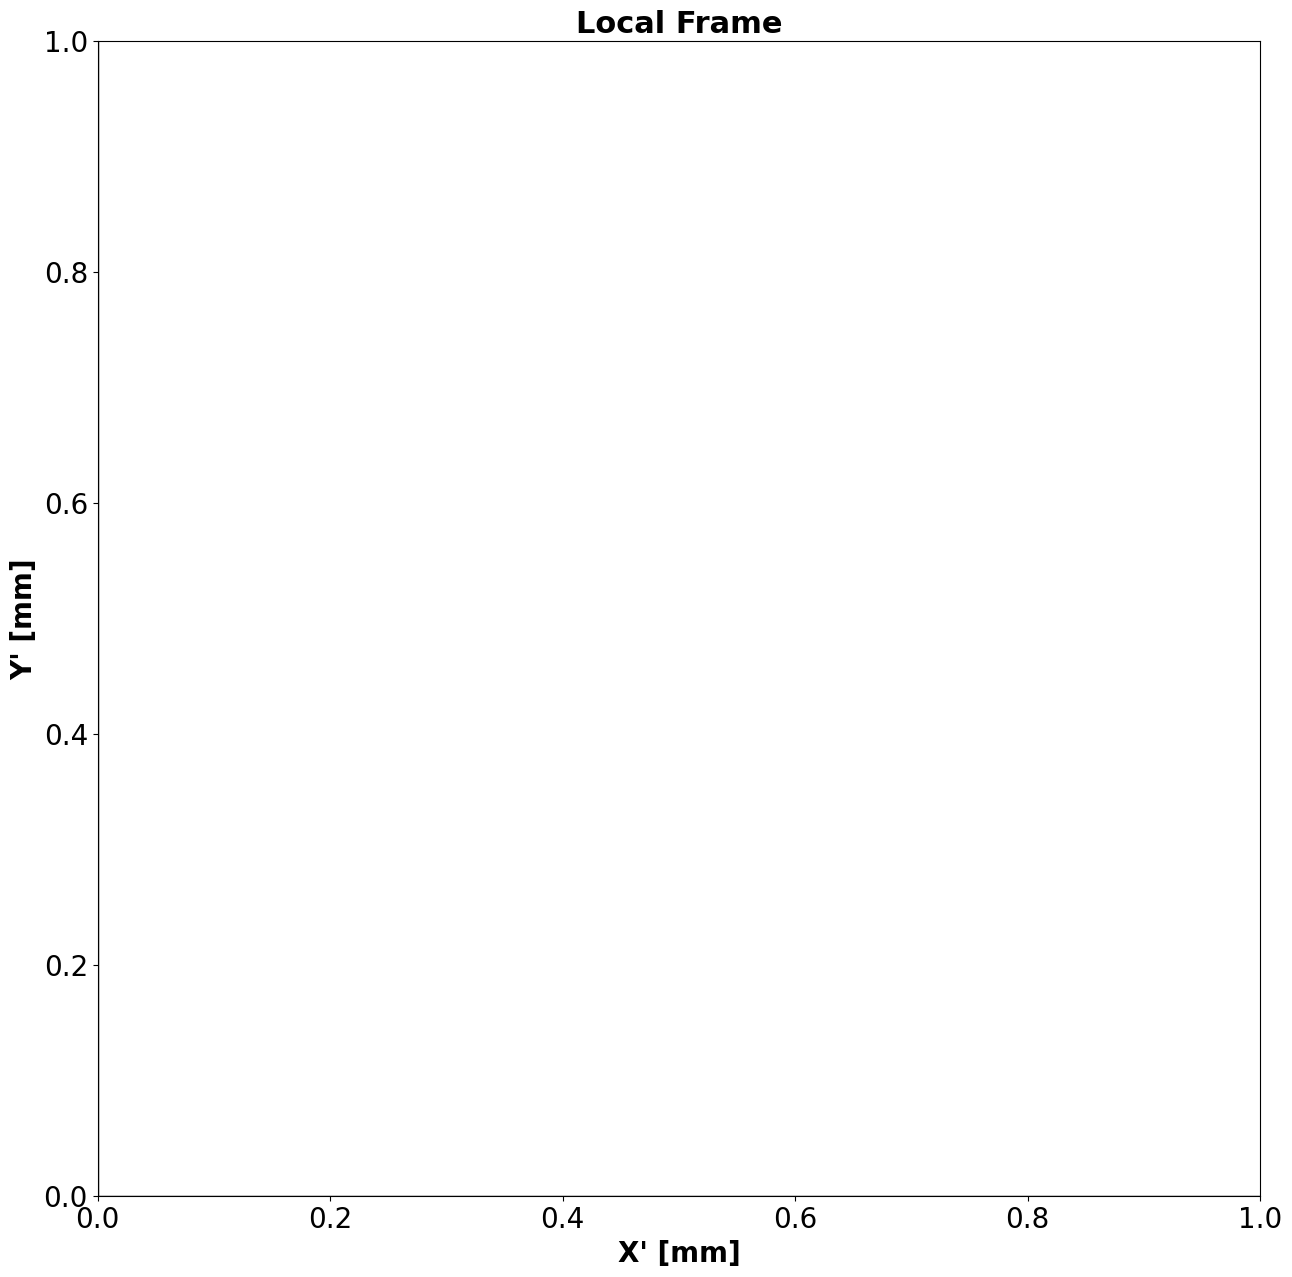

In [123]:
fig, axs = plt.subplots(figsize=(15, 15))

axs.set_title('Local Frame')
axs.set_xlabel('X\' [mm]')
axs.set_ylabel('Y\' [mm]')

axs.axhline(0, lw=1, color='black')
axs.axvline(0, lw=1, color='black')

for i in range(NPADS):
    axs.scatter(x_s[xy_pad_cuts[i]], y_s[xy_pad_cuts[i]], s=0.8, color=colors[i], label=f'{pnames[i]}')

for i in range(NPADS):
    axs.scatter(centers_s[0][i], centers_s[1][i], color='black', s=50)
#axs.scatter(0, 0, color='black', s=100, marker='+')
#axs.scatter(center[0], center[1], color='black', s=50, marker='+')
#axs.scatter(cross2_s[0,0], cross2_s[0,1], color='black', s=50, marker='^', label='Cross')
#axs.scatter(cross2_s[1,0], cross2_s[1,1], color='black', s=50, marker='^')

#box2 = np.array([[centers_s[0][0],centers_s[1][0]]])
#box1 = np.array([[centers_s[0][2],centers_s[1][2]]])

# axs.plot(box1[:,0], box1[:,1], '--o', lw=5, ms=10, color='black')
# axs.plot(box2[:,0], box2[:,1], '-o', lw=5, ms=10, color='black')
# axs.set_xlim(-15, 15)
# axs.set_ylim(-10, 10)

leg = axs.legend(loc=2, markerscale=10)

#leg.legendHandles[6].set_sizes([])

plt.show()

In [124]:
tranges = [
    [-8000,-7300],
    [-12700, -12000],
    [-12700, -12000],
    [-8200,-7000],
    [-2700, 1000],
    [-12700, 10000],
    [-9000,-8200],
]

In [125]:
ROOT.gStyle.SetOptFit(1111)
c = ROOT.TCanvas("cc", '', 1200, 1800)
#c.Divide(2, 4)

ht1 = ROOT.TH1D('ht1', f'{pnames[0]};T [ps]', 200, -11500,-11000)
ht1.FillN(np.count_nonzero(mm1_cut), 1e3*dt1[mm1_cut], 0, 1)

ht1.Draw()
ht1.Fit('gaus')

c.Draw()

NameError: name 'mm1_cut' is not defined

In [126]:
def gaus2(x, pars):
    a = pars[0]
    mu = pars[1]
    sigma1 = pars[2]
    b = pars[3]
    sigma2 = pars[4]
    return a*ROOT.TMath.Gaus(x[0], mu, sigma1) + b*ROOT.TMath.Gaus(x[0],mu,sigma2)

In [127]:
c1_order = np.array([0], dtype=np.int32)
print([pnames[i] for i in c1_order])

['Pad 1']


In [128]:
distance_xy = 0
xy_pad1c = np.logical_and(np.logical_and(np.abs(x_s-centers_s[0][0]) < distance_xy, np.abs(y_s-centers_s[1][0]) < distance_xy), mm_cut[0])
xyc1_inpad1 = xy_pad1c
xy_pad5c = np.logical_and(np.logical_and(np.abs(x_s-centers_s[0][0]) < distance_xy, np.abs(y_s-centers_s[1][0]) < distance_xy), mm_cut[0])
xyc1_inpad5 = xy_pad5c


NameError: name 'x_s' is not defined

In [129]:
qlow = 0.5
qup = 50

#nppe = 500
nppe = 500


vl5in5c1, vu5in5c1, mdt5in5c1, sdt5in5c1, emdt5in5c1, esdt5in5c1 = fff(mm1_qall[xyc1_inpad5], dt1[xyc1_inpad5], qlow, qup, nppe, False, trange=[tranges[4][0], tranges[4][1]])


NameError: name 'mm1_qall' is not defined

In [130]:
xxs55c1 = (vl5in5c1+vu5in5c1)*0.5
exs55c1 = (vl5in5c1-vu5in5c1)*0.5

NameError: name 'vl5in5c1' is not defined

In [131]:
show_ranges = [
    [-14000, -12000],
    [-16500, -14000],
    [-13000, -12000],
    [-16400, -14000],
]

In [132]:
pars5in5c1 = sat_fit(xxs55c1, mdt5in5c1, exs55c1, emdt5in5c1, iistart=0, iistop=None, xl=0.5, xu=80, pars=[-0.1, 1.0, -1, 0.5, 13500.0])

NameError: name 'xxs55c1' is not defined

NameError: name 'xxs55c1' is not defined

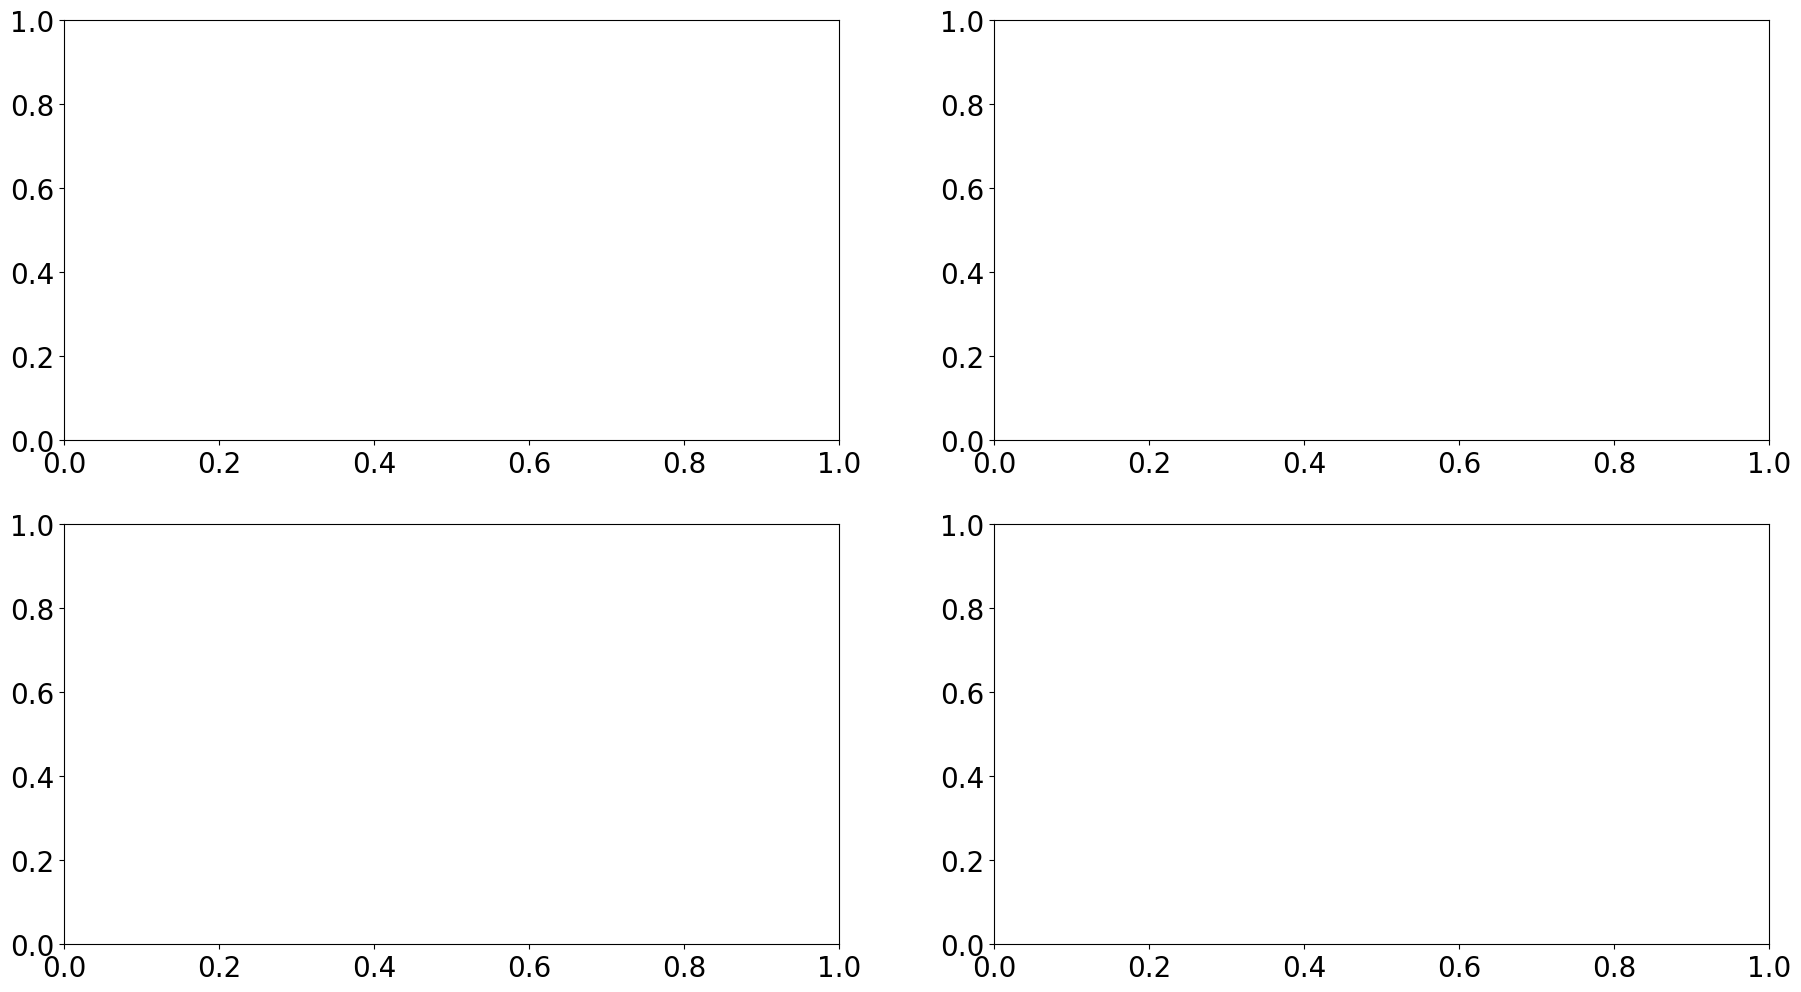

In [133]:
#same
fig, axs = plt.subplots(2, 2, figsize=(22, 12))
iistart, iistop = 0, None
axs = axs.ravel()

a = np.linspace(5, 80, 300)


axs[0].errorbar(xxs55c1[iistart:iistop], mdt5in5c1[iistart:iistop], xerr=exs55c1[iistart:iistop], yerr=emdt5in5c1[iistart:iistop], fmt='o', ms=7, color='black', label=f'{pnames[4]}, hit {pnames[4]}')
axs[0].plot(a, expo2_np(a, pars5in5c1), color=pcolors[0])

for i in range(4):
    axs[i].grid()
    axs[i].set_xlim(None, 80)
#     axs[i].set_ylim(0, 1000)
#     axs[i].set_ylim(show_ranges[i][0], show_ranges[i][1])
    axs[i].set_xlabel('Total Charge [pC]')
    axs[i].set_ylabel('SAT [ps]')
    axs[i].legend(loc=1)

# axs[0].set_xlim(0, 5)
plt.show()

In [134]:
# vv_thr = 0.02

# xyc1 = np.where(np.logical_and(mm1_cut, mm1_v > vv_thr)*(mm1_qall < 200))


# qq_thr = 5

# xyq1 = np.where(np.logical_and(mm1_cut, mm1_qall > qq_thr))

qq_thr = 7

# xyq1 = np.where(np.logical_and(mm1_cut, mm1_qall > qq_thr))
# xyq2 = np.where(np.logical_and(mm2_cut, mm2_qall > qq_thr))
# xyq3 = np.where(np.logical_and(mm3_cut, mm3_qall > qq_thr))
# xyq4 = np.where(np.logical_and(mm4_cut, mm4_qall > qq_thr))
# xyq5 = np.where(np.logical_and(mm5_cut, mm5_qall > qq_thr))
# xyq6 = np.where(np.logical_and(mm6_cut, mm6_qall > qq_thr))
# xyq7 = np.where(np.logical_and(mm7_cut, mm7_qall > qq_thr))

xyq1 = np.where(np.logical_and(cc1, mm1_qall > qq_thr))

NameError: name 'cc1' is not defined

In [135]:
#ROOT.gStyle.SetOptFit(1111)
#c = ROOT.TCanvas("cc", '', 1200, 1800)
#c.Divide(2, 4)

#ht1 = ROOT.TH1D('ht1', f'{pnames[0]};T [ps]', 100, -8000,-7300)
#ht1.FillN(np.count_nonzero(xyq1), 1e3*dt1[xyq1], 0, 1)

#ht2 = ROOT.TH1D('ht2', f'{pnames[1]};T [ps]', 100, -12700, -12000)
#ht2.FillN(np.count_nonzero(xyq2), 1e3*dt2[xyq2], 0, 1)

#ht3 = ROOT.TH1D('ht3', f'{pnames[2]};T [ps]', 100, -12700, -12000)
#ht3.FillN(np.count_nonzero(xyq3), 1e3*dt3[xyq3], 0, 1)

#ht4 = ROOT.TH1D('ht4', f'{pnames[3]};T [ps]', 100, -8200,-7000)
#ht4.FillN(np.count_nonzero(xyq4), 1e3*dt4[xyq4], 0, 1)

#ht5 = ROOT.TH1D('ht5', f'{pnames[4]};T [ps]', 100, -1500, -700)
#ht5.FillN(np.count_nonzero(xyq5), 1e3*dt5[xyq5], 0, 1)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABKwAAAbsCAIAAAC1ApxbAAAABmJLR0QAAAAAAAD5Q7t/AAAgAElEQVR4nOzda7KqyAIuWrix+gV2pk4zwGbs6gzYMu6PPCtPFi9RUcEcIyoq5lIeqROc+ZmvchiGAgAAgDz8f98uAAAAAJ8jBAIAAGRECAQAAMiIEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAyIgQCAABkRAgEAADIiBAIAACQESEQAAAgI0IgAABARoRAAACAjAiBAAAAGRECAQAAMiIEAgAAZEQIBAAAyIgQCAAAkBEhEAAAICNCIAAAQEaEQAAAgIwIgQAAABkRAgEAADIiBAIAAGRECAQAAMiIEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAyIgQCAABkRAgEAADIiBAIAACQESEQAAAgI3++XQAAfkff99s3ruv6XeX4iPhiz/5CAMiNEAjAPuq6vt1uT+xYVVVd123b7l2iN2rb9nq9hp+rqnoo/QLAd+kOCsCX3W636/ValuW5cuDH1HVdlmVZlpocAdiFEAjAUYQo+O1SHM5z7asAsEQIBOBY5MCUjqYA7E4IBOAthnu6rmuapqqq6b76PUa6yAKwOxPDAPAddV2HsNf3/eVySZ/SATJo29ZbAcDutAQC8GV1XQ/DMHpQC1hd13ECUgDYkRAIwCE0TZP+M8P80/d927Zt24bpQLUBAvAmuoMCcAjpynsZMh0OAB8jBAJwbmH+zHQWzTja8MXDxmPuckAAOAghEIBTCp0nZ/tMxhbFpmkeHVs42yAZHqmqKvTVfKK0AHAcQiAA51PX9ZYhc9fr9Xq9boyC00lKR2632+VyeSJYbtF13ezj60UCgCcIgQCczKPD50I73npyu5sAR0fbnQZGAD5GCATgEDY2r82Gpaqq4uN9308bCa/X68rxlxJgPOzomDlPYAPADxACATiEUbIarRgRjQLeUufMaa4Lqy/MHnOaAGcPm/n8pQD8DCEQgO+b9vCcbfEbBbOu65Z6UYYF6NPDptOHrhxz5bBhVhiD9AA4O4vFA/AdYQ2GsDD66Km0e+dol/Sfd8fRVVUVf16aSGbUuLcSLMMZl5ooAeAstAQC8BavrH6+1GqXBrktYezuJKKjEy2Fz5ROoQCcnRAIwLEsLZZQFMUwDOkC7q+faxQCN05O0zSNHAjAeQmBABxFVVVLbYDRQ9nv7tEe7V8aaAwE4NSMCQTg+6qq6rrubmZ7SNu2dxeUTzdIBxACwA/TEgjAW6z06kztuEh6/1exPA3MXiWpquqJUwDAEQiBALzFjuluSdu2s0vDP+cDBQaAIxACATiZ6ULwTx/n6X3vzjsKAIdlTCAAZ7JlufaqqpqmGYZhfRkJTX8A5ElLIACnsdT+1jRNSHSv5Lqwcv32jZ8+EQB8lxAIwDlMh/9tWVICABjRHRSAcxit5L77khIPHc2AQADOSwgE4BxGa/rtMqIvXRtQrgMgE0IgAOezMQHebdwbHWfU2Lhk42YAcExCIAA/627j3ijOXa/XLYfduBkAHJMQCMD5bBm/t7G1MO0RumUvC0sAcHZCIADnc7eJb/ti7qPGwNvtttLb0xrxAPwAIRCAcxit/F6W5Wx7YN/3ZVluj2p1XY+OfL1epwd/9LAAcFjlMAzfLgMAv2DUSvaOvy9lWU4fXJnhs6qq0SMh703b+maPvKLrusvlEs/yvuUK04JZFxGAXVgsHoDTSKNXtNQ613VdXdejdBfmdJmGwGEYtufAcOSNGwPA0egOCsBp1HXddd3dzaqqGoYh5LRRV88VwzBs2TgeGQBOSndQAM6nbdu+76dtgE3TTFv52rYdLeqw/rdvun1RFFVVtW0r/gHwA4RAAACAjOgOCgAAkBEhEAAAICNCIAAAQEaEQAAAgIwIgQAAABkRAgEAADIiBAIAAGRECAQAAMiIEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAyIgQCAABkRAgEAADIiBAIAACQESEQAAAgI0IgAABARoRAAACAjAiBAAAAGRECAQAAMiIEAgAAZEQIBAAAyIgQCAAAkBEhEAAAICNCIAAAQEaEQAAAgIwIgQAAABkRAgEAADIiBAIAAGRECAQAAMiIEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZ+fPtAgAA3FGW5beLAHAIwzC8fhAhEAA4gV3qPQCnttc3YrqDAgAAZEQIBAAAyIgQCAAAkBEhEAAAICNCIAAAQEaEQAAAgIwIgQAAABkRAgEAADIiBAIAAGRECAQAAMiIEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAyIgQCAABkRAgEAADIiBAIAACQESEQAAAgI0IgAABARoRAAAB+U13XZVmWZVnX9bfLAgciBAIA8Jtut9vohy9q2zYk0m8XBIpyGIZvlwEAYE1ZqrHwjDRxff0SioX5ekk4r70+DP+8fggAAPh5r0TKvu93Lg28wPdqAMDRaQnkOfu2BL5ytEO1SXJee30YGhMIAABvZFoajkYIBACAtwiTwRxhWhpIGRMIAAC7adv2er1+uxSwRg97AODojAnkOesj8cJkLdv7am4c13d3EQgXM08zOygAADxsqaWuaZq2baePz6bE+GBd17N7wZH5Xg0AODotgTxn2nb3RDPd+i5VVY2Wf5hdDeJyuaycAjbSEggAAA+4mwCLPSrZ5gLl+IRAAAB+X0yAVVW1bRuiWt/3fd+Peof2fZ8GuaZpwg/pZvFBkY8z0rkCADg63UF5zrTpb2ngX7rltIfndBuLxfMVFosHAIAHLCXAoii6ros/W9aPn+d7NQDg6LQE8pxRS+D6VXS3sU5LIF+nJRAAALaKo/gAIRAAgN9nBheIdK4AAI5Od1Ce81AnTN1BOT7dQQEAAHiYEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAyIgQCAABkRAgEAADIiBAIAACQESEQAAAgI0IgAAA8pq7r/q9vlwUeVg7D8O0yAACsKUs1Fp5RlmX8+e4ldHfjuq5vt9vowaqqtuTAh0oCS/b6MNQSCAAA97Vt++0iwD6EQAAAftOQeH3juq67rquqavTg7iWBd9O5AgA4Ot1BAQrdQQEAAHiCEAgAAJARIRAAACAjQiAAAEBG/ny7AFlIV4YBAAD4IiHwQ8xpBgBP83UqwI50BwUAAMiIEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAyIgQCAABkRAgEAADIiBAIAACQESEQAAAgI3++XYBclGW5ccthGN5aEgAAIGdC4IeIdgAAwBHoDgoAAJARLYEAwAlsH1gBwDohEAA4AQMrAPb6Okx3UAAAgIwIgQAAABkRAgEAADIiBAIAAGRECAQAAMiIEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAyIgQCAABkRAgEAADIiBAIAACQESEQAAAgI0IgAABARoRAAACAjAiBAAAAGRECAQAAMiIEAgAAZEQIBAAAyIgQCAAAkBEhEAAAICN/vl2AXJRluXHLYRjeWhIAACBnQuCHiHYAAMAR6A4KAACQESEQAAAgI0IgAJCR8hFfLGHbtl85O3xR3/dH26Xv+0dP8cQunycEAgAAX1PXdfju43K5xK9g1nPUdJe735u0bfvQLuEUl8slbl/X9cr2fd9PdznstzmlCUs+oCy9zwDwvB3/ksb2vaqq7m784tf5dV3fbrfiwfnhQgmbpjls9RH20vf95XJZeraqqtl7cKmVfmn7lV2KudtzvVRd103TYNu21+v10VI9YbcPw4H38z4DwCt2/Esa6j9VVe11wBUxZz60V9d1Xde9p0RwLDGSVFUVLvuu65qmSR/fskt8sGmajWd59BTp10aj7dMCN02z5RRP2+vDUDj5BCEQAF6RVQiETMTstJ7c0u9EVna5m9A27hJv2+n2S4daOvXwhg+BvQ5lTCAAAPBpsf/kbM/nmLjSvpQru8xuv75LbKxLnwpduKuqmm4fH0l7fsYH0/bAKBbmaL27hUAAgPvquq7rOlTp+r4fzSM6quG1bRsHBI72jf+MW46OEJ6drTLGmSdWTj3afrRxWgw4gqXRufHCnl6xs7vE7dM7Iu47m9Dqug69r+P9mN6ks6WaHmdjzFsaMfgtQiAAwH232+12u/V937btdNKI6/Wa1hr7vo8JMN03/WdRFHVdT6uG8dmRcN7pU6NTR3VdT8t5u90ul8vRGiXI2fqUm6m7CS1I75G7Ca3+a+MpplvetWUOqs8TAgEAtur7PsS2OE4ptgykMa9t23QmidDaMKqGxqbCqqqqqro7+3yMi2HmiXT+jNvtNtq9bdtYFe7+itsfrVGCPIU7aCmepW3j4Ye7CW0at2aj2kp+eyKRntSfbxcAAODTbrfb3dawtH0g3bH475zyoednaHML3TWLSVVytmb50OoRsU0v3T70Gg1z349aCGPMG20fi9q2rfZAjmw6lm9jS2AqvS+mqzisLN4Q7+Xp46NH4rc5S7vEMixt8BVCIACQo7utYX3fz1YQ05nfgyd6iAUbE2CsBE9PHR5cynXT8Ut1XR+zcxqk4rJ+s2P5lqQDcbc8dbvdRsvuxXv5er3OfksSPzfSRBoebNt2+glw2K9adAcFAHjAXt/lbw9j6w0gKxF0NuiGcHvYuimZi43bxcIUnVtM74WQAGNX6vT7lNE68jF2jh4P0yxNzxVvwNle2Yftei0EAgDZ2bJO4Gyz3o7NaI92aVs5dXgqbeiIG5sRlLMIKSsd+7rvdRvGH8aZYIZkEb80aqY/xzl1y7IM7e2zt2GMlKFpMTpsAiyEQACAUxjVL1PTfm5p7TnMCBrqshoAOaZ0MtuqqqYTKRUbvjdZaTOf7Uodtx+ltTQfFsnXK2nLZHqKsNTEbJHSCZkORQgEAPhBYebSUV32er2uLy0IHxYaANPJbO9OoPJEC+Gjvbj7vo93UFVVTdMs9Q6Ixx+GIUS+dJf6vwuEPlrs9zExDADACazMZLgknVYxXTTier0uTXsDn9T3fWwAbJpm/euJ2XU111VVtTRVzJYNpuW5O0D3UElvhRAIAHAC63XZdbE5Ita5Xzka7CJNgBtnyo07rizG8Nb5b59epuJos/LqDgoAcGh3q49h4oq03W+pRaKu6zhCSUsg3xWv2I0JMF2/YfrsbDybrjE4Mv02JE4Gs7J9ekuG7qxLvayP2Re0EAIBAA5udi6K9NlQMU2fvd1ut9vtbue6vUoIT3iiiSxuvLIiX3rZx4s8NjnO7pLO3TKda3fjKWajaTzv0Qbi6g4KAGTnbkAKDjLCZ7QQWVr97fs+Vj3jZmmtdPQS0u3hi9LLeP0uC+s6xL3CYn2XyyVtP4xfhUwjZdM04Zof3TvpIn6jJSJCchutIx+3r6pqVOA4sHB0irjZEScIvbtIDq/zPgPAK3b8S/pQNSldTnD6yPSwo2djzS9MFdh1XbpxmDxw6VDTZ0cFG1V248FHp964PXzY9lw0uhdGrXajKXBnzzW9r9fvhdEGo3/ePcXodtuyKul2SwV4lO6gAABvkbbghQk5XznakFQ0Q2/P+M+u60ZNE23bpnXlu9vDhz19O6TXdriz4rU9LHzLMyys+1cs3At9349un/RQd0+R3m5PTOr7GeXSK2FHo9ZkAM6lLP8dPTIM/3ylJNk671/SsDZD+Dnt1fbKAePqDvVfK9uHs2/fHs6ibduHLuxH751XThG2fMc4wL0+DM/6kXou5/3TBUBRFGX5b5r6Rv/kA/wlBSj2+zDUHRQAACAjZgf9kDCR0Ra+6QQAAN5HCPwQ0Q4AADgC3UEBAAAyIgQCAABkRAgEAADIiBAIAACQESEQAAAgI0IgAABARoRAAACAjAiBAAAAGRECAQAAMiIEAgAAZEQIBAAAyIgQCAAAkBEhEAAAICNCIAAAQEaEQAAAgIwIgQAAABkRAgEAADIiBAIAAGRECAQAAMiIEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAyIgQCAABkRAgEAADIyJ9vFyAXZVlu3HIYhreWBAAAyJkQ+CGiHQAAcAS6gwIAAGRECAQAAMiIEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAyIgQCAABkRAgEAADIiBAIAACQESEQAAAgI3++XYDntW3b931RFOH/S+q63njA9eOEDYJw2GDjwQEAAI6gHIbh22V4Rt/3l8sl/Nx13VIYSze767njNE3Ttu36kcvyrO8zAEVRlOW/w/DP0j/5AH9JAYr9PgzP2h10e7R7Xdu2K6e7Xq/aAwEAgLM4ZXfQ53p4VlX1xLn6vr9er+lBwtn7vr/dbuHB2+3Wtu3d9kAAAICvO18ITNPXlo3DD1VV3R3yNyttA5z2Fy3LMvxwvV6FQAAA4PjO1x30uY6gz/XYTHNd0zTTg3Rd9+IpAAAAPulkw6xjy1tqZUKXuP3KNhtPt/RG1XUdWyaXtjGcHeDUTAzzdf6SAhR5TgyTtsulTXAf0DTN0lNpqZ7rcQoAAPAxpwmB6QQtT8TfJ5oB00S3snv6lBAIAAAc3GlCYBwKuNIoN/JiJNsYAotk3lEhEAAAOLhzhMCYwaqq2j4J5yiStW1bTqwc7YlEt33aUgAAgK84QQhs2zaGq6eb2sqyTJf7i67Xa1mWs4eV6ADgx9R1Hb8I3lKp6Ps+bm8acM5ox35qDx2q7/unT/3Kvu/wMy8kdfQQmA4FfHQymO1v+uVyWdn47irz/ioAwCmk3/BuDIGz+8Ip1HV9uVx2Wct646Fiz7vL5XK5XO72vFs60XNrwu0rfS1PvJCiKMILOeZa4kcPgelQwEez1ujDummaIdF1XZrujnCpAQAfM9tF6Ilt4LB2/OZiy6Hqun60591I2gHwu2ZfS3ghG4+wfcuvOHQITFPfixl6GIbREeq67vs+zYFvbdCbDkfcxfsKDAA/b71Weth+XLDFjjXbLYdKl87uui42usQNtrS4HORrl/haqqoKryVtPdrybhyz9S913BDY9/3dRdjXNX+t7P6xbh7De7yvwADw84RAfk/f96Ef4+s124cOldbbY0yq63oYhhif1qPRcZo30ulIwmtJW49ut9vdj46DpNkVxw2BT6wJMdL+tb5Zevzjp3YA4HXhr/96RS08+3Q9BD4vDGDbJYE8dKhYhZ69X2JkWjnacSrhsSTT6UjiU+ulPcUos4OGwOfWhHhOenzf+QFADmJNY+lPf3z8btev6RpU61WX2TWrZovRtm1d1/Fo6dSmpdlKOZJ4AT9Xb49NZxungZzeRDveDjGpTo8ZH1lpGo3bPDql5Yf9+XYB5sV39na7zf5S07f+crmkrcx7XQRVVYWz3G0BFx0B4FxibaFt29m/41tCYN/3s1/5X6/X6/U6HbWxtH3xtzIzLcntdgt1oemOt9utLEtjQ0il18PK9fbhQxVJvXpWOHhVVVuq8bO9RsPt0HXd3SPEHp7rllYHWH8hcWKbgyfA4rAtganbnKVtvlLC6O5iEgDAQYR+a0uVhy19QWO1OMwe0XVd0zSxMjCtqk63D7uEB1cGGoUdm6aJc1TEp7QHcgR9369PV7Gl6WxLs0q8rdKbKN50d5Nq27aXy2X9m51RqbaXNrZnPrGoweedIAR+y/Zf3tfDJwDwqPXK3Gibld27rgttC6HrZjr3+OyQk6Zp4vZhl1h1XqkEd10XuzuFyTbC4yohHN/KiMGHms7iTTe6ifq+j0d+9ziylc+E2J55nPGNKw7aHTR8nq5vEzvsptdTOhlRuKSaptn+m0h/r+nyIBsbjk/xKwcAitUeoVtCYJxBfrpN3/ehveJ6vca6wZZBU0uVn9mzrHdLg4No2zbWqEcX/6NNZ/Gmm95E8SzpTfeKR7uVPtSeeQQHDYEh1q9skE69ur7x3UshfTb9OT3m0oCBlV0AgINrmuZ6vU6j1N2+oHcnCQxHHu3ydN10dsd0WTY4oNFIwmln0Yeazu5+jTK96Z7wXISLK9sdfyhg9LPdQZei3dTK5ZJ207+7uwGBAHAu02a6YvOUMOvbbP9eeMucdr5l5nTS2YyqqpomwEebzl4Zrbfdc/faQxPbHMTPhsD0d7DSGJgO2l5ZDKRYuCZGrYWPFhIAOILZwXsbJyqcFau/0/poSH1xy9mmSHI2u4jIim+Xd2y0vnwYvzfa5omms3iQuzfdLrYnydN1BA0O2h10F13Xxavher3G8aNFUfR9Hy++YKkvcmxZHs082/d9HMlanC36AwDBtEfovmvEpwOHZjtwhirELqt7w9elF/nKxBzptyR3h1w92tASb7qlLtOhVj96MLRVbhkKGH6IiWBppGLcMqSGYsN4t0/65RBY13XaOTisITH7IbvSFzmMBowX0NJ3DOeK/gBAEOeTCBXHh5oBi7lhTktGleNRdVAIJHpl+Oh3pes3bKwbr1z5S9PJHHNtzJXF6tKnjhMCf7Y7aNC27d1W5tlG6lQ67ezUbC9nAOBcQkXz0RC4XawFDsOwZRwgnEu8pO9WrYunptJ4otdlXL0wCucNtfeR0b5L6fR9HxEfdtYQWNd1/J2t/w7ClmEdyfSCC0tMhg/iu6cLa/ikK8BWVdU0zTAM2gAB4NTSVeM39gWdnVFmtEFZltNq6169TOFQYr+5jWuzTePZNIyNHrkbAuNYypXzbklu6wE1dv6MB1x6IbEhKkSGjaHjY365O2gq7eDxtEP95gCAXcQeofEP/fbpOi+Xy2yHoIe6d6pgcHZPj9/bLt50SzM+hpvu9en627YN47+m/XK3f0Qc31lbAgEA9pUuQXx349imN2p5iCvFF3NVxmk4TJfShg+LrWcvppp0zNuKFyPi0k2XPvJ6Ck3v1tHiMUvDFM8ol5ZAAIAl6UxyG3tsplPHhQpoVVUrE4/HU5RlGWYEHU1UXhTF7XYLFeUfaGcgT+vrndxut1fi0+xNl550r+n64xIDl8tlereeaEX4FVoCAYDc3V0ZeFbf92nfs1ECnHYkixuH6crj4KIw70B8ynQDnMsnr9jRfI3pxJtbJqTZqK7rmPTSu7Uoirhc3NmVZrb8gLL0PgOcWFn+Owz/LP2TDzj4X9LQQFH8DZArbR39X0XScW50EC2BcNf2m24k3WvLxmmn7iP0At3rw/DQH6k/4+B/ugBYJwR+nb+kAMV+H4a6gwIAAGRECAQAAMiIEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAy8ufbBchFWZYbt7QYLgAA8D5C4IeIdgAAwBHoDgoAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAyIgQCAABkRAgEAADIiBAIAACQESEQAAAgI0IgAABARoRAAACAjAiBAAAAGRECAQAAMiIEAgAAZEQIBAAAyIgQCAAAkBEhEAAAICNCIAAAQEaEQAAAgIwIgQAAABkRAgEAADIiBAIAAGRECAQAAMjIn28XAAAOpyz//XYRAOBdhEAAmDEM/3y7CADwFrqDAgAAZERL4IeUZblxy2EY3loSAAAgZ0Lgh4h2AADAEegOCgAAkBEtgQCc2HQaTxO6AMA6IRCAc0tTn6UdAOAu3UEBAAAyIgQCAABkRAgEAADIiBAIAACQESEQAAAgI0IgAABARoRAAACAjAiBAAAAGRECAQAAMiIEAgAAZEQIBAAAyIgQCAAAkJE/3y4AAMA39X1f1/W3SwGsefQ+3fG+vnuovu83Huo4HzVaAgGA7IRaXVmWZVleLpfyr7qut9fnNp4oHHnjYctVdV23bbtj8eDg2rYd3afrt8Cj2y+Z/YiYjXB1XV+2OdTNKwQCAHkJlbbb7TZ96na7XS6X43xbP3K73a7X69P1WjiXsiyv1+vowXALzG5f1/VD2y9p23b2I+J2u/3M3ScEAgAZqes61u2apum6bhiGruu6rquqKjx+u92mOfDRNr0XVXPis9fr9TdqorAkJreqquJ9Gp+dXv9t28ZbO24f75rt3+z0fR+TZPoREQ81yplt23armqZZKvM3Dbyf9xngTYrifyv/3OuwDz3LO+z1lzStRK6cKwiVv+m+o8c3nnHjXneLFyuURVE0TbO9JHAi8TqfXuRL98jS4zG8bbwHV7ZfKdWKsEtVVdt3WT/aLsfREggA5CJ+E5+mwZH41LG+tv8rNDuEn6c93+A3xGt7ehvG6z9tk1+5teNmG+/o2Jw4bTyMR9jeHeCJXT5DCAQAcrFSvYviU7ODBo+gruuDdjCDPcS8lLZ7R3Vdh26W6V0cQ+PKrf3QHT176kcPFXuWrnzr9C1CIADAfzR/hX+GeQIvl0v4Z5g5ZpS+0rkEVyYS3Es8+1JjYJwjMZrGxfqvlbOsbwDvcLftbumyTMfNptJ7+e7Zw/jbXS778KHRNM0Rb6JdOpWyzvsM8CbGBGZir7+ksY740JCepTaBuxsUSe1zrzGBd7dcb3OYfV1LZVNd5CvifZo+uH4Hrd/Xj96GS+LNteUDJJ70lTNO7XVALYEAQC7i9/HX63X7koBhGF46J0TojRb+mc4lWFVVeDZu/L5he7GiPHoVscUyzKkYChM3TufKj80ss+0t613y4H3SzpZb1v27eyO/3hDX931YNyKW6u4u4d4/7u2zS5RknfcZ4E20BGZix7+k0w5jIbnd3XFpns94nOlB0nPt3hI4O1HhSlPn7PYrp5ttjYEPiDfmUvfOYtJIuHTZb9zgbmHSj4ste72pGXDQEng65WbfLikA/LK+70ffzccV2MNAvocm8YsbV1X1RAPF7kITymxhZocRroyViod6RznhrtvtFi7C2PaednWebdxbavHbd0jelvv66M2AJob5mIfyPQDwPm3bDv9d/Tm63W6h19nG/HZ3BotPhqi7hZlWSZd6hD46qz68yTAMcYKiuq6HvzfME7wAACAASURBVG3Ut9tt+9cur3wdE/NnPO/lclk/YMycR759hEAAIEeh0S98A5uOmgvu1vOCuM1nmiDWxRrn3cKkLy1WbR86FHzA7CxH8er9TEt7zJ/h4yI8GAcHzooNmB8o3tOEQAB4l7L8d/Tft0vEvLZtQw0vrXSu1/OCu8uFvS9EreTPpSEns69oNhnqC8oRrN8+W5b93N3d1SbW51s6DiEQAN5oGP6J/327LNwX+pvFfx68Ghc8UQNO66/TOqu+oBzc0tcTd7uDbrlZ+r5faWOc/dIkFUYDHv8LFCEQAMhCnGv+7pbrS+2l7lb13tdjbaUR8u4EBKN0N+oRqi8o33X3tlq6+Jce3x4CwzoQW3oBvHiirxMCAciFzpkEn5+0c3cxp6Xjjp6ud47aAE8xookfdre1bWo9N97ttr391OtFOktf0EIIBCArOmfmbPuUfdurnneP+Y7F4tPl6dPz3i1MaAudZsV0R31B+br1KDX7DcjKLvGS3vK9xvY7enaD7Wnz+x5eWZDHeZ8B3uShxeK3b7zXYvFvWss+Q3v9JY31n/Wl22erSXcXi58eJ+1Wutdi8ekxpytfr+8enppd7To2pIQfNq6IDW+SXpDp42mQG+2ydK+t3BSzTy2dev2p9IBvvX32+jD8M5sMAQB+T9d1YbTP5XKpqmra4te2bfymf2N/yKZpwi5lWXZdl7YkvNIMONugkbYzzK4InxZm+O/iw3Ew5FLrSnhnwik0A/Jdfd+HK/Z2u4UfqqpKr//pwN1hGMKW4e4OizrEXbYP9L176mKhs8CJ+oIWhRaqj/A+A7yJlsBM7PiXdGO0m36XP2qCS1vhpvtOf360JXDdtA0wGg2OGv1zZcd0sy1FhXdbGum3dDctJb2l7Zcu+JXEuNLKF0v73IvdaK/jj78l4h2m38YBsIuy/Dcd3Tf659MbP3ScvYrHin3/kvZ9vz77X9M0s9/lj2YWTYtU1/V0OFA4TtgrbSRccXfy0qWypWYLc3ffuNeWU8Bn9H8Vybrtd3dJZ7h9+mJOT/3ioXa014eh7qAAQF7CYoCxepdW8tarmMMwxKlTRpv1idGhHqqx7VK9C2UYFXXH6XDgY7akvukuu1zMT5z6RIRAACBHz9Xw1lvSDlVlPEKrBXBMlogAAADIiBAIAACQESEQAAAgI0IgAABARoRAAACAjAiBAAAAGRECAQAAMiIEAgAAZEQIBAAAyMifbxcAAL6mLP+NPw/DP18sCQB8jBAIQKbS1JemQQD4bbqDAgAAZERLIAAUxbONgdO9dCsF4OCEQAB4KbnpVgrAuegOCgAAkBEtgR9SluXGLYdheGtJAACAnAmBHyLaAQAAR6A7KAAAQEaEQAAAgIwIgQAAABkRAgEAADIiBAIAAGRECAQAAMiIEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAyIgQCAABk5M+3C/C8tm37vi+KIvz/oV3qug7/fOiM/V/hCMFDRwAAAPius4bAvu+v12v8+W4Yq+v6drvFf4afr9drVVVbMmTf95fLJX3kdruFAjRN82iYBAAA+JazhsBRJFsxzW+p2+1WluUwDCtHaNs2Bs6p6/UamwcByERZ/vvuAw7DP/ueAgCCU4bAhzphjhJg0zThhzTX1XW9lOLSJseiKKqqCmfv+z42Ld5ut7ZttQcCZOJN8Sw97O4hEwCi84XANH3dlcbFUb/Ntm1jH9GVFJdmyK7rRvmzLMvww/V6FQIBAIDjO9/soNs7ghZ/x/4VRVFV1TSkpa1/sx0+012appm2QHZdF382SQwAAHB8JwuBseVtizTCLfX2TFPcdJs0Gc429NV1XVVV+Hl7+yQAAMC3nCkEpjEsDW9LYoSLOW0qbb5b6c8ZRxKul8r0MAAAwMGdJgSmE7SsT+Y5td5Rc6kpL010K0dInxICAQCAgztNCIxDAVca5VIbI9zKs9uPEGOkEAgAABzcOUJgzGCz87vM2jcEbmRYIAAAcHAnWCKibdsYrt7d1Nb3fcyEEh3A2VltDwCmjh4C06GAWyaDeYeVeWWCuN4gAEfzpoXdAeC8jt4dNB0K+NBCfNvbDM3sAgAA5OPQLYEb1284hYdWONzu0YlSAc5o2qtT+x4APO24IbDv+9jH8geizg+8BIAvSlOfkX4A8Irjdgd9dE2Ike19R3UBBQAA8nHQlsAn1oTY97wA8A6jZkz9WgH4vIOGwNgR9Ha7zQazdDbOy+USJ/Bs23avIFdVVTjL3Zk/tSUCsMUo8unXCsBXHDQEprasvjDdpq7ruLZEuvrf1PZl5e+6u5gEAADAdx13TOCLti/8sPTs9kBokUAAAOAsDtoS2HXd3T6WsaEvnTlmNrmtHypGuFE73va2xOjs61gAAKm+79u2Tb/t7brODALA2R00BNZ1vf4J2/d9TGhLG28f1BePs/TPtm2XkmQa/PxVAMBIv18S5iqvqir8ib9er5fL5YkcWJZlVVUfnkQgrFHcNM3oS+o02VrCCvJ00BC4i7Zt4zoTbdvONtOtr0ffNE2ImisxMmZRAwIBMNvnLwmVhDRE1XV9uVwul8tD2Slkv299UzxKnn3fx9oRkK1fDoF1XcfGwOv1Os146Xr0s6sRtm2btjdOv8Bbz5AAwHmFSsKoy0+sWmwX6g8HqSek6zDrwfQbnv6WYeNwpxfP8r5DhYr6E63ZDxXg7sbbW/iPdccN59R1XXwJXddt2awoiqZp4lOj1Ld0hNFm8Vxd16VNf1VVrZT2vO8zwBEUxf+W/rny1PSfR1MU/0v/Gz31rVId01f+klZVNf37Hv76P3Scb9W4ZqsoW+otnMW0G9r232zYN60bzxrVpcMpVureK2ZbXO4WYMVzd1Z8RXc3m769s6Wdvqglz71v09O9fpBhGM4aTjaGwGHu2n30V7Kln+d6aff6bQHk6VdD4IrzlvxNjvOXdMvf/VSoh7xS031aKOpsCPxKedjRev12yxG2XAmzsW1L5XlqvTr9XDp67kqOJVnZZuWFT2P2yuva5WVOT/f6QYZh+NklIqK6ru/eJ3cnobl7KTxdPADgFPq+D1OtbPl+Od2rOExfUH5DOrAztsulLVfhQl2xpV9iOgtjzFqxSvzQyNK6rmMn6rRXXdzgiXGq4Z56tINlOhZs5cjpC49vb3jkdruNTtrdE38vuoN+x7QD56NxvGmaeISqqrZ/95DV+wywOy2B7PiXNFTLHt0rVgAe3Xd7dSv0Ph3VOKOVWsfoq+p4kPjP9PjpZjqFntTK1RgvhtkLpuu60dWycl0tnSVenNuvn5XcEc/yaJveQ0EmvPBRa+QrpX2iqLs0Aw66g56LEAjwCiGQ3eo9SQQaPRUrx6Onlh7ffsaNtdtYFV7qfzRbgNkti2TGu7jX7GZPvCK+bv2CXPrlLl0nT5zloetnPZc+erR0r4131tIN9UppH2oKWvllPWGv2/b3u4MCABT/7SN3u91Gc/rFDmDp43Vdh8e7rntilb8neqzFPnix3SDWSqdlTl9R6LcWmzviy4lCE2j4ObQWPtSvlYNIFyyZ3WBlENNeZ4mn2HJTxG127BT9XF/QLTaWdnp/zYoH+fAaoVsIgQCcT1n+G/77dkE4jVAJC8kqVGFHaz+EH9IKdFhRPXyF/1x1M9QUH9o3ruEe92rbdrbOHcsfSti2bV3XbdsuzWVQ13U8Zv3XAy+Gg1n69cXHR8EjbQW6m//Xs9DSKZ7zxFLbD63x0LbtqCXtFQ+VNn6h8+JJ30EIBOBkhuGf9L9vF4dzCNEo1BpDrIrzQ6RzRaRV3lCBe7Ga+0QFd1plnG1PmG26HG1PhnYJZuuzpzwUAvu+X09fjy68GXZ54s76sPAuVVV1zG9bhEAAIAtpVSzEpNHUnSsNaCNbThcO+0Qe2zhzY/hhqSp8zMYHXnc3gMXHD9gFcWr97pv11hl377696ZdHK8eJXy0d9huZP98uAADA281WxUI1brYZMNbwnmimSI/waCPAxvaNWLy7fQL5MfE3e71ep1f1liUQdvTiudLFGLaHpfcNCCySYcChZ/XsqbcIi14cthmw0BIIAOSpqqp0vbVR01ld1+sT9N31mR5rh61i8j5L6wGm13OxR0vg+y7gsOpmTIAPDdV7650Vb6jpeoBpZF13isZYIRAAyFGY9yX+c980ZY143ieNFmVZlmVZ13VZlrH1KTx12C8I6rpOF7t/KAF+4M5K14UvExsTYJE0A76riHsQAgGAHKVV5N1H0L21xxoMycLlRdIts2maHQPS7j1L27YtyzIt7aNtZR+4s+q6XvpACKuwrO/+jiUx3kEIBABylC6xsHud8t19QbfPDsKv6vs+rgxZVVVYvnx24ZMnbLx6H7rI43C74u9i60/EpI/1sg4LaYze3rqu7w7HvbuQ40GYGAYAyNHKEgsv+kCPtfXZQQohMA+zc9XeTSlfEYcvhrG4zx3kucmWnvbcWpqhnXP7ZKffoiUQAMjOWxPaZ/qCxvaQ2Sr19vFL/Jhd8v96U/OjOTNu9kT/z9TTy67sKGS8pdbIWLaD9wUthEAAIENvzUif6bEWa5mXy2VU4xxNGsmPiZPBzD67nlI2Wg+BD0WduGrF6+MVP3BnhWlLy7Jcb2BfevNP9OWLEPgh5WbfLikA/Li0XaLYu+fkx3qs1XUdu5xdr9c4RWTa7+7dZeArwm92dtaWeOG9GLfS/sbTZx+aMGavxrHP3FnrLzxOarr+Wo7fF7QQAj9mZa2hJ5YeAgCek66m/Y7eZZ9cHKJt27S6mVbN1Sh+WLy6Ro0HcdWTXeY6ipfW6FDxn9MpNGOTRvrFSrws61V3b5mP3VlLa2yMvjyaOsuUMEHpM+IDytL7DPC8svx3GP55YsvtOx7NeUv+Jjv+Ja3rOu2cFv6545/prwxbats2nZj+FHVQXhEv42KuYfDu9RyXlV/vopmeJQznS086bUKPobTrungRbu/mtl7scJzXb9VYnpVDpWUevb0rE9vEt+ut1f69PgzNDgoA5GLaDBjqbX3fp4Og+r5/OsV9ZUKI489Cwb7CFRsu5jT+vTL35vpZ0u6R28+yb1/rj3WzDKtBPPr27r6s4ltpofoELYEAr9ASyF5/SactFaFJJK3blWW574rb8Cb9X0XS2fLdZ/nKrRG+l/nwwifxhYd39SCfCbt9GAonHyAEArxCCGSXv6SxC1zx3/5aMRk2TROaO/zVBo5pr1hhYhgAIAsxAY4mtEjn2CxMqglkwJhAAOD39X2/NOlf6GYWp1X8cJczgM8TAgGA31fX9Uq6S4c8fapEAF8jBALwU8ry328XgVMS/4B8CIEA/A6TqQDAXSaGAQAAyIgQCAAAkBEhEAAAICNCIAAAQEaEQAAAgIwIgQAAABkRAgEAADIiBAIAAGRECAQAAMiIEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAyIgQCAABkRAgEAADIiBAIAACQkT/fLkAuyrLcuOUwDG8tCQAAkDMh8ENEOwAA4Ah0BwUAAMiIEAgAAJARIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBAAAyIgQCAABkRAgEAADIiBAIAACQESEQAAAgI0IgAABARoRAAACAjAiBAAAAGRECAQAAMiIEAgAAZEQIBAAAyIgQCAAAkBEhEAAAICNCIAAAQEaEQAAAgIwIgQAAABkRAgEAADIiBAIAAGRECAQAAMiIEAgAAJARIRAAACAjf75dgFyUZblxy2EY3loSgCMoy39HjwzDP18pCQDkRgj8ENEOYCRNfdNMCAC8ie6gAAAAGRECAYBctG1bLqvruq7rtm0/WZIPnAv4sL7v+77/dinWCIEAAEVRFLfb7Xa7Xa/XsiwPXoEDDqjv+/DlzuVyuVwu4aulY36YGBMIAGSnqqrpg7fbLf58uVy6rqvr+nNlAs6sbdvr9Tp68Ha7HfPDREsgAKwqy//3H7+ibdt+YhiGruvSbb5XQOBM+r6PCbBpmmEYhmFomiY8crlcvle0eUIgACyYBj+B8NfVdR0n9E4bBgFWxJjXdV38/qht25gDj/alkhAIAHPSmDcMxXSlH2nwd8XOoscczAMcSvygqKpq1O0zZr9pT9HvEgIB4L/SaJfGv/DzNBDKgXkIc4eGn+PcntNv9+u6Hk06ercFoO/70V5HGz4ErIghcPZmj42Bh/pSSQgEgMSoAXDJKA3Kgb9l2hG07/swd2hRFHVdz36pHyYGnO4bphtdOlff95fLZbTX7XYzQymcRbxVZ7++iQ8e6o4WAgHgr9kGwHVy4M9JK2rTKl1d1yGwVVWVdv0KWS78XFVV13Vd18UWgKIolnJg2KuqqqZpRrsccDIJYGp9/LAQCABHNeoC+hA58IeMstx0g1DbG4YhTCgaq3dxr6ZpwuNh3flhGOJxlvqFhl3atp3uol8o8A7WCQQgexu7gK4Yhv97kLJ88gh81uVyGWW82S6gs/sOk19xOi3ENOmFbqJFUVyv19kcuLKLGUrhLGa/NjosIRCAvD3dADgScyAnsZ6vpkkvmK3nrU8LEfZaOl3a/3N2l7S9ETivQ32nIwQCwMsJMKUx8CRm41z919Jes0+tTwtRJCMJp4luKTe2bRu6mAqBwO6EQAAytm/bnU6h59F13SeTVZxQVKIDjsDEMABkb8fAZpKYX/exCCcrwrnc7e15qEGDQiAAuXpTTpMD2cOhZpMHVmxMd4f6ZkcIBCBv7+i3KQfyXyuDBpfC3t1xhsApLI37/S4hEIAsvTueGROYk1jJW6rthQGBxVyie2IX4FDWPwHuzh78FUIgAPnZa1mIh87F74o5LSa3VLqK4PTZ2XFE67sAh7L+CRDu8aPdy0IgALl6dwLUGJiTuNxf+d/Y3/d9WOmhWG4HKMsy7RS6ZRfgUOInwOiejfnwaPeyEAhAZj7fNKcxMANpDa8sy7Is67ouyzLGuaZpph07Y+PA5XLZuAtwQPET4Hq9lmXZtm24nWMz4NHuZSEQgCx9pplOY2BOhmFIe3yl/TybpllqBxiSi2TjLsABpZ8A1+s13s5N0xxwst9y8Pfp/crS+wzwH2X57zD8s/TP9Y1fPPH//eFjH8tPnXHPl/wTzvWXtG3bdG7PLVmu7/u42cZdgAPq/yrecy/v9WF4po/U8zrXny6AD/hyCPzwZ/LjJxUCR/wlBSj2+zDUHRSAbHx3bJ6RgQAcw59vFyAX5ea//b7pBHivz3/MDoMECMBxCIEfItoBfNkRYlhZmioGgK/THRSAnHwrg8l+AByGEAhABo7QDBgcpyQA5EoIBCAb322O0xgIwDEIgQD8uqM1vh2tPABkRggEIA9HaIg7QhkAyJ4QCAAfpzEQgO8RAgH4aUeLWxoDAfg26wQCkIEDRq97awaW5b/pP4fhnzcXCIBcCIEA/K6jNQMGw3C3YKPINwqEAPAK3UEB+HUHbAYMjplRAfh1QiAAfNxhcykAGRACAfhRp2hnO0UhAfgtQiAAP+2wbW6HLRgAv+40E8P0f4V/1n/d3XHLNvEU28uwvQAAfIEWNgBYUA6H/yaybdvr9br0bNM0bdsuPdv3/eVy2XiiruuWQt3KcdYLEJTlCd5ngE8qy3/TCTBH/1zfeOMJiuLwrW0xqd4r5zPvwG/xlxSg2O/D8OjdQeu6XkmARVFcr9d3N8e1bbuSJD9QAAB+k1QDwDccujtoXde32y3+s6qqGLf6vo9P3W63uq5nO3OmD1ZV9UQZ+r5PU2gsw6gAbdvebQ8E4EP0BQWAZYfuXFEmf8Wn5Rx10ZztzBljZFVVd4f83S3D9BTrJUw3O/L7DPB57+0Oeoq+oMG2ouoO6i8pQJFDd9A0bnVdN7tB+vh6xnuux2bauNc0zfQgaQF0CgU4hDM2A56xzACc1nG/V4uNbOuNeOttcfHZlUlftpRh9uBB2md1aRvfXwKMvLEl8ETNgMGGAmsJ9JcUoMihJTBaD2/PjfR7VNM0S0+lrYXP9TgFAAD4mENPDBPs0s3yiYOkiW5l9/Spvu91CgV4Tln+m/7zyYav8/arLMsztV4CcGbHDYFxuN16rIpdMadNgi+2y20MgeHUoRhaAgGeM4p8o0D4xOFe2v3DhuHE2RWAEzpud9D6r5Vt1nPaKJK1bVtOrC80/2CRi3RBCwA+TZQCgA2OGwLvGq3hvr5MX1mWs4vOX6/Xsixn855EB/BFZflv/O+xPc/VDJgSYgH4iON2B53q+z4kvWk8m50kZ3tT3uVyWZk+9O7cM6NF7QF4UXYzYeoRCsAHnaklsO/72+02iltVVS1NkzrasmmaIdF1XZru0kZFAM5HiAKAbc7UEjjrdrvVdX230W8aFMNeaSPeluM8rXxP7cSiSQD/cfZPxeU5QveZPRUAzhUC27YNPTZDVItj/G632+yyiXFxv/XZX2I8e2uXTmkNgDWrPUJ3nj0VgLydKQQWf6cADf9v27Zt2xgFpzlwfaqYqGmaeJBwzL1KCwAAcDRnGhM41bZtOq7vuc6caeqz0B/AKf3SgMBfei0AHNK5Q2Dx39i2b4SL8fJuN1HREeAQzt7x/uzlB+AkTh8CU18PY3cXkwAAAPiug4bAuq7Lv75Yho1bWiQQ4Jv0nwSARxw3BL5+hJAhH5roJT1v+vPGNkaTygB8zS/1pRRrAXinE4TA9QCWPjsbHePMn0vS5Jb+nB5tJd0t7QIAD/ulKAvAUc0sr3cQsSNoVVUrOTBd7T19LX3fXy6X8HPTNCspLu1xOl1kImbIpTdqSzlnlzEEyFlZ/rvbcufhc/hnPmY3vJw9372T8JcUoNjvw/CgLYHFfyfnXIpwbdvGBDialCVtlLter0tHSBNg13XT488ecPZBfUEBvuBXe07+6usC4AAO/b3aaFaYpmli6Or7ftTPc/pC0sbAoiiqqqrrOhyh7/u+79MJXZZaC9PGwKIouq6LRxhF0JXmSt9fAozs1pb1Y82Awb0XpSUQIE97fRge+iN1lOJWxGw2MopwS7b3OF2y/jb60wUwIgSuEQIn/CUFKHLoDloURV3X0y6aI1VVDcOwNCNL27Z3j9A0zd25Z5qmWS/A+ikAeIvf7jP5268OgO85dAgsiqKu62EYuq5rmiYd9VdVVdM0wzDcXbwhHqGqqtERuq4bhmHLWL62bYdhSMuwvQAAvNfvfRP3e68IgCPRueITdGIBGNmnQ+NP9gUNVl+a7qAAecqiOygAAAD7EgIBOKcchszl8BoB+DghEIAz+9Uugr/6ugA4ACEQAAAgI0IgAABARoRAAE4on8Fy+bxSAD5FCATgtH574NxvvzoAvkcIBAAAyIgQCMDZ5NZDMrfXC8Cb/fl2AQDgKTn0lhwGCfBj+r6v6/rbpYCHPXHp9n1fFMXSXuHZLe6ed8dDfcCOHwLH/zwRAgGATLVte71ep483TdO27ceLA1v1fX+5XEYPVlW1HrqmF/zsLtMjL+m6bj3q7HioN3nunVyy8R0+At1BAYDs9H1fluVsAiyK4nq9ltpgOaq2bWfD1e12K8tyKXLUdT294Nd3Ob62bV+5VZ97J2ctfaQc9h0uhxy603xbWXqfAf6jLP8dhn+e2/P//pDJ5+rc633+3Tutff+Spt/WV1VV13Voguj7vu/72+0Wtzz+n+/YjvGVhpT4Th7/jfoZactV0zTh6u37vm3beOlOfx3pNR8ulZVd7iaWWIC7v/e7h4pleO4Squv6drs9t+9z7+SSmEWrqmrbNhyq7/v4tu91j+z2YTjwfn4jACNF8b+n9xxy+6icvOSi+F/637fK9Uk7/n3sui7+ze26bul0QVVVe533TeLLWXotb9U0jdrLh1VVtfQbj7+OpmnSx+NFMr2el3ZZseMl9/qhwrvxyr4PvZNLVraPT+31YbLX7aaF6hO0BAKMvNoSmNWH6upLzqRVcMe/pPEL+/Wms7jZwf+CawnMTbgyl0aazT4bmsuKhV/T+gGXtt9l3Oyjp556pSXwiXdyvRjF6ju89Oyj9vowNDEMAOeR8zCtsswr+r5HrLaG3l8rWzZNE+LN8Wf5I0Pr12TapTn+MzZ8jaRt43fFO+j1BBiP8N3xcg+9k7/ExDAAnE1uWSi31/tOcXzO3SpsrBrObhmSYZkIQ4CmW4bRQfEg072WChBmvFjZOJQhDmq6XC5xcONKOVeKGsdEFX9nuUiN3ofwuuL7GfY1peoHVFUVBrKubxN/jr/rpV3qv+6eOo5weyg3vvtQT3v0nfw1u3QqZZ33GWDkyZFsGQ4IDJZfuDGBjx6neHlwzkq9cGXM1Upld6mc6xvHIz+6QSzP7EmbplnaMX11s2/C9nFlvEO8xtJfRHoFpls+MQxvehk8ba9DvTImcMXsO7ll+11GXa7b6/Vm+af0495xdQKcmhD4GCFwj9/7oxW7WWlAapomVKZHDy5tH3cZ/js/zajimD7e/ZWGrvQVpVXMtGafHj8+tXSc9LzT2TLSl5AePz3ac6GCvYwuwvSpdPKe6TcR4RrbeIrZy+a50j5xqKZpqon4KqaeLtvSO3m3eKM7LhR49h5/xS6/gkEI/Iy9flsAP+OZ6BKCUJ6fqMuvXQjcbrZJ5ImSLB1kvQq+cZeVpBorlOmDS/Mrbpn5cPRUmg1GuyyVyuygXzcNdaMN4pWw0jK85WuRHcPMc4d6tGfmc6VaeSfvWnqH920h3+t2MyYQgFPJc4Bcnq/6eNbnlYlJaXZo3Ozoo2m9dmUEV9u2aevHFrMnvTtyb9peFA9ywDWvGVn6HYUxeLHpL23InS5xPrLjJC5PH6rv+2mSWekO+mI5Hy1huiTgyPV6PeCNIwQCAFl4vR62Pq9MTEqzdcH1XaaPTEsbl5/eUtRQY57d+O4RzIZ6IqOOvrfb7XK5LP2Ku66Ls92Gyyk2Xq3/0sMlvT7KdKOYRV8/1L4eeidHRuvOT7tSbz/UxwiBAEAW9so2OHsezQAAIABJREFU6xPDvHj2NElO5+R8Ud/3bdvG2io/IM7t2fd9bMKd/RWvNwuvrIWQzm37YmljEDrgRLLb38mpuFnXdWHi3PDPtm1jm+TR7jshEIAzyHmFwJT34QVnaeBKe2OGKLiyrsNdoUoaDnK5XO52/DtgEw0b1XUdm56m/YqXctd0l5F0IZAXS7hjnnyr2XdySdxgafXR9Y7i3yIEAnAeOQ+Ny/m1721jmorZaXv62qVqW9f1MJlkInROe6gwofDX6zVt5KmqapdOfXzLepfgJ0Zvru+SJpyNB1wRLsWDXIF7vZNbVmLceKhPEgIBgCysj9mbitlpe7TbsZIXOpINf2fGj49vHFxUJo3G6SCl0CN0r0LyYXVdXy6XhzoW3r161zNMvFpev2x2PNTrnngnf4wQCACnokfoC2Ka2v7t/rR75MroqXdo2zbM8hLbT+7WodPCD8OQDlLi1O62KU0T3RO7pMLVvksn4UNNCfPi27K+y8bHv0sIBODwxJ5Aj9CXxfh0twUgbpBWAe/WX1+vMYfAtt4mczeFrk+/ccwqKVvcbUybHb8XLsjZBvC+71cupyeC0AcONTrsc6tBPPdOrh9qqYvBoZpAIyEQgJMQgXhZXdcxoa3U7dK62uzPs/venYFji1ApX495L7alHKomynNut9v09xivwNEVErccjSlNFzaYLg5ZPJjcyr/WxxYerVH6oXey7/v4MtPHVz5V6rp+omP5BwiBAEBGYmX0drvNVljruo7f6I9qxrEOd7vdRvW5vap6cd9y0gC+fWbFlTiallOT4BnFazKdOTb8sPSbTee6DNMLhV3Spe1mL6pDtQTGRvKN7h7wiXdyyehTZfZQu6xfv6eB9/M+A4wUxf8e2nrwQRqEtyJ5Nx57J09r97+kW+pITdNMdxzFwqqqRm0FcQqWIFa+Z4sx++yoGNNTLJWnaZpY5tER0tll0qOlrzE+u/KOjZ6N5Q+nGL123mS21W791zdM5pudvQZGZi+5uxvPXgYPHWrWow3gW4756DuZbr+9hCu/lCe88h6myuFoqfQXlaX3GeA/yvLfYfhn46b/9wcfpEF4Q/6+Gw+8k2f2jr+kbduuTBPadd1SY0Laie7uXvEss+VfejZtr0tVVTVtmhi1GQ7/79qYGUzbNE1oUYnHj2UO28+eYunZ0VsRDj7dl3fo/wr/rOt6y5sf5hl6aJef99w7uWT0Dm9sltxurw9D4eQThECAkYdDoE/RSAjc1bT+t7HSlu74jqre6PjF6li+WO8c1V9HBxmNb+z7/vUYkJ7CNKTwbkLgmQiBACNC4POEQIBc7fVhaGIYADghy2YA8CwhEIADE3WmNIgB8BohEIDDE3sAYD9CIAAAQEaEQAAAgIwIgQAclQGB67w/ADxFCATg2AwInPKeAPCCP98uQC7Kzd/XWgcJAAB4HyHwQ0Q7AADgCHQHBeCQDHjbwrsEwOOEQAAOTDeKJd4ZAJ4lBAIAAGRECAQAAMiIEAjA8RjqBgBvIwQCcFSGvW0wFP/n20UA4GSEQAA4JyEZgKcIgQAAABkRAgE4GAMCAeCdhEAADklfRwB4DyEQAE5O2ykAjxACAeC0tJcC8DghEAAAICN/vl0AAH5WWf47emQY/rm7z7tK89PSt/r+mwxA3oRAAN4oDSTTTLiy21tK87vi+/zAmwxArnQHBYDz04IKwGZCIACcmVZTAB4kBAJwGJqzAOD9hEAADkbTFgC8kxAIAACQESEQAH6CzrQAbCMEAsDJ6UALwCOEQACOQUMWAHyEEAjAkWjUAoA3EwIB4FdoTQVgAyEQAM5PCyoAmwmBAAAAGfnz7QLkotzcRWfwbS6QIf0YAeBThMAPEe0A7vNRCQDvpzsoAPyOofg/3y4CAEcnBALAT9COCsA2QiAA32ZAIAB8kBAIwDFoyAKAjxACAQAAMiIEAsBv0b0WgFVCIAD8Cl1qAdhACATgqzRbAcBnCYEAHIAmLAD4FCEQAAAgI0IgAPwcnWwBWCYEAvA9ssreyuJ/3y4CAEcnBALwbQYEAsAHCYEAAAAZEQIBAAAyIgQCwC8y3nJOXdflX33f392+7/u4fV3Xby8fn7XlGnjHofq+f/rUr+z7Dj/zQopdr4f0mEd7mYEQCMCXSClvYozlstvtFn/eGAJn9+UH1HV9uVzatv3Yodq2DV8oXC6Xy+USfn6oAOFEl8vlldLuIn0tT7yQoijCC9nl/X/R669lyXF+X1NCIABfJbHwJdfrdZdtOKkdU/2WQ9V1PXs5Xa/Xje3Sbdse5JuI2dcSXsjGI2zfcl3Ib68c4fXXsuQ4v69ZQiAAkKn1mvcxO3Gxix079245VF3XMQ90XTcMwzAMXdfFDbY0Fh3kK4n4Wv5/9u4uS1FeDQMoWavnBTWZ7mGAw+iajDgyzgVfcdIoiH8QyN6rL6pLxKho8ZA3SVmW/XM5n89lWQ633t3DG3v/XvyQxjntuecy07BE3q8pQiAAHJSC23uEwNy0bdv3Hb3eRfPQroZtuq4bokVVVV3XDZFjPhq9q+vsdcNzadu2fy5VVbVt2z+Ry+Vy92OVTjoaWjK8Lw89lxlploDGhEAAOBxFtvfUdV3c61rpb+235AD6QV9vSSAP7WpIdzePpSFmzOwthYFzvaElcTfm6Kb51qaTjmaey/CmPPfK72ISKSEQgA10xZ+tm0DWhrO0qSv9w+/vns8Ns0oM5k8cr7efGhLWNE1VVcPe4qlNzVa6Iy8miqHr7Dqr3HR9gL3xUBmS6vU+h9/MdI0O2yx8Lh8181wGT/QYt23b3yuF5zhDCARgOzqs2Mhw2jd1Xr4kBPYLSCyfVWJq+6Iovr6+bj7Q5XI5nU79HUfno5fLJZ0SwV3oIi+eoL9xV0VRDBWhN/VdZ2VZLslyNw+w/lB5dDrcGVMNnn8iwwC8pNLRVJufLgHo36+6rhO/TCMEAgA56k/ypq70L6kFHQrb+hkyzudzXdfDOeV1Qrvevr9L/8uZAUjDaeUwd8VwU+InmhRF0bZtHxenNljSdbYkng2HXHyADQfk3TrMpmmmLkaM2jC1zUxrh/7MRNLR8q7+h4YF3r26lI5fWzcAAPiYEHS3Thmmhh/mtxgsOUGMC9viqT6KaPrEpmmGc8Fhn3VdxyeIfcFnf/p+3ZLB6FG6ruvvkvIc9CwxM2Lwoa6z4fAYHWD9BDb9oR4fkJ8wtQxGEfVnPt2Apmmu81j/+tz81Lw4sdPMc5kyvF8zgT8dQiAAq1PDtoKu8zrPi6/Zj84Xl4TAYZb862366s2iKE6n03UInDkJnjptvfkoZVlKgHs3xLPi6sB4tOtsOCCvD7DhUeID8hVLes/ibR7qz5zZ59QB/9EPwsylmdFm+5pKSjkoABvZw7VSjm2qIvTuydzdiRBv9urM1wTOuPkoKdTU8bTRANHrA+OhrrO7lxjekkyei3DvmihlqKqN9cWu179f/kF71+fo9a7OlQmBK7meB2zK1i0FYN9C+O7/bd2QHbjupiuWdQMuHxy1pA13N5b3DqaqqniA6HViebTr7JXRess9dxw+NLHNTr3l5V2ZELiSm5coXrluAQDXuu738G/rtuzJaAxV/8PCyRhvGk7xr08K+9Q3bHk6nVR1LndzgY0dXVsfrS9f1/XNOVQe7TobdnL3gHyL5VEn/XT0esPSnPX0LmMCAeDQzA0zq67rUQx778CeeEDRMGFMrO8hecsK5iQuPgBG07fE4isIUxFl4crs14YD8ubRWEwsPdL3UiyfSLPfckiz10WSw5b9vDX9XdbsKvzE2omfeL8+RwgEYF3pXZs/LHPDLDDMmdGfHD/UDVg8Mg3gKACMTnmFwIU+Pb/l54Ro/YaFvU8zR8XUdDJp1pRdLpeZOV2GmzapF516Lx79Kiieer82pBwUgA2E4u/WTYB/9CdnT5z5LTSc6XZdt2QcIEcSr99wNwHOL7k+v//lxY3X86z0j9uPUZwfrDSVdj738fmcqXS6/Lk88X6lQAgEALIWzxG6sBb05owyow1CCNen5nuZPp43GqoiZ0pAR9vfnTli9Ju7IXAYSznzuEuS23zgGYo/hx1OPZFh+Fxd1/1v1u8iW/Jclnji/UqBEAgAZO16uM7y6Tqn5tt4qLwznQoxPmGF8WDDATl14PW/f73Paua5LP/4vFEfwJ6778xzyeGqjRAIAEdnZOAywwn0krPY4exw1LsyrBRf3Dotvj5Hj5cLJylD79mLqSYe8zbjxYg4dUDGv3k9hcZH8mhhlQSHvc2beS7DxZ3r+WySnXj2USaGAYDDCsXfrvizdSt2oJ8jdPh5yV2aphnK/PozwrIs4xKyfvaX64cIIfQzgg53H1wulz4M7GhIFcvNVxheLpdX4tPNAzJ+0Het1Hc+n/uM9PX1dX0kf26ZhP4JLt9+ycZbPZcUCIEArGj/V085pLg7bvmJcj+h6HDKOEqAoxP6+Bw9nhGxnytyaMDlcolXlWDv1lwfLz6QinsH5NOqqhqy02jaz/P5/LlD9/qiyeu2ei4pCEmNUDyqELzOQI5C+I6XLA/h+79eqa4b3cSHxK/51m15SeJ/SYc+iv6sceZsu/1RRMWBo53oCeRFyw/IkfheSzaOC573UgV6046ey7u+DJP+Sj2MxP90AXyIELg5IRDgSN71ZWhiGADIgEJcAH4IgQBwaDrQAPjXbiaGiWvoi6sy+oWerpC+bsNzDQCgKIoQvrduAgDkawcV9vPr5yyc7CievCvWT8l19+7xgiFPNMBIBiBP44F/Q0Wir8S1/PcW9K/8nl92f0kBinwmhpkKb7H5IDeT3wbzL8LdVVzvJkl/uoA83Q6Bvg9X9E8ILHb84vtLClBkEgJHCTBe43K0VMhMDAv/DoUfVoCNc93M3UcZcmjDqAHz/YH+dAF5EgI39/+3YOcvvr+kAEUmITDOb9ftHMWzm0s6xjHyOqfN33rdhuuHmG9hvFnKrzPAhwiBmxMCAY7k+EtExHHrfD7f3CD+/c2uvCHjlWV5nfHiu9ws+IzvUtf1dciMG2CSGAAAIH3pXlcbOtnmR9zN9MXFY/mmnmbcnfhcR1/cnTi1jeuXQJ70BG5OTyDAkRy/J3Aw38NWluXUTUMCnNkm3vnMoL5hJOG1+F5LJhoFyJTFylPgXQDgACHw9T0MEXE0DWmc6Gb2EN8kBALcoTNnK155AH6ku1j8MNxuPsLFo/7i3y+McMX0KhTL91CWZb8HIRAAAEhcuiFwSQfgTE57KATenBXmiUR3d0lDAACAbe2gHHRK0zTxEhEzI/qWi4OfRAcAABxPuj2B19q27ZPedTz76IxhM/PK9KYKSgH4j/lIACAZe+oJbNv2crmM4lZZljcT4PJiTjO7AKzE3CQpEMgBsrenEHjT5XLZxSrt4TO2floA7IcQDkBRFPsqB22aps97fX/dMJvL5XJJfw3ZxJsHAABkYmc9gVVVVVXVNE3TNF3XxWu4j7rFlncPKgEFAADysbMQONI0TTxry+txbheVpQAAAE/bdwgs/g1+7+3TG+Ll3Zk/9SUCzDGAGQBSsvsQGJtaIH4+pC1fVv6uu4tJAOTL0Oh0iOUAeUs0BFZV9eIEmM+FwKk9zLNIIAD7IIoDkHIIfOPe5kPgEOFG/XhPrB/Yr2UPAACQrB2EwKeLOZcP6rt59/i/M+kuvsm8MgAAQOJ2EALnu9fiW0dbzty08IGGJShmYuSwXKEBgQAAQPoSDYHFv/14UxGuaZqpYs6iKKqqGn45RLVY27bD3eMlB+P9x3u73mB5WAXIlDlIACAxoUt4jPhoVpi6rofQ1bbtKNfdfCJt2359fcV7GKJa0zTxHqZeh9Fm5/O5b0PbtqMIOlO2GkLSrzPAh4Tw3RV/isJ8JJsJ4bvrfo9+9d8Pu3pT/CUFKN73ZZj0V+oows0YstlzO5m5e1EUVVXdHVU4/zL60wXkSQjcXAjfo9903e//cuCu3hR/SQGK930ZplsOWhRFVVXn83l+m7Isu66bj3DzO5m/e1EUbdveLBaNGzDfSADYRNf9jv9t3RwAkpB0CCyKoqqqruvO53Nd1/Gov7Is67ruum7J4g3DTkZ7OJ/PC/Nb0zRd18VteKgBAAAAiVBcsQZFLECelIOm5r8hgspBAfYpi3JQAHbtvwQIAKRECATgw3TgpMnqHQC5EgIBIDNiOUDehEAAAICMCIEAAAAZEQIBAAAyIgQC8BnmHQGAJAmBAHySOUhSJqgDZEkIBID8COcAGRMCAQAAMiIEAgAAZEQIBOADDDYDgFQJgQB8Sij+bt0EAGDs19YNyEVYfFG8M1gfgNWEYJIYgNwIgSsR7QBIS9ep2gXIk3JQAACAjAiBAAAAGRECAXg3RYYAkDAhEIDPMBYaAJIkBAJA3vTcAmRGCASAXOmtLYqiKNq23boJAKsSAgGA7LRtW1VVCCGE8PX1FX5UVTWVCfsNmqZZtaEAH2CdQADeSm0hyauq6nK53Lzpcrl8fX2VZal7EDgwIRCAD1BnSKriBFjXdVVVQ+9f0zT9TZfLZaZLEN5r/kirqurufee3eagZd3d193Pxlsa8ru/t32RXb3xTPqjj87zOQEaKovv50iuKv9u2hZEb70j0fqXsXX9Jz+fz3VOgYYPz+Ty67+g38Lq6rufP1cuyXHivuq7f1YCZXSUeLq6fznMvy/l8LstyyXsR3+Vdb8qMd73CO/jeP4DNPw8A6xECEzYZApP/O/Wuv6TDWd1MnBvO5OZP+OAtrpPG3eAxf5c3Pvr19jdzzisNiPX57em7d7NP54mWTLn57TFzl/d+k7z4Eg2UgwJAxrouq2GcQyHoTKXWcNPUuEH4hCX5qoiKlvu79Idr27ZfX1/9L0MI3bKC/NGuiqLoq6BndjXUgval1EseZbkXC7CvX5m2bYdfLi/wbtv2dDr1P8cV48Ouvr6+Ri9L0zQ379K/kpfLpWma5OaUekuUZJ7XGciInsCE3X5HbvUEFsXf0b812jftXX9JF57/1D/iX5ZlWZblzeKuUSdAWZZ9X0F/l7jfoK8x63sGruvNhi2v88BUUdlU0ZrK1b0Y3rKHtr95DF8fSG/f1XCoL2ztQ/oj+em7Tz2dJf3/C7cfnv7o87jklVz8PO5425fhW/bCPCEQyMW/tYWbJwdGHgqB9++4onf9JR1O754YqDN1x6kKtCHIxXcZTiKnun3O5/NUXdn1Qz9RtEZqHjogbx5UC299y66Go31Jax/1SgiMP1nXt/Y3LUza8xtf3zqVDHsPvSkLm/eW/VgnEIB3MzUoqRoK2E6n01vm/xzNNdpPHtOfyw41dTf1t/YnrHFv3tfXV19XNpwyDqeYQ71Zb1S0dv4R7+rFZ8dqFpZWDkfs66WYz+2qP9rvjmNc3/BZmHk6DxV4z78s8a6GV/JmwWf8nbP80VdgTCAAkIumadq2HdaB6GNSWZZVVT0xYmfY1WhdwX740N1zvu7nckkfR0M0OLOLrqTEbR49l/6HYWDY9aO/cZZ8PuHRJDZcuXj9bX1lV8keVFPptK7r5Rms38ny53g3W5ZlmeAAYz2BAECRz/QwbduOqigvl8vpdAohhBAe6h4cYtj1Xe5GypsT2U/dNJyPXj9Qn2Cntidx8RvaNE2ITHUrtW07dYgOd1lyALy4q/76wtDabdfVXJ6llzSyf1lu7iqeF2f4ZYL9oksIgQCQt/zKd5um6SamVOm7B0MIS04W50vj5gfszaTEhaGubduu66xov2vD2xdCGHVV9Rcmlk9oOVQm37wu8FCTpnY1NOZ0On19fcW9W/0HZ/njNk1TXRmm8bz29NPpvaV6tmmaocQ6/vzOXKPpJdgNWCgHBeBtsulK4hjivovrksuvr69RmeXI3c6HqqqeGwX04hl8PFaQHYkT1/AOzh+H8XIOvbqun1uK4Ild9Wsh9IfcUGK9sEvwZoVz76OR6YkC6fDvn7ZR7XcRfdL7r5HR3ePXMKnybCEQgLfKr1uJA4gLO4dT4evVwNI0NWiQ9MWzCsVpoV9Wro8WDx2Hb+wZvt7V8Js4CFX/LlR4uVyWRJ2b7ew7A1/50K0TsUZPcPj5OgMvGRu8FSEQAOA/VVV1XTdc+1+yxPNMT+A7W3ZLuNX93ncoJXvqSWxYP+D6aInzw1Ssqqqq38PQHXe5XJYvFv/orvoazputrapqmHzlZofYfg3vUb9YfF/4OuqePZ/PQwa++alMkDGBAEBRFMcv6B0m3ri75dQifjdNne9++jw4fiL9EhH9khL94KWPPjTvMj/mbTgOZ46l/u597hqGoT53AWLJrmZaOxx1G3ZKf+JDN7xH/Sjc/pej0tkhQl+LV/5Mpxa0EAIBgNyKeN9yprjt+VxcmNd13dBFw5HcnXFk5I0x7LldbTVP5poH/5DorkcG9tNN1XVdlmVZlv1SnwsHSa5PCAQAsjCcKd7tKHvopG2q8PKj3XFDC282Nc2TTl7X12rObLA8hr1xV+m42y2/JC7OvzLzyXzoSk2/Q14IBOAdjl5JyAHE8zfMn/4Oue7u7Igzm21YFJf42SeDu0ls5Ovr66GVGF7Z1fVNd1u7+exEUw1YHgL7dSBG1Z5vaVVqoVoIBOB9MqsqZHeGcTtTp7/9uMH+5/mF/oooa51Op9HJ8acnhxgaf3OKjuFUWJdgyoa8MfU2DQfY8EMfJN6Ste7u6rpVCyPoJmln/kGXv2J3S3Cv82Tbtv1g45t3uX4TU9HxeV5n4PiKorv6riuKv5u0hSlz78i/7+Boy83fyjf+Jb0b7Xr9WLtRG4qi6Mf5TO0tPhMdborvMvxypmHXNw3ZdZj9pfv3gks/AGl49FEznn2p+Lj5E/LrW28eVIPhOLk+eq8t3FX86MNxFR+HC3f4aUODrx995qab5l/Dm2/ZzPs4/xY/4V27Ek7WUDxi68YCPEUI3IP7IfDnTTxwCOz+PcG96ebJ4t1TzOs99D/HZ8xvDIHdxAlG/9BxDrx5yk4K4tw+umnqaJx6W+PjcHTTcGiNHuXRXS15iJsH8Drutnm0/dRNM2/K1E13f//GYPyuV/iZhUR41HMLtgDsSV/89u93XQjfXfd7m/Zwy513JHoTR1tu/lZ+4i/pMMApru+amQF/3rA2Wj8zRBEtnz1aUuy92h/xQ8dNGv2S1Iwqh8uyjGsX42XZe6P1x6+rOkfrzsd3Ge3t7q6uHz0uNr5ubbH4aH90LcElGw+fuOJntcx+wcOphsXbx18v8e+HvY2e5vXXUfw+jl7J65fxFW/7MnxLlGSe1xk4uH87kaJf6wlMy513JJuewDea6WSb6dmD2NR4tqnuo5mS5pt3meoJfGJXM3dZUoN69ylPWbjbmcX65jdeuJ/5p3nzSb29OHb5qzFPD9Ua9AQCB3erG7BIoPuIET2B7zX0itxs29AzkGDLSU3co1tcderevcsrndjP7Wro7n790d8uXp7hlZ7wV96U/tX4RCf8u74MU/xKPZ40/3QBvI0QuBNC4HsNZWMzNXvXtXkAT3vXl+Gv13cBQLZC+C6Koot/lvrIRlVV/WChy+USQhiKweLhQxIgkCDrBALwkiH1iX8H8eEF7g6mbdthiNTlR//ffuzQdk0DmKQnEAAoiqIouk4CfELTNP1Uh6NZRrdsE8AsIRCA14gNIPgBu6IcFIB3UPYGADshBAIAAGRECAQA/qXEF+DQhEAA4IeyXoAMCIEAPK8r/mzdBADgMUIgAC/TfQQA+yEEAgAAZEQIBAAAyIgQCACMGe0JcGBCIAAQMcIT4OiEQACeZTU5ANghIRCA1+g4AoBdEQIBAAAyIgQCALco9wU4KCEQAPiXEl+AQxMCAQAAMiIEAvAUtYIAsE9CIADPC8XfrZsAADxGCAQAAMjIr60bkIuwuG6qMxwfgESEYJIYgOPRE7iSbrGtWwoACn0BjkwIBAAAyIhyUAAeZ2pQVrd8YAUA84RAAJ7VdUX43roRZMFwCchECMHnfQXKQQEAADKiJxCAdwr6Bvdj9GZ13e+bG5kgFOBghEAA3uZ2iiBhw1t2I713ncGfAIekHBQAACAjegIBgKJQyguQDSEQgAcpETwipbwA+VAOCsBTTBaSD7Ef4FiEQABggqgPcERCIAAAQEaEQAAAgIwIgQAAABkRAgF4hDlCAGDnhEAAHme+kMx0xZ+tmwDA2wiBAMA0gR/gcIRAAACAjAiBAAAAGRECAQAAMiIEArCYqUFz5t0HOIpfWzcAgL0xU8iehfD98H26TgIEOBIhEABy0XW/t24CANtTDgoAAJARIRAAACAjQiAAAEBGhEAAYBnTwwAcghC4krDY1i0FmOALKmOh+Lt1EwB4G7ODrqQzozpwDL7NAGDn9AQCAABkRAgEAADIiBAIAACQESEQAFjM/EAA+ycEArCAU3/MCQRwFEIgAIuJAQCwf0IgAABARoRAAACAjAiBAAAAGRECAYBHmCUIYOeEQABgGTMDARyCEAjAPXp+AOBAhEAAltELBACH8GvrBjygaZqiKNq2LYqi+nH3Xku26fV7nt+g91ADAAAA0hG65K/stm3bNM3lcrl5a1mWM+Gtbduvr6+FD3Q+n6dC3cx+6rru0+mMEHbwOgNM6stBb32PhfDddb/Xbg+r+/8bPX0wALzOafM6Ui8H7dPXVAIsiuJyuYQQ7nbivaJpmpkkeTqd9AcCkBfDRAH2LOly0Ov+t7quh5viZPj19XWzHy8Oh2VZPteG0+kU76R/lLgBl8ulaZq7/YEAsHtdJwEC7F3S/a0h+jNzs+qyqqo4Cl4/l2GD+arRhW24zpnxrTOvpH5tYMeGLzrloBn7541WEQp8jNPmdaRbDjrqxLvZz9a2bdy/N9MX91zFZrzDuq6vd3I+n198CIB98CcZAI4i3ajdNM1QhznfyKE77rq7b7hpZtKXJXueaUPcGzm1jUsawI7NdvvoCcyEnkBgHU6b15FuT2A8Em+hmfljXjTeqF9qAAAgAElEQVSMRbwW9xZ+dH4aAACA16UbAgd3J3RZMuPLE92AcaKbuXt8kxAIQC5MDwOwWzsIgU+PtXsxki0MgUWUQoVAAI5PpRbAzqUbArsfd5deGKpAR12Co0jWNE24MrPzJxLd5+pRAbahtwcADifdELhQnOJmEl0I4eYgw9PpNLXWvEQH8B89PwBwIPsOgfEMosMy7oPlXXlfX18zG98dc2hxCAAAYC92HAKrqoo7965T3Kgrr67rLnI+n+N09/X19cnGAgAAJOHX1g14Rtu2o8wWL9p+0/V6I1VVtW0br/LX/+Z9zfxH+My4GuuoALCZEJQKA+zRzkLgdfwrpheCHxb3m5/9ZYhnHx0EKK0BcBxdZ9IggP3aUzloVVWjBNhXeE4NyWt+zO82Xgj+7sYAGXGWDwBHtI8Q2PfXxT11ZVkuWT1iiXgnFvoDGFPIAADHsoMQ2DRN3AFYluX5fF4hrQ3TxtwtExUdAQCAvUh9TGA8cUsxPfwvEXcXkwAAANhW0j2BTdMMCbCv/1wzAS5/LMvKA5ApA0cBdijpEBgvBP9oyWVVVSGEEMJD4wbj4Bf/vPDRzSsDQC4MFgXYrXRD4BMZ7KZ4Qfmb4uQW/xw3YCbdTd0FYN/08ADAQaUbAocay3gJh+Wmot21mZQ4PPRMwWfcXflIAwH2QG8PABxOohPDjLr+FpZZVlU19MXFnXJ9Tru5kxBd6j6fz6Nbm6YZMl5VVdcdkgt7CwEAABKRaAiM3a3nHLRtG+e08/k8rC1xOp3ath1SYr9l3L9X1/XNYs66rvsGXC6XEMIwPWnbtqN5a9SCAgAA6QtdkqU+cRfcctfzxyzcz/zEM6NlKm6afxlDSPR1BpjUF0rc++4K4bvrfq/RHjZ1+40eqmn8jQPexGnzOhIdE/iu5debprku8hyp63r+4dq2nRmX2K9d8VzzAGDH/PkD2KdconZfvVlEU7yUZdk0zUM1nE3TDEWkff3nwnGALmkAO7O4h0dPYCYm3+hlPcYACzltXodXeQ2OZmBnFp/ZC4GZEAKBdThtXkei5aAAAAB8ghAIAACQESEQAHhNtOguAOkTAgGAZxm6A7BDQiAA/9KrAwCHJgQCcIseHgA4KCEQAAAgI0IgAABARoRAAOBlhpIC7IcQCAC8wPBRgL0RAgGI6M8BgKMTAgG4om8HAI7r19YNyEVYfHG9c+4FAAB8jBC4EtEOAABIgXJQAACAjOgJBGAshO/Rb7ru9yYtYU9CMJoUYBeEQAB+RKOX49R3nQnhH11nXlmAHVEOCsC/dOYAwKEJgQAAABkRAgEAADIiBAIAAGRECAQA3sT0MAB7IAQCUBSF03deYz4hgP0QAgGIOJUHgKOzTiAAj7FsINfHQLywJACJEwIBeJgzfuJjwHUBgH1RDgoAAJARIRAAACAjQiAApgblfRxLAMkTAgH4YWpQXuH4AdgJIRAAACAjQiAAAEBGhEAAAICMCIEAAAAZEQIBsmc6RwDIiRAIQFEUpnbkfVxWAEibEAgAvIlLCQB7IAQCAABk5NfWDQBgB0L43roJAMB7CIEA3NF1v7duAgDwNspBAfJmDg8AyIyewJWExadZnVH1wPp88/BeITioAJIlBK5EtAMgC12nexkgccpBAQAAMiIEAgAAZEQIBAAAyIgQCJAxY7cAID9CIED2zFwFADkRAgGAD9DPDJAqIRAAeCt9ywBpEwIBAAAyIgQCAABkRAgEAADIiBAIkCvzdgBAloRAgLyZwwMAMiMEAgCfobcZIElCIADwbnqYARImBAIAAGRECAQAAMiIEAgAAJARIRAgS2bsAIBcCYEAGTN7B5/mcgNAeoRAAOADXGIASJUQCAAAkJFfWzcAANiBEL63bgIA7yEEAgB3dN3vrZsAwNsoBwXIj7k6ACBjQiBArszbwTpcdABIjBAIAHyGCw0ASRICAQAAMmJimJWExcUwneumAADAxwiBKxHtAACAFCgHBQAAyIgQCJAZUzWyPkcdQEqEQIAsqVFnHY40gPQIgQAAABkRAgEAADIiBAIAAGRECAQAAMiIEAgAfJ4JQgGSIQQC5MSJOOszQShAYoRAgPw4KQeAjAmBAAAAGRECAQAAMvJr6wYAALkI4Xv0m677vUlLAHImBAIAqwihKP7Gqe86EwKwAuWgANkwNShbMRcRQEqEQIDMOB0HgLwJgQAAABkRAgEAADIiBAIAAGRECAQAVtIVf7ZuAgBCIACwAjMSASRDCATIg/UhAICiKIRAgLzojQGA7AmBAAAAGRECAQAAMiIEAgArMjwVYGu/tm5ALsLiv3mdETsAHFLXSYAAKRACVyLaAVty5g0A/FAOCpANV6MAAD2BAHkK4Xv0m677vUlLAICVCYEAmYpT33UmBACOSjkoALAug1QBNiUEAgArCcXfrZsAgBAIcHh6XQCAiBAIkAdTgwIARVEIgQAAAFkRAgEAADIiBAIAqzNUFWA7QiAAsCLDUwG2JgQCHJr+FgDgX0IgQAb0vQAAP35t3YAHNE1TFEXbtkVRVD8e3cNw92GHy7U/nm4AAADAtkKX/OXhtm2bprlcLjdvLcuyT2Xzqqq6uYeFd2/b9uvr6+ZNdV3fDZMh7OB1Bo6pLwe9+goK4bvrfi/8L8xbfsD8t+XPYelIA0acNq8j9XLQPn1NJcCiKC6XSwhhJsi1bRtCmNpDf/f5NjRNM5UAi6I4nU76AwHgYQasAmwk6XLQ6/63uq6Hm+Jc9/X1dT6fb4axqT2cTqfhl1VVTcXItm3jLcuy7B8lbsDlcmma5tHiUgDIVNdJgAAbSrq/Ne6ju1l1OSryvH4u8QbXe5i/9boN1zkzvnXmldSvDWxj+I5SDsonPVwOWvx3cIbiryMNiDltXke65aBx11xZljcTWtu2ZVkO/73eZsh4N/cQP0Tc3Xdzh3VdX/c0ns/n4WdFoUCi/DUFACL7CIHzQ/6mNosj3NQe4hR3vU2cDG+m0KqqhhQ6M3ARAAAgEemGwJtdc/NGMWzYQ9xbOBJ3380M6htGEl5bEjUBAAASkW4IHMxEuIUbzBdqTnXlxYluZg/xTUIgAHkK4Xv4t/xeXfHnc00CYMoOQuBzY+0WRriZW5fvYYiRQiAAGeq638O/5ff5ZIsAmJPuEhHL5wWKZ38ZfvlQCLxZevpEojMsEEiIKfgBgFvSDYELxUPyXl+pr23bITFKdMARRBfUHqrTg6eNjjSLQACkZt8hsGmaePaXDy3SsGTMocQI7ILTcT5tdIy59ACQoB2MCZwyKuMcVW8uL+Y0swsAAJCPXfYEtm379fUV/yZe7i9N4TODc5aPnASAFIVgkhiAle0sBF7Hv6IozufzhwpB30haA4B/dJ3piwA2sady0KqqRgmwruuu624mwOWxUAkocEDOrQGACfvoCbzuACzL8hPhLf0eRYAHqEEAAK7soCewaZo4AZZleT6fV+i+GyYFvTvzp75EAABgL1IPgaMpQPv4t6S/bvmcn8uXlb/r7mISAAAA20o6BDZNM/TClWU5NfzvpudC4NQe5lkkEACeZwgrwLqSDoHxQvCvlFzO3zfOmfHvn1g/sGmax1oGABkLxd+tmwCQo3RD4OtruC8f1Hf9iKP/zqS7+CbzygBJ0K8CAExLNwQOya2u6+f2EMezqRQ3n/SGh56JkXF35eNtBPgYU4OShhC+h39btwWAoiiKkOYi5vGaEMtDYFVV1715Q367fqajR7kZFMPPBfWbJanx/mfWrA8h0dcZOKb+i+vqayeE7677PXGPf26a2RLeKITvrvhTFK5ZAP9x2ryOHawTGM8OOq9t21FOi5eXCCHESa9pmnjPU12FdV33m10ulxDCkPTath3NW6MWFAAASF+iIfBdK+9VVXU+n4cceDqdbkbK8/k8tYemadq2HcLeaM36gaUCAQCAXUh0TOAbM1WfA2c2uLvyRNu2MyWp/doVTzcPADCbEcCa0g2B3eNmVvzruu58Psdzt5RleT6fF+a3pmm6rqvrethDWZZ1Xc88KMA2nj2ZNnsH23AhFWB1Rl6uwQhXYD0Ts8IUpnshPf8dk9MHLZAbp83rSLQnEAAAgE8QAgEAADIiBAIAAGRECAQAEmCCUIC1CIEAB+I0mj0yCQTAuoRAgMNxSg0ATBMCAQAAMiIEAgAAZEQIBAAAyIgQCAAAkBEhEOAoTA3K3jmGAVYhBAIci6lB2SPHLcCKhEAAAICM/Nq6AbkIi0tcOldDAQCAjxECVyLaAQAAKVAOCnAIZtQAAJYRAgEORNEBAHCPEAgAJEOfNsDnCYEAQAL0YwOsRQgEAADIiBAIAACQESEQYP8MowIAFhMCAY7CkCoAYAEhEABIiZ5tgA8TAgGANOjNBliFEAgAAJARIRAAACAjQiDAzhlABQA8QggEOASDqQCAZYRAAACAjAiBAEBiFDkDfJIQCAAkQ2EzwOcJgQAAABkRAgH2TNUcAPAgIRBg/1TQAQCLCYEAAAAZEQIBgPQodQb4GCEQAEiJ8maADxMCAQAAMiIEAuyWejkA4HFCIMDOqZ0DAB7xa+sG5CIsvmDfOZ8DAAA+RghciWgHAI8JQUc3wCcoBwUAEiP7AXySEAiwT2aFAQCeIgQC7JkOEwDgQUIgAABARoRAAACAjAiBAECqjH0F+AAhEABIj/GuAB9jnUCAHVrWPRLC96cbAgDsjhAIsFsLukq67vcKDQEAdkQ5KAAAQEaEQAAAgIwIgQBAwkwQCvBuQiAAkCQThAJ8hhAIsDc6RgCAFwiBAPukkwQAeIoQCAAAkBEhEABImxJogLcSAgGAVCl7BvgAIRAAACAjQiDArqiLAwBeIwQC7JAaOQDgWb+2bgAAzwvhe/Sbrvu9SUvgOfEx7OgFWIcQCLBv8XnzdSaElD1w9IagAxzgXZSDAgAJk/0A3k0IBAAAyIgQCLAfpgYFAF4mBALsjeo4AOAFJoZZSVh8/b5zegcAAHyMELgS0Q4AXmKCUIA3UQ4KAKRN9gN4KyEQAAAgI0IgwE6YGhQAeAchEGBX1MUBAK8xMQwAkIQQvuP/dt3vrVoCcGxCIACwvVHkGwXC4bc6wwFepxwUAEie7AfwPkIgAABARoRAgD0wNSgA8CbGBALsx4KKuNsjqQAAfgiBAMdhNkWOz9wwAC9TDgoA7IHsB/AmQiAAAEBGhEAAAICMCIEAyTM1KADwPkIgwE4YEAUAvIMQCADsir5xgNcIgQDATugPB3gHIRAAACAjQiAAAEBGhECAtBn+BAC8lRAIsAeGQgEAbyIEAgB7o4cc4AVCIACwH3rFAV4mBAIAAGRECAQAAMiIEAiQMAOfAIB3+7V1A3IRFp/JdUY7ACO+FgCA9xECVyLaAcA7heD6CMBzlIMCALsi+wG8RggEAADIiBAIAACQESEQIFWmBgUAPkAIBEib4U8AwFsJgQDAPuktB3iKEAgA7I0ecoAXCIEAAAAZEQIBAAAyIgQCJMlgJwDgM4RAgIQZ+AQAvJsQCADslj5zgMf92roBz2iapm3bpmmqqrq78ZJtem3b3t2g1++2t3DnAMA7dZ0ECPCc0O2w1iiEUBRFXddN08xv2bbt19fXwt2ez+epUDeznyXNCGGXrzOwpf7s9t5XRwjfXfd7jfbAuhYd28s+JsCOOG1ex/7KQe8mrk884kySPJ1O+gMBAIC92F856Ol0Wr5xXOFZluUTD9e2bfyIZVn2ka9t28vl0v/ycrk0TbN+OgUOS5EbAPAxewqBD9V2DnfpfyjL8u6Qv5viR7yuFw0/J2qn00kIBN5MPQwA8AGpl4MOE8CEEB5NgLHnKjbjXFfX9fVOzufziw8BALxEzznAg1IfeRmmv9kXzsjS/zAz6cvCR596oaqqGupCp7YxwhV4zOLpLkwMw1GF8D36ze1D3dwwcCxOm9eRek9gIuq6nropDqLPVZwCACNd9zv+t3VzAA4l9TGBcb1l77mi0Ce6AeNEN3P3+Ka2bRWFAgAAKUs9BL6SqV7sl1sYAouiKMuyrwjVEwi8gQFOAMAnHbkcdBTJmqYJV2ZGFT6R6IbBgQCvMiICAPiMI4fAWAjh5gKDp9MphHAz70l0ALAP+s8BHnHkELi8K+/r62tm47urzBsHCADb0GcO8Lgjh8BRV15d113kfD7H6e6VRQgBAAD2IvWJYd7ler2Rqqr6yTyHrNj/5kMNmFnw8BXWUQEAAB5y5BA4LO43P/vLEM8+OghQWgMWMbQJAPiwI4fAmewXq+t6mDOmaZqF9wL4IJeNAICPOfKYwIXi1GehPwDYJb3oAIsJgZOGaWPulomKjgCwGT3nAA8SAt/p7mISAAAA2xICJy1f/c+y8sB7qGcDAD7vsCGwqqoQQgjhoYle4uAX/7yw4NOkMsAbqG0DAD7psCFwMMz8OSVObvHPcQicSXdTdwEAAEjQYUPgVLS7NpMSh5UGZwo+h7sbEAgAW1JQDbDMYUNg3Cl3Op2mcmCI/mCcz+fRrXd7+Rb2FgIAH6SIGuARhw2Bxb+h7nQ6VVXVNE3btm3bNk3TDxocNqjr+mbMizsDQwjD4MC2bauqGnoIy7JUCwoAAKQvdHu7eDYkt7qu73a+NU1zd0xgURRlWc5M/RKHvSnzL2MI+3udgbUNl6Wuvi5C+I7/23W/45vi/8JR3T/U+0+Qv7awc06b13HknsCiKJqmuS7yHKnren7yz7Zth/7Aa2VZOlKBt5n4Pum63/2/lZsDABzP/kJg92PhGLyqqrquO5/PZVnGc7eUZXk+nxfup2maruvquh72UJZlXddd1y1cPQIAACAFv7ZuwEqqqno9rZn6BQCSFoKKUIC79tcTCAAwJvsBLCYEAiTA+mYAwFqEQIBk6MoAAD5PCAQAAMiIEAgAAJARIRAAOBAjbAHuEQIBtuacFd7CqFqAZYRAgDQ4fwUAViEEAgAAZEQIBAAAyIgQCAAci3G2ALOEQADgKIytBVhACATYlC4LAGBdv7ZuQC7C4vO8zlVMyJAPPgCwFiFwJaIdAACQAuWgAMDhKLQGmCYEAgAHovQG4B4hEGA7OisAgNUJgQBb03EBAKxICAQAAMiIEAgAHJFya4AJQiAAcCxKrAFmCYEAG9FNAQBsQQgE2JQuCwBgXb+2bgAAjwnhe+smQFpGH4qu+71VSwB2QQgE2BNnt3DT8NH4JxCGoLMd4JpyUADgcGQ/gGl6AgGSo+ATAPgcIRBgC/emBlX2CQB8iHJQgO2oWAMAVicEAgDHZUFOgCtCIABwRHraASYIgQAAABkRAgFWpz4NANiOEAiwEbVqAMAWhEAAAICMCIEAwKEpwAb4lxAIAByUomuAW4RAgHXplAAANiUEAmxBBwUAsBEhEAAAICNCIABwdMqwASK/tm5ALsLiPz+dIjEAeJeukwABRoTAlYh2AABACpSDAqxIjwQAsDUhEGB1SgMAgO0IgQBABvTDA/wQAgGAQ9P3DvAvIRAAACAjQiDAWlSjAQAJEAIB1qUyDQDYlBAIAORBbzxAURRCIABwfHrgASK/tm4AAEUI31s3AQDIhRAIkISu+711EwCALCgHBViFwUgAQBqEQIAVGZgE23I5BkAIBACy4BIMwA8hEAAAICNCIAAAQEaEQIDPMwwJAEiGEAiwFkOSIAUuygDZEwIBgDy4EANQFIUQCAAAkBUhEAAAICO/tm4AwNHdGoAUwvf6DQEAKIRAgJVcDUbqut+bNAQoQjA+EMiZclAAIBuyH4AQCAAAkBUhEAAAICPGBK4kLF6atlOpAgCfZlggkDEhcCWiHWRq8QUgYCVd54MJZE45KMDnuQwEACRDCAQAAMiIEAgAAJARIRAAyJKRgUCuhECAj3GKCWkyTBfImxAI8GFONwGAlAiBAAAAGbFOIACwAyF8x//tut9btQRg74RAACB1o8g3CoTPC0HBNpAh5aAAQH5kPyBjegIBPsPUoPBJCzsDrzdTRwogBAJ8kt4G+ICHgly88dvqSAH2TDkoAJAxnfZAfoRAACBLOuqBXAmBAAAAGRECAT5AgRkAkCohEOBjFJsBAOkRAgGAvOm6BzJjiQiAlZibHpLTdRIgkCEhEODdps8prVINAGxOOSjAZxgQCAAkSQgEAADIiBAIAGTPyEAgJ0IgAJAxldtAfoRAgLfSnwAApE0IBPgAfQsAQKqEQAAA3fhARqwTuJKw+E9LpwMBANZkyXggM0LgSkQ7yILzSAAgecpBAd7NRR8AIGFCIAAAQEaEQACAoihUdAO5EAIBgOyp4gZyIgQCvIk+BABgD4RAgLfSnwAApE0IBAAAyIh1AgGAjITwHf+3636PbtafDxyeEAjwDgYEwh6MIt8/gbDrfJCBTCgHBXgfHQgAQPKEQAAAgIwIgQAAABkRAgEAIkYGAke3y4lhmqZp27ZpmqqqnrhjURT9HZumeeju7Y9+D72H9gAck1NGOAZzwwB5CN0OpzEIIRRFUdf18hRXVdXlcrn+fVmWfaib17bt19fXzZuWNCOEXb7OwFL9WeO9j3kI3+PJ6IF3G33Q5j93N25d9nEGPsRp8zr2Vw76RPddCOFmAiyK4nK5hHvX/JqmmUqARVGcTif9gQAAwF7srxz0dDo9tP0ov9V1fb2fqqqm+gPbto23LMuyj3xt2w7B8nK5NE3zaDoFABJlyXjg0PYUAmdqMqfEfXSjus1+SGEf5GZSXPyI5/N51Ok39CKeTichEDJlBBEciWGBQAZSLwcdJoAJITyaAIuiGDrryrK8Dmlx79/NDsb4LnVdX5d9ns/n4WdFoZA1nQYAwE6kHgK/vr5Op9PUiL55cYSbqvaMU9z1NnEyvNnRV1VVWZb9z881EgAAYE2ph8BXDBFuyGnX4u67mXrOYSThtSVREwAAIBGpjwmMe+p6TxSFzhdqlmU5jAyMfx8nupk9xDe1basoFACOwNwwwHGlHgKfzlQLI1wxvYTg8j0MMVJPIGTHBBJwPOaGAY7usOWgD4XAu3tYyLBAyJTuAgBgPw4bAp8TBz+JDgAAOB4h8L6ZeWV6xgECAAB7cdgQuLyYczSzywfaAhyUUUNwbD7jwEGlPjHMYYTP/CHpjESCzfkYwvGYGwY4NCFwJdIaAACQgsOWgy4fp6cEFAAAyMdhQ+BzTPECAAAcmxA4aZgU9O5aEfoSIUfGC0EOfNKBIzpsCFw+5+fyZeXvuruYBHA0/w73DeF79G+rdgGvMpgfOC4hcPLW5YHQsvLAoOt+D/+2bgsAwA2HDYGx+RA4RLhRP94T6wc2TfNYywAAANZ15BC4fFBfb9T1F/93Jt3FN5lXBnJhmBAAsFtHDoFxPJtKcfNJr67r/oeZGHk6nfofDAiE7BgyBDlw0Qc4nCOHwKqqhmA2RLVY27ZDuhvyXuxuL9/C3kIAYH9c6AEO6sghsPg3mIUQRn2DX19fN7eMxZ2BIYRhcGDbtlVVxeMJ1YICQArM0AswL3R7u8oVfqoy6rpe0vnWtm0c9m46n88zES4Oe1PmX8YQ9vc6A3P6L6Krz3UI3/GkoPP/BTZ3/1M58WEHPsRp8zoO3hNYFEVVVefzeWaDruvmO/Hatr1ZLNory9KRCnkxQAhy41MPHMv+QmD3Y/kYvKqquq47n8/x3C1lWZ7P54X5rWmaruvquh72UJZlXddd1y1cPQI4Gld/IAc+6cAR/dq6AeupqurFwGbqFwAAYO/21xMIAADA04RAgEcYGgQA7JwQCPA4w4QgNy4AAQciBAIATHPRBzgcIRAAACAjQiAAAEBGhECAxQwKAgD2L6N1AgHeIhR/i/A9/Lfrfm/YGGA9IRgfCByDEAjwmDj1hSgNAofVdQoBgCNRDgoAAJARIRAAACAjQiDAMorBAN8DwCEYE7iSsPjPRmfQOSQsFH99ROFIZkb2/jPtk2GBwIEIgSsR7QAgNTOz+5r2CTgw5aAAAAAZEQIBFlAGBvR8GwD7JwQCLKauG3LmGwA4CiEQAAAgI0IgAABARoRAAIBHGBYI7JwQCHCPEz6gZ1ggcAhCIMAyTv4AgEMQAgEAADIiBAIAPEiVOLBnQiDALKd6QExlOLB/QiDAAk77AICjEAIBAAAy8mvrBgAApCiE7/i/Xfd7dLMaAWCnhECAaQYEQq5Gke+fQNh1vhyAXVMOCnCPi/0AwIHoCQR4yahgDAAgcUIgwPPGY4SArBgWCOyTclCACcb8AFNkP2DPhECAWU71AIBjEQIBAAAyIgQCADxL3TiwQ0IgwC1O7IB5asWB3RICAaY5yQMADscSEQAAj+kXCO3iny0YA+yHnkCAK2pBgXuG1NcVf7ZtCcCjhECACWpBgXm+JYB9Ug66krC4Y6HzFwUA0tOXfQIcgBC4EtEOAPbLkD/gSJSDAvzLgEDgQYYFAvsiBALcovceWMJ3BbBDQiAAAEBGhEAAgJepJAf2QwgEiDiNAx6lIhTYGyEQ4IpTOgDguIRAAACAjAiBAADvEEII39aUB9InBAL8MCAQeM5PDbk15YFdEAIB/mVAIABwaEIgAABARoRAgKIo1IIC7+CbBNgDIRAgohYUeI5vD2A/hEAAAICMCIEAAAAZ+bV1AwASYBgP8CZd8Wf0jWLdCCA1QiDAD0N6gFd0XX9FKU591o4HEqQcFAAAICNCIAAAQEaEQCB7BgQC7+VbBUibEAhQFIUBgcA7+CYB9sDEMAAfZE4IACA1QiCQt09WbZkXHgBIkHJQABVcwLsZFggkTAgEAHgfF5WA5AmBQMZcqgcA8iMEAtlz2R4AyImJYVYSFnc4dM5HAeAAQnCNCUiTELgS0Q4ActF1qs2BlCkHBXLlFA0AyJIQCORNLz0AkBkhEADgM1QcAEkyJhDIQgjf8X+74s9WLQGyYFggkDAhEMhF1/3+/3/Cn/5XWzUGAGArykEBAAAyIgQC+VGjBaxF8TmQICEQyJVaUOCjfMkAqRICAQAAMiIEAgB8khJ0IDFCIGFvog8AACAASURBVJAZZ2PAalSEAkkSAoEcheLv1k0AANiGEAgA8GFqEICUCIFATpyHAetSdwAkSAgE8mOUDgCQsV9bNwAgOSF8b90E4HBCcAUKSIQQCGTjkVrQrvv9uYYAeek6tehAUpSDAplxJR4AyJsQCACwCv2BQBqEQACAD1ODAKRECASy0BV/tm4CAEASTAwD5GTiYrzpQIGVmCMUSIAQCFAUpgMFPs0coUAylIMCGXDiBQDwQwgEsqEECwBACAQAWJXaBGBrxgSuJCz+xu90VsB7Od8CEmFYIJAGIXAloh1sKxR/fQgBAArloAAAa9MfCGxKCAQOzZkWkBSVQUAChEAgA866AAB+CIEAAKtTpwBsx8QwQKZC+N66CUCWzBEKbE0IBI5r+jSr636v2RAAgHQoBwWOzoBAIE36A4GNCIEAACsJ4TuE71D8Hf67bXuAPAmBwEG5xA4kqet+q0gHtiUEAoemFhRIWFf82boJQI6EQACA1blEBWxHCASOSC0oAMAEIRA4LhfagfS5aAWs7vjrBDZN07btki2rqmqaZuHeqqrq//tS4wCAbFk1HtjI8UPg6XRauGWf62ZuvVwuw3/7n0+nU1mWC0MmsBInVQAA05SD3te2bQghToCxy+USnHFCgtSCAnvhRAJY1/F7AgdlWT53x6+vr/i/dV33P8R9jFVV6Q+E9V2vs2z1LWBHQvHXKhHA+g4eAuNg9lxIi2tE67qOBwE2TTPUiF4ul6ZpDBGE9cWpL4RvF9QBAOYdvBz09d65oQq0LMvrjBfvf/ngQ+DTQvE3hO/rfkKARLmABazo4CFw8FwtaJz6pvLk+Xy+uw2wjqFXsOt+qwsF9sEAZmB1Bw+BQyqbn/lzytC5N5Mh4z0rBwUAABJ38DGBU1N6Pmo+Q5ZlOYwMfMvDAU+6qqdSEQpsbukXUQh6BYF1HDwEDp7oCYxrOx9aQhDY2M9ZlIpQYHOLvoisGg+s6+DloIN+CYdwZSbdPRQC39VOAACAjzpyCIxTXAhhtNxfr1/q/Y1j+cwNA5txHR3YuxD6mY3Nbwx8VC4hcN7pdNKbBwdhRA2wR1Edu/mNgU87cggcqeu6i5zP53jOz36193j75RkyDpB6AgEAgJQdOQTGeex8Po8yXj9KMF7l76OrvV8PR3yLzzUYdsbHATgG32bA5x15dtCmafocWFXVVLVnVVXDAg/9XT601l+nRA1W4IMG7Jc5QoG1HDkEzmS/WD9r6PBzfPeFCz8oAYWNOW0CAFjsyCHwCa8v92eCGdiMbkBgh+JZQLufX/lCAz5KCCyKoogrQgEA1nE1C+hvpQ3ACo48McxyN7vvls/5uXxZeeD9nDABADxCT2BRTGS8UQicSXfGBMJHjVZMvr18ltIp4EhCKIq/WzcCOKzD9gQ2TdMvorCka26oBY1XDozNx7y7dwdeNLV6clf82aQ9AJ/ikhbweYcNgUP2u1wuTxdzDqFu4YhBtaCwDedMAACLhQOvXxevpT7zNOOlIEabtW379fXV/1zX9c0lBGfuHrfkwK8zfFoI30MfYPxz//+iEAKBYxlOYHy5kR+nzes4bE9g8W9x5lQfXdM0M8Wc/VLy/c+n0+n67m3bDnev6/q19gIPMiUMcEjOgIEPO3jUDv+eI9Z1PaTBtm1Hue7mSxF3Bhb/9gc2TRPvYeaVdEkDXjHqCRx+/9+AQB8u4HiuyhxGU2QVU7Nkwc45bV7HwV/lUYSbMfM6LNnJ+XyeGRDoaIZXjEtAf3773w8+XMDxXH3Fjb4Jb38xwv45bV7HkctBi6KoqqrruvlJO8uynD/Uqqo6n88zG3RdZ0oY2Ia/E8Ah+XIDPungIbDXtu35fK7rOk6DZVnWdd113ZJV/voweT6fR3s4n8+uVQAAn7Js8HMI3/G/TzcK2LtcFouvqur1zrqqqqwLD0kwJQxwdKH4+9BSqDfHTgPclEVPIHBM+uGBHLjsBbybEAjsjfMhIA+h+PvfDzr3gLfKpRwUOBrdgMCh/VfeGf4UVoMA3k1PIABA2lRAAG+lJxDY3gOLIDsTArLSdb73gLcTAoEkjBZBvrv1Z1sDkJoQfPUB76IcFNgPl8OBDMl+wLsJgcDeOB8C8uRCGPAmQiAAQNpc/ALeSggEdsIlcADfhMA7mBgG2BWXw4E8vWma0AdmYwaOSwgE9sDFb4A3eWw2ZuCIlIMC+6EbEMBFMeBlegJXEhZ/ZXdOcwGAaxaOB95ET+BKusW2bikkpyv+bN0EgJSIgsBrhEBgJ1wiAfBNCLyDEAikzQVvgCtKJIBXCIHAHrj4DdDzfQi8zMQwwAaWTkquGxDgw0ZfyJYNhBwIgcA2lp9nhP+1dzfnjirXwoDR/RyCE/D0OAihGNxuZ/A5Ch8hZ+GZx36OY5CUg3/GjoQ74G5MgwQl/ql636cHe++WoLS0BCyqVJX9xX1vgLbTaXqvYOtQbNlASIThoAAAh2JEKDCNnkBgNt1byJOGFRkLCtDvdDplf9m6EcDxKAKBOTWrvnmGFZVlZngSQMvXwvG+wgeMYDgosEu6AQFCOFoCn9MTCOzXKfuLbkCA1746A/uZ6wXoUgQCu1OW/z87/TEzzAkgxNA0oY6lQIvhoMD+GN0EEMI0ocAoikBgr1zcAAAsQBEI7IxuQIBPOXICn1AEArukGxAghKMl8DkTwwB74mY2wDiN6WHMCAr0UwQC++PGNkC4H9eKMBcoMMhwUGA3dAMCTOEoCoTREwjsjG5AgE+FLRw/RXeIqS5HOC5FILAPbmADTDe0cPwUzarP1w7h0AwHBfZENyDAOI6fQDBFILADugEB5uKICgxRBAK74TY2wBSOokAYRSCwNTetAebluAr0UgQCm6qvVNzABpjOsRQIoAgEdsBVC8C8dAYC71kiYiWn4GNx6WqY4wifIvz1I12jAMxupjUDLQIBEVMErkRpR6zCFwt++0ifDoAlTF4z0HLwECvDQYGN6AYEWEhd+znSAq8oAoFN6QYEWIKjK/CeIhDYgpvTAOtwvAU6FIHAdtyoBliOYyzwholhgNW5LQ2wpk9miDEpKKRAEQisy+rwAKv5cLkI04FCIgwHBbagAgRYkyEYQIMiEFiRqxCAlVkuAuhQBAKr0w0IsCZHXeBHikBgLW5CA2zLcRjIsszEMED2ai645twArf8dN21Amf2xfv6IpwMwyYczxISY5ewAbEIRCGRZb9XX/N+pU4erAAG29clyET1aJZ+FJeBYDAcFlmcAEsDmzBADfNETCKxFNyDAthYYFLqc/q8qAFMoAoGFHeeCAyAVMw0KXVr/VxWA0QwHBZb0VQGesr9s2xAAssygUCDL9ARCmqbcTx3xXBUgwI4calAosARFICRq5EoPnzyrXhbCtzgA9uggg0KB2SkC4cDCvzT/affdnF+9cIUBsDd1Z6A6EJKkCIRjC//SfHh33Dwdd8YaAeyZQaGQMBPDAAuoLyzcYAbYOaUgpEdPIDA3FSDAIawyKNRyf7BDikBgGSpAgP1bZVCo5f5gbwwHBWZlWBHAETl6Q0r0BMKuHWwUjYGgAIdjplBIjyIQ9u4wo2hUgAAHZaZQSIzhoMCsVIAAx6UUhDToCVzJKfioWrqGZoJWV+F6Y0ddNwAc2uRBoZudgIDPKQJXorRjBa0z7npjRw0EBYjAhEGhm52AgFEMBwWmUQECRMbgDoidnkDYwMHm/AyhAgSIQCwzhRqbCv0UgbCNw8z52c/dYoDIxFIH1ufZA59kYTGGgwJjGQgKECVHdYidnkCI2YK3P1WAANGb0BnYcwLqPzcZugkrUARCtBY8j6oAAeI2bVBozwmo/9xk6Casw3BQYCwVIEDE6oO8r39DdPQEAh9yNQCQiAkrBy7BnJ8wF0Ug8AkDQQEStIOZQq1HDzMyHBQIpgIESI1BoRAjRSAQRgUIkCZ1IERHEQgEUAECpEwdCHFRBALBVIAAyVIHQkQUgWzv5HTS549bN2DX53vJ0098+olPD8Hpl2h8mnVgbwQSjU8YwWEPFIFALwNBAag1zwWKGTgsS0TAbLrTVY9bwmhH016rAAFoqc4I1QliB0tHLMrKhMRKEQhzap4eptRy9XZOp+2Gg6oAAXinXkc+9jqwcUbezS1amMxwUOAVFSAA/UwVA4elJxAW1LxrONcYksXvRDbP5SpAAHos0B+oww1WoAiEpcw1NPTdNhehAgTgI7PWgb50B+swHBT40hwCqgIEIJBxoXA0egLhA3PN/7lHvgQIwGiHnScm5jM7vKcIhM8sMchzeypAACZq1oGHEueZHXoZDgrJUwECMAtLycNB6AmESea6ZbjNrUfTwAAwrxWXkt/zSu7rt824Vj6iCITx5jq8bnOYVgECsLTF6sDWqXOHwzjXX2XeuFbCGQ4K6TmdTAQKwLJMGQo7pidwJafgI2DpinxrCw3h2Ms9OR2AAKyjNVWMkw7shiJwJUq7Y5l9CMdexuWbAwaANdV1YHa81SMgYopASIMOQAA20ZoqJnMagu0pAklRcjNoqQAB2NZuugSXm9Z7iWuJWb6iktxlDwEUgSQqlRm0lH8A7MSKq0cMNWT+yb2Xu5aY5SsqqVz2EEwRSJzc9GrPxqYCBGAPtpgt5qOyZ3SN1PNEdRd7owgkWune9FL+AbBn6w4N/egu8Ohbxj1P7Cxp+Mdxu4AZWSdw18IXlpjriVvtdPU9jj7+jnziSsFpLgCYZadsZAW4fg4cKHl8uKJ54hQHepkpJM9WO115jwd6YpDmKrWNk9f6Z/YtriVGW/vqJdtt/jCZnsAUxTpUcqHuvmP0Ir7s/XP8BWDPWl2CyVhoRWIIpwhMVKxDJWc/jB5gCIfBnwAcV/euZQLLCcZ6GcaBKALhsJR/AMShVQpaThAWpghkEXONOB3cTqL3z5R/AMSnOTo022MpuM4XT3oumZYYRxrrt4TopwhkKXMNdejfTnLHKeUfAHHba6/gQt8Q+eju9kLjSA1PTZAiEA5C+QdAOl6WgpnTH8xDEfiZx5c8z7Msy/O8+mE568wfNe6uT/dZ4cukhg91WMeu73sp/wBI08tpY7LXp8Jdn8oPZa7LQvZMERiqKIrb7Vb/+nw+syy73W7n87koiuVKwRU66KcMb/ixeX98V9p9+kW+lQd57nFM6cuZspV/ACSouaJg64fGmXGPZ/MDmvGycLY2sQBFYJA8z6uqr+v5fF4ul/v9vnSXIElQ+wHAO+86BoEPKQKHtSrA8/lc1XvNjsHL5VKufqXeP0vKztchXX/MwH5HKbw7gVnwHQC6uh2DrV/dPIUhisABj8ejWQE2K72iKJpjRPM8fzweKzcvsOrbW/2z/grse1zzvb/2AwD6Nc+Y77oHnVXhlf/ZugF7d7lc6p+7fX1FUVyv1+rn5/O5fhHIwZxO//3XVJb//QcAjPDyNPruzAtp0xMYqi72WpqdgUVRhNSBUxa727ZPbw89intow2e632KvKfkAYF7vuge7vx7/LNx/URQ+Z/sSe2fnFIF9iqJ4+XPL+Xyuhoy+mzyma9xYzT18r2/bNuxxVGdX/73G459yAOAYegrCrHOX9mgn6P5Lsp6JOme8ltvDpSnjGA7aJ3B4Z099SBKaQ016pvc02hMAttL85sXL03HrbG4EKVHTE9in7tk7n889D2suDlGvIz/OxI71ufrl9e+/Vp0MQk4Jij0A2LPmFKNl+fbkrg788bJwdNffgeYvTIQiMEh4XTexCMwmrLM54wKdSXfujzvcq/oA4Lje9Q3263lARBcG9WXhxGqtZztWmV+fInBm70aQjv7m7lx2fpdl1eaFd+i9FNFhHQB4q/+M338hMaELcc/XbB+1bemZaZhCEfhWs5yb2LmX9fatrdDttv+evbctnHITbrSeg75hIQBA5d0Fw4Srlxdb3E3P2KfXk+8ev//r0hQoArfwUSExuuqYUq6sv9P1iysdegDAEqZ0IfaL9bLQVdnqFIHzqFeJeOc09vMz+iM7pahaf6cbPHH0O3KcJ26yU0/c2049cW879cQlnrjJTj1xbzs90hPHPS3iy0IjrVanCJxHfwVYur0BAADsg3UCAQAAEqIIDBK4ajwAAMDOKQLfGjcj6PR5RAEAAJajCAQAAEiIIjBI/3DQeVcUBAAAWI4isM/1eq1+6J/8UxEIAAAchSKwT7Oi6+kMvN1u1Q/n83nhFgEAAEyiCOzTLAKLonj5mGZx+O4xAAAAO/H/1C2DqrGg//nPf7JXoz1/85vf1D//9a9/Xa9ZAAAAn9MTOKBZJN9ut+avj8fjdDrVv97v9xXbBQAAMMapLMut23AAzWLvpev1qk8VAADYP0VgqDzP380Rer/fTQoKAAAcguGgoR6Px/1+P5/P9RSg5/P5er2WZakCBAAAjkJPIAAAQEL0BAIAACREEQgAAJAQRSAAAEBCFIEAAAAJUQQCAAAkRBEIAACQEEUgAABAQhSBAAAACVEEAgAAJEQRCAAAkBBFIAAAQEIUgQAAAAlRBAIAACREEQgAAJAQRSAAAEBCfrV1A7ZXFMXj8SiKIs/zcVuonvh4PAYfWe0ocLODG3x8qRqQ5/mnL6F67dnXS3jZtj/84Q///Oc/v3///vPPP3+08Vp4fEK2k+d5TwzrVxSytcH3YjA+v//97//1r399+/btdruF7PRlM7K1gtMUd/JUjambF/jqVk6e7GjxaYo7f6qXln0YokQOPuOC091CrMlTq0/3IVtI5+BT+yg+rScunT/bfricud4ZF5+XW1j04HMkZfKqOFyv13FPv16v1Rbu93v4gye+NT3bCWlGWZbn8/nl08/nc+uR1d+/f/8estmepgY27J26hf3vVHh4u6+0KTA+1R+/ffs27kWtHJzWTruOnjz3+330O16unjzl0eLT2mnX0fOnHDpE92+n54kfhXq3B58pwRncQgTJ866pIQ/uCezgK32508ji09rp0vlT/XHND1fPwXnwtN6XLkNp0LTn5JkSn9ZOu2Y/+BxI6kVgnRaji8CP0uhdDr00eiODLQnf9ffv36u/jP60fxSfd5qf3hWKwMD4fPv2rfp19Kli5eCUUSdP4B2Wnk2FPL0yPXnKA8anjDp/QtqWTXvrZ9lI9bD1Dz4TX1cZe/L0bOGjB08JcsTxKVfMn/U/XIMH5/5P1uDrCtlOYHDKLZJnYnzKdQ8+x5L6cNDRff2VTzuCn89n/fNHBWEtz/PWRqou6eYLuVwu5fuUPZ1OzV/rT1dzC6fTqdrC3/72txGNrM3SUf54PMa9Tf0RfjcGIDw+v/zyy4hW1dYPTsTJ041D3bbH49F81f0vsLZ08mQHjE/E+dNtW/3qWvF5Pp95ng+OYors4DM9OHEnT9enY8yaIjv4vPRpfNbMn5U/XK2D88sP1/P5LIoiZMvxJc/0+Kx88DmYlYvO/Wh1Lo/oCWzdnAi5pfHRg7tabe5vz2Cbu/dOmoeP1iXjiFs+I+LzUitje96pZnzG7SswPq1x8CPuF24bnPiSZzAIzea9fMBqyRNBfLohOnr+DLZ/cIMRH3zmDU53C0dPnq7Whfjg4+M++HRNic+i+bPJmb3/8YMvLfrkmTE+3cfMe/AZPaJwQ2kVgff7/Xq9vrxTEvjm9WxhhSKwud+XD2gm68td9KRyWZa32+379++//e1vu68u8NM+MT5d3U0tWgT2xOfnn3/+9u3bTz/91H1pgaeKbYMTcfI03/eeCDQ32L+RkNb2bD/K+EScP2XAlUT5Yxi7LyHig8/04MSdPINbCHlu+INfijs+i+bPth+uZssH7769fHPjTp7p8Vn64FOGHSF363gtnqKbgv3p1XLvnVZhMJtn/KyGXMl18zU817tCPu0T49PVukkz+Nrrxw8OEB/cXf8Np5aQU8XmwfnoMcdKnmbbRj9s0eQpjx+f+r/iy5/AIrnsvZ6I9eAzS3BCtlA/5ljJU+kfgzf49IgPPpWJ8akfuUT+9DRshTN7SBz6y5i4k2d6fOr/Wujg03qN427ob8g6gYfRHO7cM6i6TtnmGOhK86saU76xsI7mQPD+40jzKRP3WP+88/h8Gpy4kyd8duyep0ScPNPjk07+9H9fpSdEsebP9ODEnTyziDV5ZpFI/ry8q1tpvuqkzlxN4+KzTvI0/364FSPSmhime7l8uVzCn57neWsLH03LUSdT/12xwaf3y/O8blK9Fkqlzu93H6fua+n54L3c9ZT4tNRvzfV6DTw21S9w3LGsPz7d9XD+/Oc/h2982+AkkjzjPlmVRZMnO3h8EsmfkL2822Y6B5+evbzcZgrJ073yK4qie0H5TvQHnynxWTp/NvxwBRZgrdsrrUdGnDzT47PCwadyPp+rR4Z/6vdi667IjdVxCBkO2vVRL3B9BdbqcQ7sPq53NNjp/+5FBTb1Za6Pmwt4dC95t38/5J16t69PI/xpfMZNJL1mcOJOnntDYNu6/7tV8hwiPnHnz+CXRl5us/VfW+XP0gef6cGJO3lCGjP44K2S5xDx2TB/lv5whQfh3dVjGXXyTI/PJsnTv6O9MRx0A9VthjzPT6fT6XS6XC7VD3nAzOPZ2Ps94WMGNh8S0Jz5txw15W4VydOXZoR7dhq+8RFNmsvE4ESZPHlDz8PqW339HWLxJc+M8Ykyfx6PR31G7H9kyFCfyPJnxuBEmTzziix55hVf/owYydnT0RRf8swYnzWTZ+IA3ZUpAtdTZ+ftdjudTt1kfT6fl8tlxg9bMxePMvI7a4x1DPwqYKX5AqsjYPcxz+fzdDq9vFg5SnzGBWeEgybPS60BHt0ESCR53hmMz7htvvz5iPGpNO+/tOrkxPMn6w3OuK29/PmgwekneWZ3lPyZPnQw7uTZZGjlUZJnLorA3ak+sRs2YNtcr/d+/lrQc3a3223KljeMzwrBmWg/rao6vup7ovXp5H6/T2nkcZOnZaH4TG/VVrse1LzAGn2vN5r8aZklOBPtNjhziTV5dmLD+AzeN5netkMnzwrxmUhPIB9rjTBuDblu1YEf3ZCoPzCH+4pq88vin36QWo/vfvGyGeHn83m4SZxGByeR5Gl5Pp/dl1CW5csIRJ88XeHxSTN/mqpBVvWv3a/HJJg/tf7gSJ5BKSfPIPnTT/L0kDwhFIEraaZj9UFtJWVRFK0vXcx7O2H/Nycen68J0Xp6/fP9fm+93jzPi6JobrY1P9XO4zMxONP3vvIeF3I6nV6+lriTJ9y7+Ex06Pjked7s5rper/3DiZPKn5DgTHTc4ARKNnnWEXd8JM+iUoiPInAleZ5fr9fr9dr9oDY1P64fLV8R0oAZt7aEEWtCNBVFUUf43dOrd6H5lOZ/fbrHNU0MzkQ7D85L1WSYVUo0B5NcLpeX85VHnDwvfRSfiY4Yn+xr7q7mjeF3RU6C+RMenOk7mn2bu5Jg8qwp7vhInkWlEJ9jrBP4eDymVOQ76QEPnFmuXm/knUdnoZg//elP//73v+tff/3rX//ud7+rfv727Vv995d/zLLsl19+GWzY0prfdhv3flXfcer+vRWcrBGHf/zjH4PxiSM4tSiT56X8aw7e6tfH41EX0tW3I5pxeJc8WSc+HyVPFkt8aonkTzMalfP53HMOivjg0/VpcJpPTCF5PpXgwWecVv50P1wf5U8cwZE8gboHn5YZ57U6lmMUgR+tu/ry6fO1ZXF5nje/+tW6Vnvp73//e+toOMX6PeCPxsxys+993uBkq8dnenDiTp5AeZ7f7/f64rUoisCmik9q+dM8AldGT5Zz9INP16fBSS155iU+PfkT34drXpJnzX68I8ancowiMIU+2Vqe561x24N++umnhRqzjo++v3u73ZqXp4MVvuD0O3p8wjW72cNvKolPv5ji0+3jmjjEUXD6xRSfJYhPjwiCE368HVFjiM90zavxwb7E5rOWaMxCjlEEHqsrb2nddG913NdztTVP0s1T+LazwPcLufr8qFu4O6qhKIr6g11PxnOI+EwPTtzJM6jbjzGoFZ/jJk+IwfhEnD+tIidwiGO/aA4+swQn4uRZSFIHn0Gt/Ol+uFLIn/DBimkmz7v4hB+vpgfhWGE0McxhBM5g+67jqPlz/+fhuP3agV6+wLjjE3HyPB6P05d1dtf9Y/TxiTh/as0ip3/6rikOlz+VKcFJIXnWcdDkmSji/AmvFuZdVv5lA/YWnGyO+EScPHM5Rk9gBOorsMHbLT3pGHIgCBk9GJjNg1PUzCXko17fxGquk17/UN/lCrlFPXFowcqf9unByaJOntbewz9ctU2S50DxyRLIn2ZrW0v1DIr44FOZEpwsgeSZIp2Dz2jr589qRow2bA6Liz55JsYn2+jgM7i7fSnTVsfher2OeHpzRYfW4u/vdtRazbPnka13J3BfPTtqThMc0oDm479//97f7JfC4zOo/51q7mjwrXz3yE/jU/v27dunL6dcMTjh+zpo8ox465uvYpPkOVB8wvd10PyZ+EmM++Az/TAVd/K8E9jm6A8+7wS2OXxfM+ZPbYUze0+zB9ufQvJMiU/4vmZMnnGlxIYUgZPeufBsbt4e6HlkM+G6TcoaBtvz8hUNvt5Wxq/5ae832PLB4FSab8SIvTTjU9t/EVhGnTz97+nLDbZewvrJUx4qPqX86bV+/tSWPvhMD04ZdfK8E17krJ885aHiU66eP7UVzuwhcagf0C1Rok+eifEptzj4HMvxWjyvwXe337j7qSG5+PIx4cn6bhf9tWhz+9XHac1Pe7+PPofvbhoNPuaj+NQ/H6IIjDh5urvuf0z3Ba6fPOWh4lNGnT/Nll+DNbcQ8cFnenDKqJPnnfDrwrgPPu98dN28cv7UP69zZp/yzqaQPFMaX25x8DkWRWBfcgz6KJtbY4XP5/P9y/V6bf3vu601H9ZMuNY1XE9jmg9rvurrj3fCWg/efxFY/vjSqkc2I9z635CN9Men/vkQRWAZdfK0Pj6tt777v/0vrbuF1v++6siYLQAABypJREFUa0bE8SnjzZ9slP6NRHPwmSU4ZbzJ885HRU4repEdfF76KD7luvlT/7zOmb3VgPop9/v93at+97qyGJNnYnzK1Q8+x3LIRs/o5fsa7tNsDvzO6MSzcv9raeV9fwPqvxyiCCyDL1kC29wfn/rXoxSBZdTJM9iwwRcYuIXANscXn5CNHDF/AiPTMno7s8Sn/vUoRWDIpo6YPO98WuRMCWy3zfHFp1wxf+pfVzuzh1wZ9jx98LmDW9h58kyMT7nuwedYLBGxqsfj0b0303Ifmj607P1IXIcW8M3zvD+hBxuwZ/3ByTrjGbpSjs+hk2fwrc+y7H6/97zAuJNnenwGN3LE/JlxSsD48mfe+RLjS54ZxZc8s4s4f/qvDAff+uiTZ2J8sqiTZ6qVik1+VA3BqpPyfD5XnfjhW6i6wltb+KgN3c70g97JeKk1yE18muJOnpdv/UfNizt5pscn7vyZLu78mUjy9JM8/eLOn+a7P+KlRZ88E+MTd/KMcyrHjvcAAADgcAwHBQAASIgiEAAAICGKQAAAgIQoAgEAABKiCAQAAEiIIhAAACAhikAAAICEKAIBAAASoggEAABIiCIQAAAgIYpAAACAhCgCAQAAEqIIBAAASIgiEAAAICGKQAAAgIQoAgEAABKiCAQAAEiIIhAAACAhikAAAICEKAIBAAASoggEAABIyK+2bgAAAKSlKIrVtvDykXme53k+sQ1TPB6Px+PR+uPmrUrHqSzLrdsAAACpeDwel8tl4kbCr+FPp1P3j9frdXohOkVRFLfbrft3tck6DAcFAABIiOGgAAAQv/P5XA+23LYbMMuy5rDPx+PxfD63a0uKDAcFAIC9qEdvns/n7rfmpmxw8yGg7zSHhqpN1mE4KAAAQEIUgQAAAAlRBAIAACREEQgAAOkqiqIoiub3D4uiODXkeR74ZcKiKPI8H/dc1qQIBACARD0ej9vtdrvdqqULH4/H6XRqreD3fD5vt9vpdOqZqKaqG2+3W2uez5Dnsj5FIAAAMLyK/eVyeVnLvVv5PeS5bEIRCAAAZHUFeD6f7/d7WZZlWd7v95ePqVV9ifWv1+u1/HK/38/nc89z2YoiEAAA+D/3+/3xeNSLued5XpZls5ZrrvOe/bjufFmWzV/zPH88Hs3nshOKQAAAIMuy7Hq9tmq8SnMkZ/dbf9UP74q9ZlloROhOKAIBAIAs+7Fga2mOC/1ows88z+9fXlaYrO9XWzcAAADY3vV67fnfZv3W7NA7n89VZ+Dz+WyOI333XPZATyAAADBcqtUDPpsjQpvPulwu1fcAZ28b81IEAgAAw15WiUVRNL8N+Hw+L5dLvUy8gnCfFIEAAMD4QZuPx6M7lLRaJr4uCCe2jXkpAgEAgEmKoijL8nq9vpwj9Pl8nk6nj6aTYVGKQAAAYIb1G6rxn91l4iu3283o0J1QBAIAAMPCS7hqepiyLFsLzV8ul0VaxocUgQAAwPDqf4Prwr/08huDbEsRCAAA/LDwQ1ezRKwnenk8HqcvPf2E79YYZCuKQAAAIMt6OwNvt1v/w3qqu+Z/mSl0DxSBAABAlmXZ7XZ7WeA1K7fmWNDm33vmfWkWkOyBIhAAAPg/t9utmtalUhTF6XRqjhRtVXrN7/tdLpdqgtDqMfXT6wfc7/el20+IX23dAAAAYHvX67Xqsns+n++m8exWcUVRNDv6brfbu36/8/lsLOhO6AkEAACyoih6eurO53NZli+ruNY6EC9dr1dTwuyHnkAAANiLsiw33Hue52VZVkM6mwtCFEXR34n3aMi+Jhqtuv4qS7ecjygCAQCA/xpcMPAlxd6BGA4KAACQEEUgAABAQhSBAAAACfGdQAAAiF+1al/18+bf36unkMk6Cw+yAkUgAADE7/l8Ntd837wIfLecICswHBQAACAhegIBACBaL9d/r7sB8zy/Xq+rNijLsiwbXHiQRZ22XY8SAACANRkOCgAAkBBFIAAAQEIUgQAAAAlRBAIAACREEQgAAJAQRSAAAEBCFIEAAAAJUQQCAAAkRBEIAACQEEUgAABAQhSBAAAACVEEAgAAJEQRCAAAkBBFIAAAQEIUgQAAAAlRBAIAACREEQgAAJAQRSAAAEBCFIEAAAAJUQQCAAAkRBEIAACQEEUgAABAQhSBAAAACVEEAgAAJEQRCAAAkBBFIAAAQEIUgQAAAAlRBAIAACREEQgAAJAQRSAAAEBCFIEAAAAJUQQCAAAkRBEIAACQEEUgAABAQhSBAAAACVEEAgAAJEQRCAAAkBBFIAAAQEIUgQAAAAlRBAIAACREEQgAAJAQRSAAAEBCFIEAAAAJUQQCAAAkRBEIAACQEEUgAABAQhSBAAAACVEEAgAAJEQRCAAAkBBFIAAAQEIUgQAAAAlRBAIAACREEQgAAJAQRSAAAEBCFIEAAAAJUQQCAAAkRBEIAACQkP8FOufzaNk0MgoAAAAASUVORK5CYII=

#ht6 = ROOT.TH1D('ht6', f'{pnames[5]};T [ps]', 100,-1300, -800)
#ht6.FillN(np.count_nonzero(xyq6), 1e3*dt6[xyq6], 0, 1)

#ht7 = ROOT.TH1D('ht7', f'{pnames[6]};T [ps]', 100,-9000,-8200)
#ht7.FillN(np.count_nonzero(xyq7), 1e3*dt7[xyq7], 0, 1)

#c.cd(1)
#ht1.Draw()
#ht1.Fit('gaus')

#c.cd(2)
#ht2.Draw()
#ht2.Fit('gaus')

#c.cd(3)
#ht3.Draw()
#ht3.Fit('gaus')

#c.cd(4)
#ht4.Draw()
#ht4.Fit('gaus')

#c.cd(5)
#ht5.Draw()
#ht5.Fit('gaus')

#c.cd(6)
#ht6.Draw()
#ht6.Fit('gaus')

#c.cd(7)
#ht7.Draw()
#ht7.Fit('gaus')

#c.Draw()

NameError: name 'ntracks' is not defined

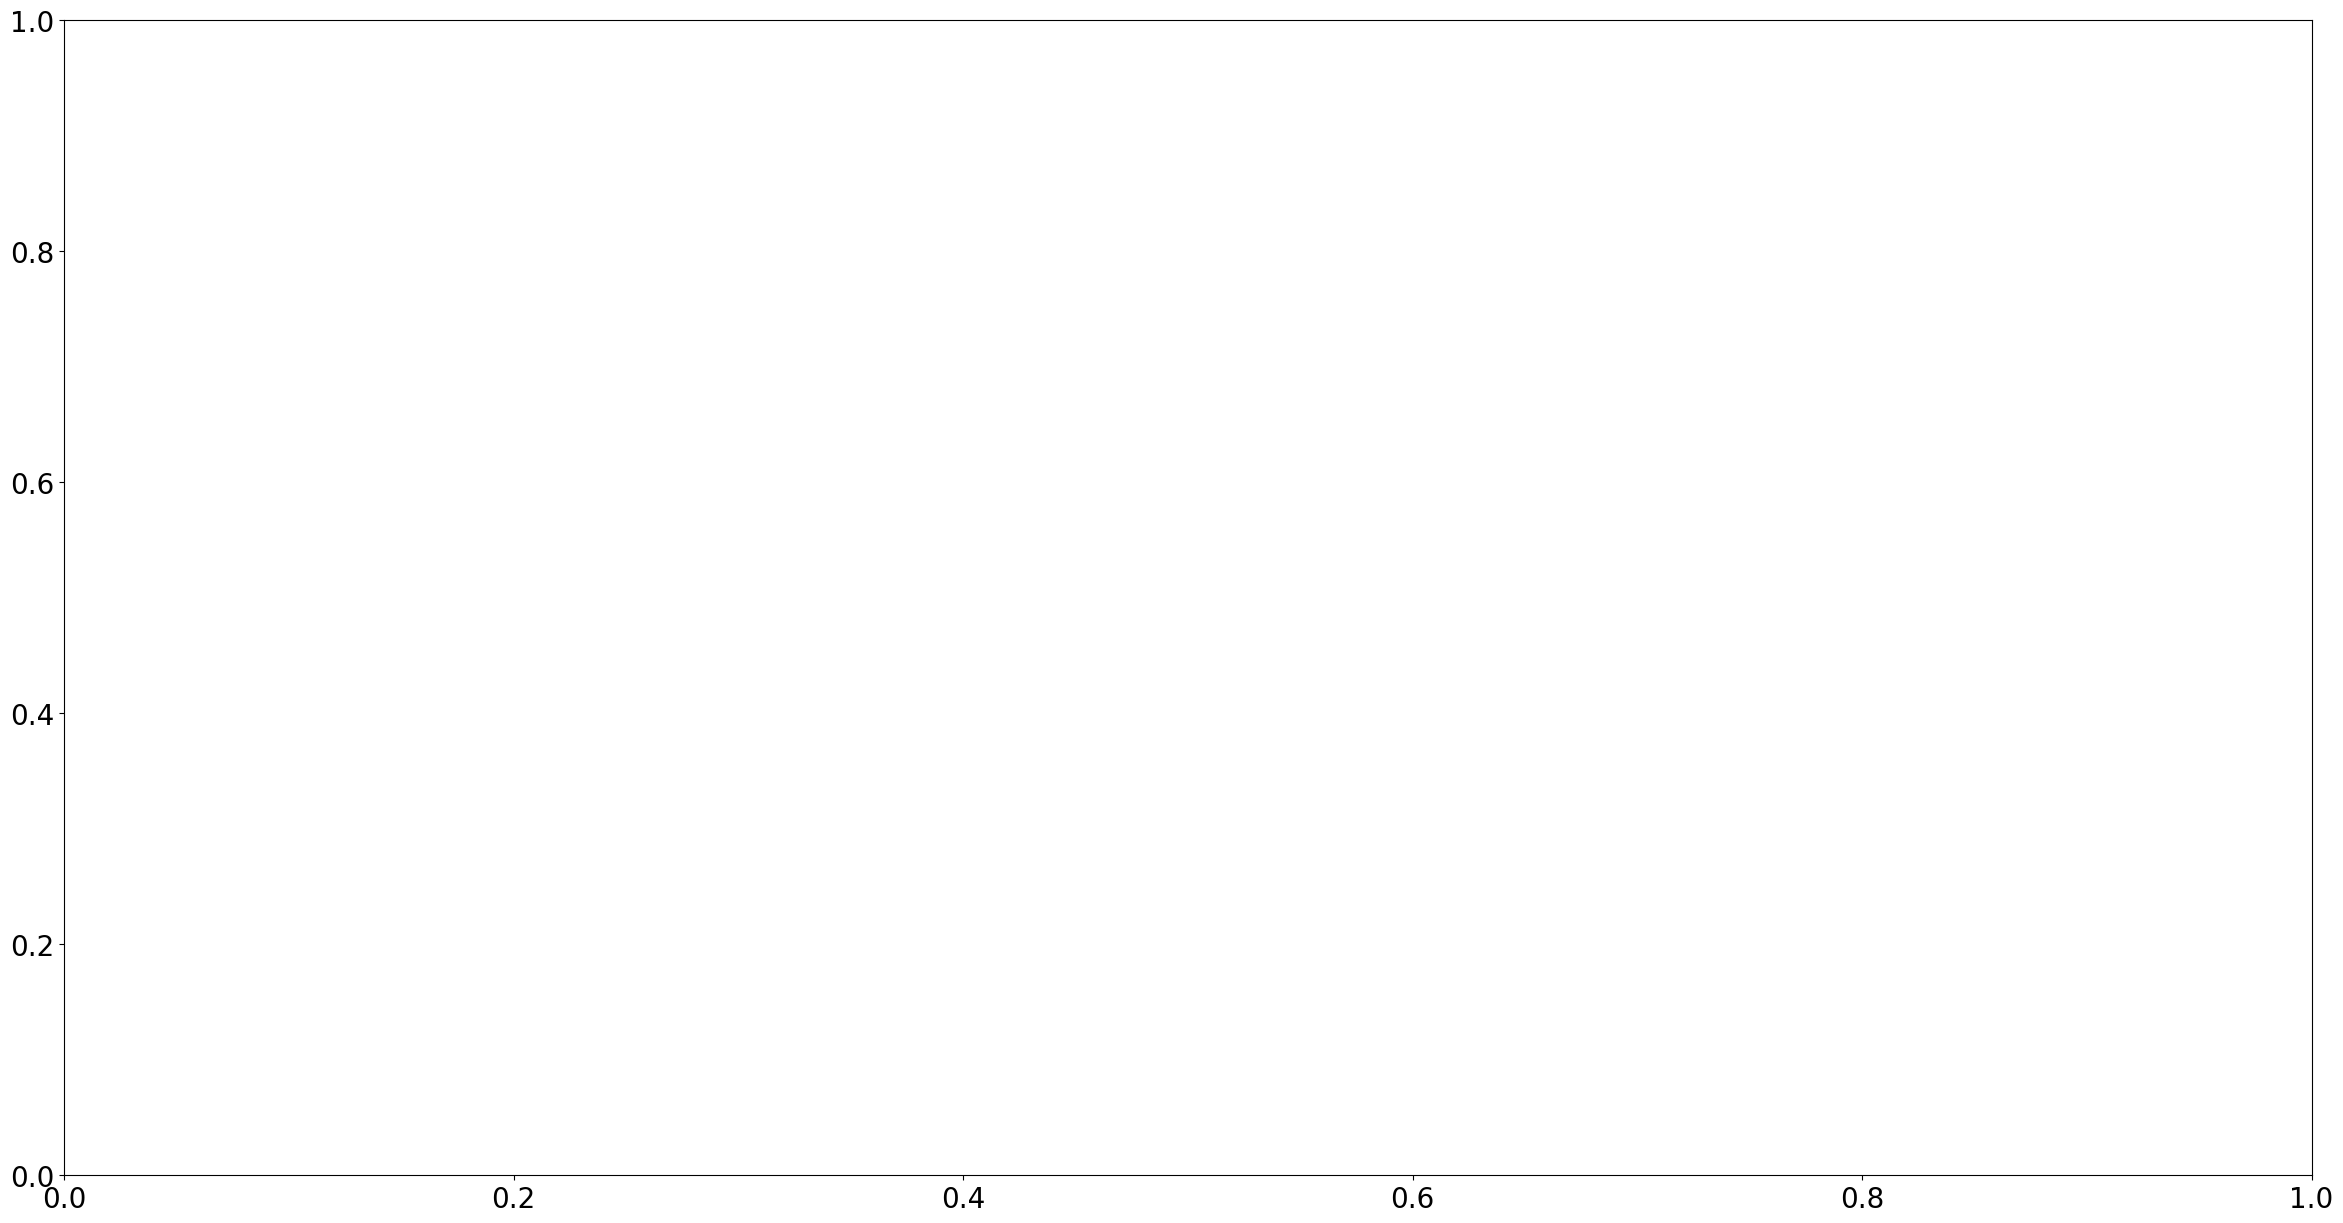

In [136]:
fig, axs = plt.subplots(figsize=(29, 15))
axs.hist(ntracks, bins=10, range=(0.0, 15), histtype='step', color='black', lw=2)

axs.set_xlabel('N tracks')
axs.set_title('Number of tracks from tracker')
# axs.legend()
plt.show()

NameError: name 'xy' is not defined

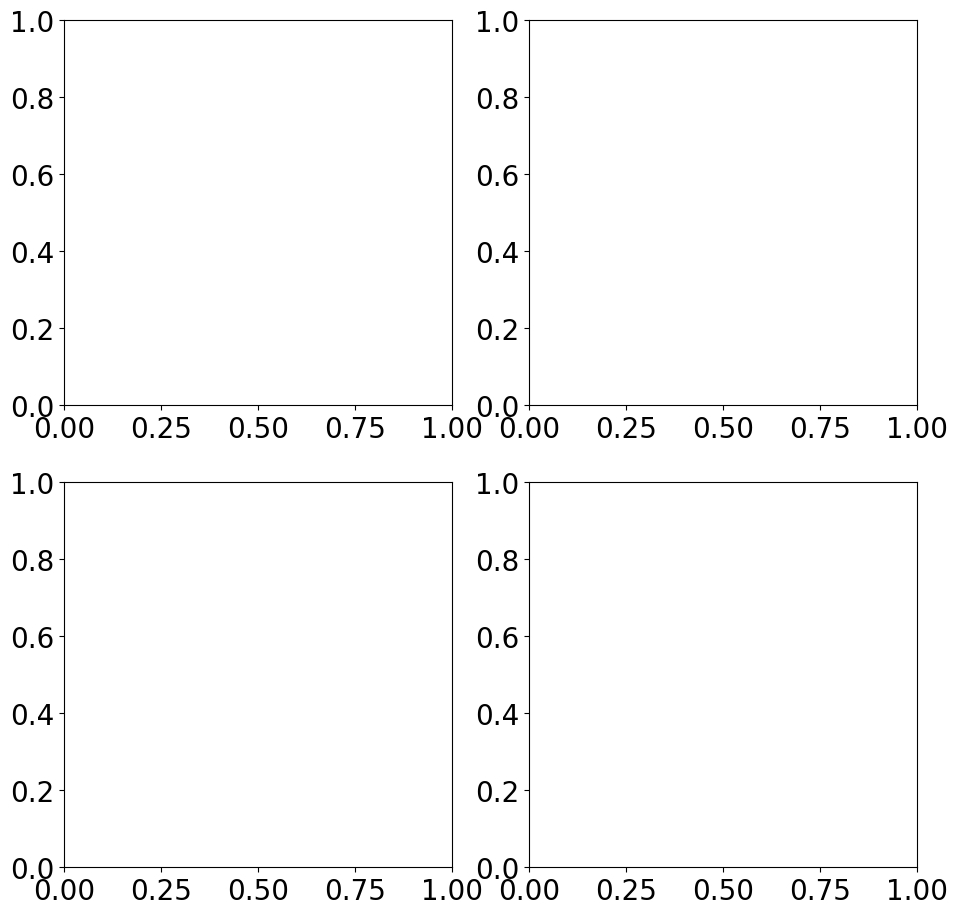

In [137]:
fig, axs = plt.subplots(2,2,figsize=(11, 11))
axs = axs.ravel()
for i in range(1,7):
    axs[i].scatter(xy[:,i,:][:, 0], xy[:,i,:][:, 1], s=2, color='black', label=f'All tracks z={xy[:,i][:, 2][0]}')
    axs[i].set_xlim(0, 100)
    axs[i].set_ylim(0, 100)
    axs[i].legend(loc=3, markerscale=5)
    axs[i].set_xlabel('X [mm]')
    axs[i].set_ylabel('Y [mm]')
plt.show()

In [138]:
xy

NameError: name 'xy' is not defined

In [139]:
ntracks[0:10]

NameError: name 'ntracks' is not defined

In [140]:
# track_files = {'/eos/home-i/iangelis/RD51/code/ebeam/analysis/July2023/Run320/anaRun320.root':'tracks'}

In [141]:
#file_tracker = uproot.open('/eos/home-i/iangelis/RD51/code/ebeam/analysis/July2023/Run320/anaRun320.root')

In [142]:
file_tracker = uproot.open('/eos/project-p/picosec/testbeam/2023_July_h4/tracker/reconstructed/anaRun460.root')

FileNotFoundError: [Errno 2] No such file or directory: '/eos/project-p/picosec/testbeam/2023_July_h4/tracker/reconstructed/anaRun460.root'

In [143]:
srs_tracks = file_tracker["tracks"]["srstriggerctr"].array(library="np")
ntracks = file_tracker["tracks"]["ntracks"].array(library="np")
ndetsintrack = file_tracker["tracks"]["ndetsintrack"].array(library="np")
distnextcluster = file_tracker["tracks"]["distnextcluster"].array()
trackchi2 = file_tracker["tracks"]["trackchi2"].array(library="np")

# totchanextcluster = ftracks['tracks']['totchanextcluster'].array(library='np')
N = np.size(srs_tracks)
distnextcluster = np.asarray(distnextcluster)
distnextcluster = np.reshape(distnextcluster, (N, 6))
# print(np.shape(distnextcluster))

track_cut = np.logical_and(
    np.logical_and(ntracks == 1, ndetsintrack == 6),
    np.all(distnextcluster >= 600, axis=1),
)
flag_vec = np.empty(N)
flag_vec = np.where(track_cut == True, 1, -111)

srst_un, srst_id = np.unique(srs_tracks, return_index=True)

# all_srs = np.intersect1d(common_srs, srst_un)
# for i in range(N_POOLS):
#     masks[i] = np.isin(uniq_srs[i], all_srs)

# mask_tracks = np.isin(srst_un, all_srs)


NameError: name 'file_tracker' is not defined

In [144]:
hits = file_tracker["tracks"]["hits"].array()
# hits = np.asarray(hits)[:, 3, :]
hits = np.asarray(hits)

NameError: name 'file_tracker' is not defined

NameError: name 'hits' is not defined

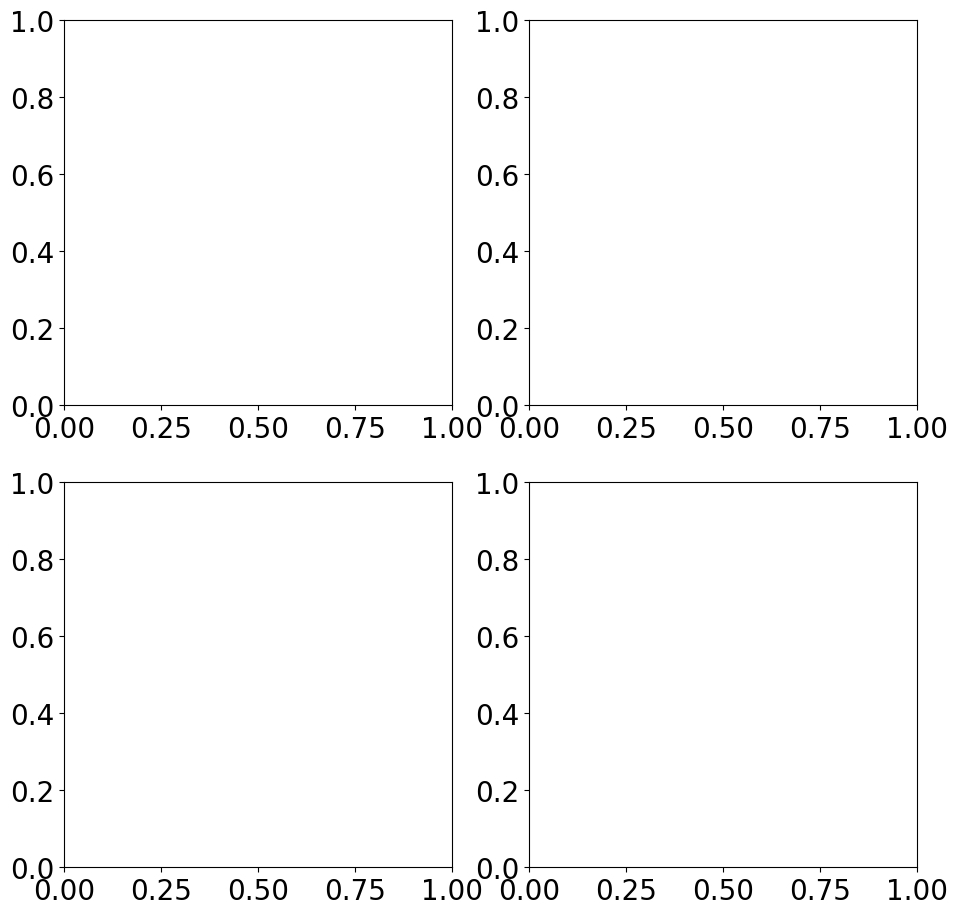

In [145]:
fig, axs = plt.subplots(2,2,figsize=(11, 11))
axs = axs.ravel()
for i in range(1,4):
    axs[i].scatter(hits[:,i,:][:, 0], hits[:,i,:][:, 1], s=2, color='black', label=f'All tracks z={hits[:,i][:, 2][0]}')
    axs[i].set_xlim(0, 100)
    axs[i].set_ylim(0, 100)
    axs[i].legend(loc=3, markerscale=5)
    axs[i].set_xlabel('X [mm]')
    axs[i].set_ylabel('Y [mm]')
plt.show()

In [ ]:
hits[:,:,:][:,1]

In [146]:
hits[:,:,:][:,13]

NameError: name 'hits' is not defined

In [147]:
hits[:,:,:]

NameError: name 'hits' is not defined

In [148]:
#define the cuts
mm_basic_cut = []

mcp_overflow = (mcp1_v>0)*(mcp1_v<=0.74)
mcp_basic_cut = mcp_overflow

for i in range(NPADS):       
    mm_overflow = (mm_vs[i] > 0.)*(mm_vs[i] < 0.36)*(mm_qalls[i] > 0)*(mm_qalls[i] < 250)
    qall_line = (mm_qalls[i] > 30. * mm_vs[i])
    cut = np.logical_and(mm_overflow * mcp_basic_cut, qall_line)
    mm_basic_cut.append(cut)


NameError: name 'mm_vs' is not defined

In [149]:
# cmap = plt.get_cmap('viridis')
cmap = plt.get_cmap('plasma')
pcolors = [cmap(i) for i in np.linspace(0, 1, 5)]

In [150]:
vv_thr = 0.01

xyc1 = np.where(np.logical_and(mm1_cut, mm1_v > vv_thr)*(mm1_qall < 250))

qq_thr = 5

xyq1 = np.where(np.logical_and(mm1_cut, mm1_qall > qq_thr))


NameError: name 'mm1_cut' is not defined

NameError: name 'hits' is not defined

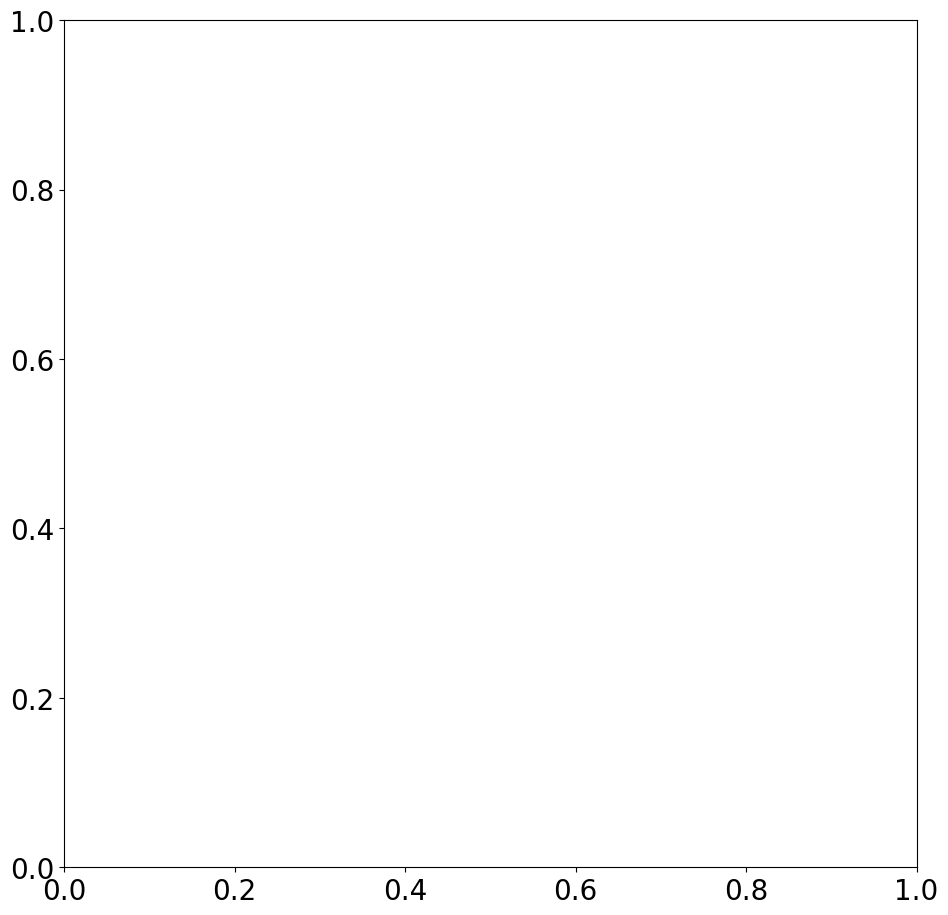

In [151]:
fig, axs = plt.subplots(figsize=(11, 11))
axs.scatter(hits[:, 11], hits[:, 0], s=2, color='black', label='All tracks')
axs.set_xlim(0, 100)
axs.set_ylim(0, 100)
axs.legend(loc=3, markerscale=5)
axs.set_xlabel('X [mm]')
axs.set_ylabel('Y [mm]')
plt.show()

NameError: name 'hits' is not defined

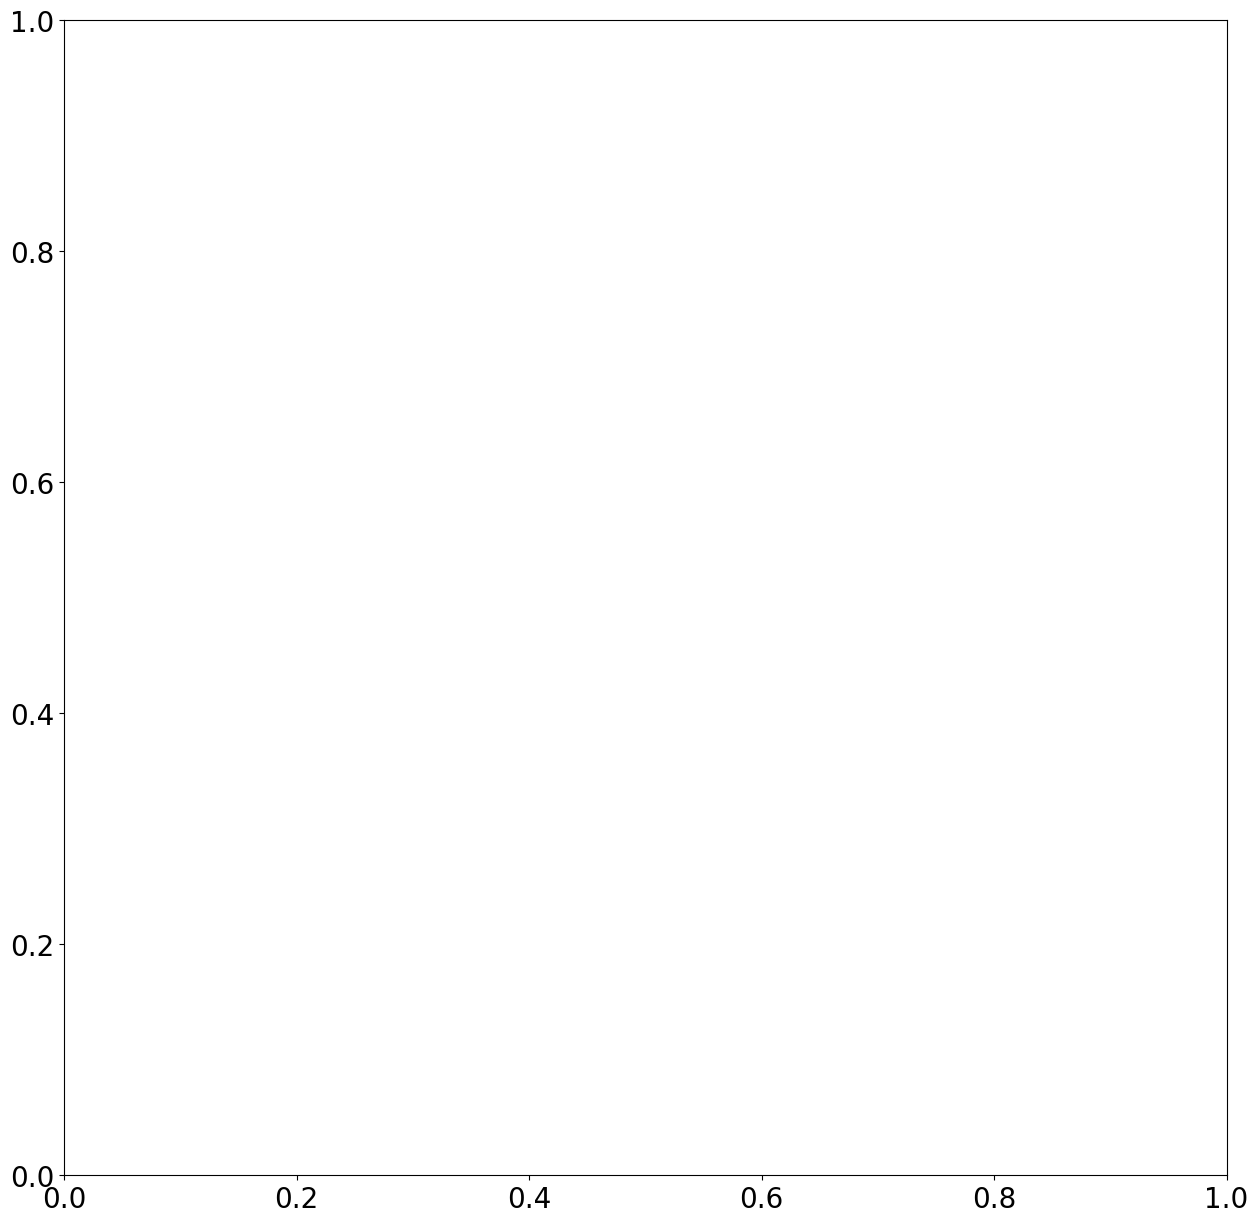

In [152]:
fig, axs = plt.subplots(figsize=(15, 15))
axs.scatter(hits[:, 0], hits[:, 1], s=1, color='black', label='All tracks')
axs.scatter(hits[:, 0][xyc1], hits[:, 10][xyc1], s=0.6, color=colors[0], label=f'{pnames[0]} Vpeak > {vv_thr}V')
axs.set_xlim(20, 80)
axs.set_ylim(20, 80)
axs.legend(loc=1, markerscale=10)
# axs.set_title(f"Run{rr}")
axs.set_xlabel('X [mm]')
axs.set_ylabel('Y [mm]')
plt.show()

In [153]:
%jsroot off
c = ROOT.TCanvas('c1', '', 1000, 1000)

hxy = ROOT.TH2D("hxy_all", '', 200, 20, 80, 200, 20, 80)
hxy.FillN(xy[:,0].size, np.array(xy[:, 0]), np.array(xy[:, 1]), 0, 1)
# hxy.FillN(len(xy[:,0]), xy[:, 0], xy[:, 1], 0, 1)

for i in range(201*201):
    if hxy.GetBinContent(i) < 15:
        hxy.SetBinContent(i, 0)

hxy.Draw('colz')
c.Draw()

NameError: name 'xy' is not defined

Warning in <TROOT::Append>: Replacing existing TH1: hxy_all (Potential memory leak).


In [154]:
%jsroot off
c = ROOT.TCanvas('c1', '', 2000, 1000)
c.Divide(2, 1)

hxy_mcp = ROOT.TH2D("hxy_mcp", '', 200, 20, 80, 200, 20, 80)
hxy_mcp.FillN(mcp1_q.size, np.array(xy[:, 0]), np.array(xy[:, 1]), mcp1_q, 1)


for i in range(201*201):
    if hxy.GetBinContent(i) < 15 or hxy_mcp.GetBinContent(i) < 0:
        hxy_mcp.SetBinContent(i, 0)
    else:
        hxy_mcp.SetBinContent(i, hxy_mcp.GetBinContent(i)/hxy.GetBinContent(i))


c.cd(1)
hxy_mcp.Draw('colz')
c.cd(2)
hxy_mcp.Draw('lego2z')
c.Draw()

NameError: name 'xy' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: hxy_mcp (Potential memory leak).


In [155]:
c = ROOT.TCanvas('cc','', 1000, 800)
c.Divide(3,2)

for i,j in enumerate(pad_order):
    c.cd(i+1)
    pad_hists[j].Draw('colz')
#     xytrksW_mm[i].Draw('colz')
c.Draw()

NameError: name 'pad_hists' is not defined

In [156]:
qlow = 0.5
qup = 80
nppe = 500
vl1in1, vu1in1, mdt1in1, sdt1in1, emdt1in1, esdt1in1 = fff(mm1_qall[xyc_inpad1], dt1[xyc_inpad1], qlow, qup, nppe, False, trange=[tranges[0][0], tranges[0][1]])

xxs11 = (vl1in1+vu1in1)*0.5
exs11 = (vl1in1-vu1in1)*0.5


NameError: name 'mm1_qall' is not defined

NameError: name 'xxs23' is not defined

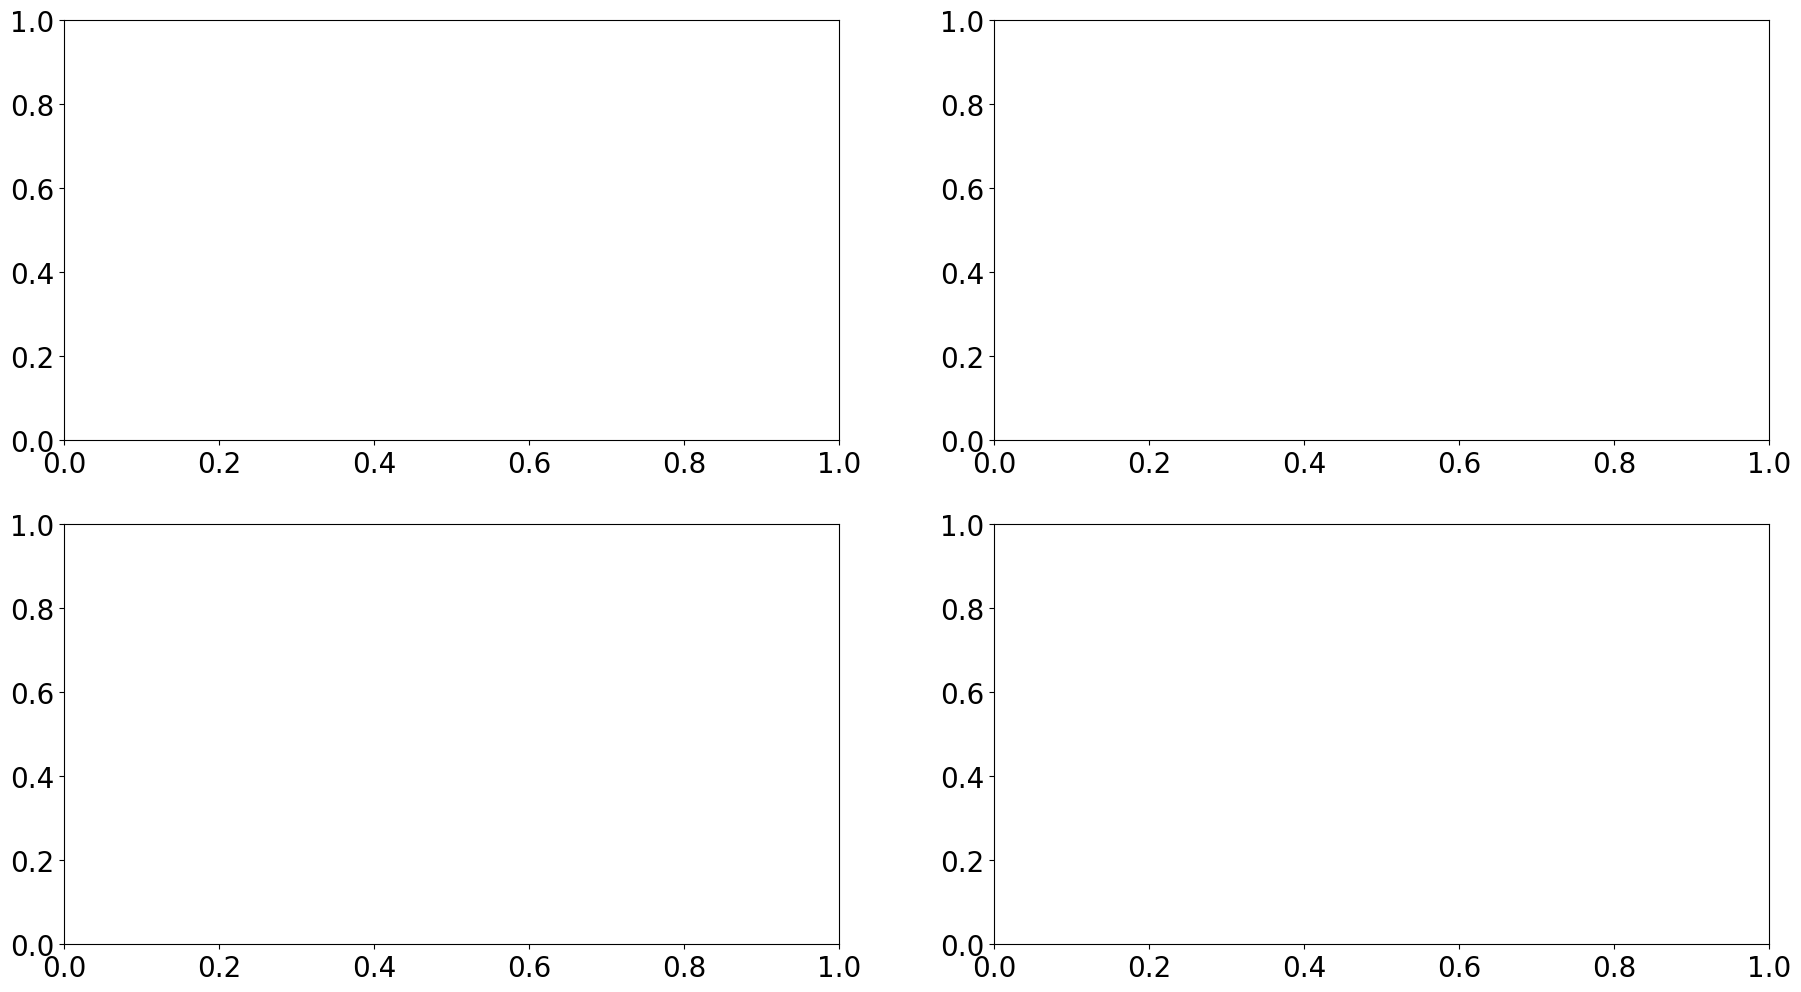

In [157]:
fig, axs = plt.subplots(2, 2, figsize=(22, 12))
iistart, iistop = 0, -1
axs = axs.ravel()
axs[0].errorbar(xxs23[iistart:iistop], mdt2in3[iistart:iistop], xerr=exs23[iistart:iistop], yerr=emdt2in3[iistart:iistop], fmt='o', ms=7, color=pcolors[0], label=f'{pnames[1]}, hit {pnames[2]}')
for i in range(4):
    axs[i].grid()
    axs[i].set_xlim(None, 50)
    axs[i].set_ylim(0, 1000)
    axs[i].set_ylim(show_ranges[i][0], show_ranges[i][1])
    axs[i].set_xlabel('Total Charge [pC]')
    axs[i].set_ylabel('SAT [ps]')
    axs[i].legend(loc=1)

axs[0].set_xlim(0, 5)
plt.show()


In [158]:
# fig, axs = plt.subplots(2, 2, figsize=(22, 12))
# iistart, iistop = 0, -1
# axs = axs.ravel()

# axs[0].errorbar(xxs23[iistart:iistop], sdt2in3[iistart:iistop], xerr=exs23[iistart:iistop], yerr=esdt2in3[iistart:iistop], fmt='o', ms=7, color=pcolors[0], label=f'{pnames[1]}, hit {pnames[2]}')



# for i in range(4):
#     axs[i].grid()
#     axs[i].set_xlim(None, 50)
# #     axs[i].set_ylim(0, 1000)
# #     axs[i].set_ylim(show_ranges[i][0], show_ranges[i][1])
#     axs[i].set_xlabel('Total Charge [pC]')
#     axs[i].set_ylabel('Resolution [ps]')
#     axs[i].legend(loc=1)

# # axs[0].set_xlim(0, 5)
# plt.show()


# Total Charge based Active Pad

In [159]:
# #same
# fig, axs = plt.subplots(2, 2, figsize=(22, 12))
# iistart, iistop = 0, -1
# axs = axs.ravel()
# a = np.linspace(5, 80, 300)

# axs[0].errorbar(xxsc22_qa[iistart:iistop], mdt2in2_qa[iistart:iistop], xerr=exsc22_qa[iistart:iistop], yerr=emdt2in2_qa[iistart:iistop], fmt='o', ms=7, color=colors[1], label=f'{pnames[1]}, hit {pnames[1]}')
# axs[0].plot(a, expo2_np(a, pars2in2_qa), color=colors[1])

# for i in range(4):
#     axs[i].grid()
#     axs[i].set_xlim(None, 80)
# #     axs[i].set_ylim(0, 1000)
# #     axs[i].set_ylim(show_ranges[i][0], show_ranges[i][1])
#     axs[i].set_xlabel('Total Charge [pC]')
#     axs[i].set_ylabel('SAT [ps]')
#     axs[i].legend(loc=1)

# # axs[0].set_xlim(0, 5)
# plt.show()


In [160]:
# qlow = 0.5
# qup = 80

# nppe = 500


# _,_, mdt1in1_qa_cor, sdt1in1_qa_cor, emdt1in1_qa_cor, esdt1in1_qa_cor = fff(mm1_qall[xyc_pad1_qa], dt1[xyc_pad1_qa]-expo2_np(mm1_qall[xyc_pad1_qa], pars1in1_qa)*1e-3, qlow, qup, nppe, False, trange=[-5000,5000])

In [161]:
# #same
# fig, axs = plt.subplots(2, 2, figsize=(22, 12))
# iistart, iistop = 0, -1
# axs = axs.ravel()

# axs[0].errorbar(xxsc22_qa[iistart:iistop], mdt2in2_qa_cor[iistart:iistop], xerr=exsc22_qa[iistart:iistop], yerr=emdt2in2_qa_cor[iistart:iistop], fmt='o', ms=7, color=colors[1], label=f'{pnames[1]}, hit {pnames[1]}')


# for i in range(4):
#     axs[i].grid()
#     axs[i].set_xlim(None, 80)
# #     axs[i].set_ylim(0, 1000)
# #     axs[i].set_ylim(show_ranges[i][0], show_ranges[i][1])
#     axs[i].set_xlabel('Total Charge [pC]')
#     axs[i].set_ylabel('SAT [ps]')
#     axs[i].legend(loc=1)

# # axs[0].set_xlim(0, 5)
# plt.show()


In [162]:
# spars1in1_qa = sat_fit(xxsc11_qa, sdt1in1_qa, exsc11_qa, esdt1in1_qa, iistart=0, iistop=None, xl=0.5, xu=80, pars=[-0.1,3.0,-1,0.5, 40])


In [163]:
# #same
# fig, axs = plt.subplots(2, 2, figsize=(22, 12))
# iistart, iistop = 0, -1
# axs = axs.ravel()
# a = np.linspace(5, 80, 300)

# axs[0].errorbar(xxsc22_qa[iistart:iistop], sdt2in2_qa[iistart:iistop], xerr=exsc22_qa[iistart:iistop], yerr=esdt2in2_qa[iistart:iistop], fmt='o', ms=7, color=colors[1], label=f'{pnames[1]}, hit {pnames[1]}')
# axs[0].plot(a, expo2_np(a, spars2in2_qa), color=colors[1])




# for i in range(4):
#     axs[i].grid()
#     axs[i].set_xlim(None, 80)
# #     axs[i].set_ylim(0, 1000)
# #     axs[i].set_ylim(show_ranges[i][0], show_ranges[i][1])
#     axs[i].set_xlabel('Total Charge [pC]')
#     axs[i].set_ylabel('Resolution [ps]')
#     axs[i].legend(loc=1)

# # axs[0].set_xlim(0, 5)
# plt.show()


In [164]:
# gpull11 = (dt1[xyc_pad1_qa]-expo2_np(mm1_qall[xyc_pad1_qa], pars1in1_qa)*1e-3)/(expo2_np(mm1_qall[xyc_pad1_qa], spars1in1_qa)*1e-3)

In [165]:
# cg = ROOT.TCanvas('cg', '', 1000, 800)
# cg.Divide(2,2)

# hgpull11 = ROOT.TH1D('hgp11', '', 100, -10,10)
# hgpull11.FillN(gpull11.size, gpull11, 0, 1)

# cg.cd(1)
# hgpull21.Draw()
# hgpull21.Fit('gaus')

# cg.Draw()

# Pad Centers

In [166]:
# tranges_xx = [
#  [-12000, -11000],
#  [-16500, -16000],
#  [-15700, -15000],
#  [-17000, -13000],
# ]

# hmean_sat = np.zeros((4, 10, 10))
# hmean_rms = np.zeros((4, 10, 10))
# htemps1 = []
# htemps2 = []
# htemps3 = []
# htemps4 = []

# htemps = [htemps1,htemps2,htemps3,htemps4]

# for ip,jp in enumerate(pad_order):
#     xbins = np.linspace(centers_s[0][jp]-5, centers_s[0][jp]+5, 11)
#     ybins = np.linspace(centers_s[1][jp]-5, centers_s[1][jp]+5, 11)
    
#     for j in range(1, 11):
#         for i in range(1,11):
    
#             xybin_cut = np.where(np.logical_and((x_s > xbins[i-1])*(x_s < xbins[i]), (y_s > ybins[j-1])*(y_s < ybins[j])))
# #             qq_cut = mm_qalls[ip][xybin_cut]>3
#         #             qq_in_bin = mm1_qall[box_cut][xybin_cut]
#             dt_in_bin = 1e3*mm_dts[jp][xybin_cut]
#             hxtemp = ROOT.TH1D(f'htemp{jp}_{i}_{j}', '', 100, tranges_xx[jp][0], tranges_xx[jp][1])

#             #             hxtemp.FillN(qq_in_bin.size, qq_in_bin, 0)
#             hxtemp.FillN(dt_in_bin.size, dt_in_bin, 0)
#             hxtemp.Fit('gaus', 'Q')
#             rsf = hxtemp.Fit('gaus', 'SQ')
#             if rsf.Get():
#                 hmean_sat[jp,i-1,j-1] = rsf.Parameter(1)
#                 hmean_rms[jp,i-1,j-1] = rsf.Parameter(2) 
            
#             htemps[jp].append(hxtemp)
# #     break

In [167]:
# fig, axs = plt.subplots(10, 10, figsize=(100, 100))
# for ip,jp in enumerate(pad_order):
#     xbins = np.linspace(centers_s[0][jp]-5, centers_s[0][jp]+5, 11)
#     ybins = np.linspace(centers_s[1][jp]-5, centers_s[1][jp]+5, 11)
#     for j in range(1, 11):
#         for i in range(1,11):
    
#             xybin_cut = np.where(np.logical_and((x_s > xbins[i-1])*(x_s < xbins[i]), (y_s > ybins[j-1])*(y_s < ybins[j])))
#             axs[j-1,i-1].scatter(x_s[xybin_cut], y_s[xybin_cut])
#             axs[j-1,i-1].set_xlim(-11,11)
#             axs[j-1,i-1].set_ylim(-11,11)
#     break
# plt.show()

In [168]:
# %jsroot off
# c = ROOT.TCanvas('cbins','', 8000, 8000)
# c.Divide(10, 10)
# for i in range(0, 100):
#     c.cd(i+1)
#     htemps[1][i].Draw()
# #     htemps[i].Fit('gaus', 'Q')

# c.Draw()

In [169]:
ROOT.gStyle.SetOptStat()

# Multiplicity

In [170]:
# dt1c = np.zeros((N, 2))

# dt1c[xyc_pad1_qa, 0] = 1e3*dt1[xyc_pad1_qa]-expo2_np(mm1_qall[xyc_pad1_qa], pars1in1_qa)
# dt1c[xyc_pad1_qa, 1] = expo2_np(mm1_qall[xyc_pad1_qa], spars1in1_qa)

In [171]:
class share_fun():
    def __init__(self, times, resols):
        self.times = times
        self.resols = resols
    def __call__(self, params):
        test = params[0]
        res = np.sum( np.square( test - self.times ) / np.square( self.resols ) )
        return res

